# Training and Inference

After we have done the preprocessing step, which includes converting the images and labels into numpy array, in this notebook we will do the training until inference.

We will also build a lite model based on MobileNetV2 [[1]](https://arxiv.org/abs/1801.04381) to achieve the small number of parameters.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import random
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from imgaug import augmenters as iaa
import random
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, BatchNormalization, ReLU, DepthwiseConv2D, Add, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K
from keras.layers.convolutional import Conv2D
from keras.layers import LeakyReLU
from keras.regularizers import l2
from keras.models import Model, Sequential
from keras import backend as K

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


---
# Load Dataset

First, we need to load our saved data from the previous notebook. We also want to visualize the data. This can be done with this following code.

(6000, 96, 96) (6000, 4)


/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


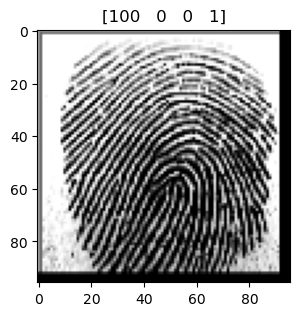

In [3]:
x_real = np.load('/kaggle/input/socofing-96/x_real_96.npz')['data']
y_real = np.load('/kaggle/input/socofing-96/y_real_96.npy')
x_easy = np.load('/kaggle/input/socofing-96/x_easy_96.npz')['data']
y_easy = np.load('/kaggle/input/socofing-96/y_easy_96.npy')
x_medium = np.load('/kaggle/input/socofing-96/x_medium_96.npz')['data']
y_medium = np.load('/kaggle/input/socofing-96/y_medium_96.npy')
x_hard = np.load('/kaggle/input/socofing-96/x_hard_96.npz')['data']
y_hard = np.load('/kaggle/input/socofing-96/y_hard_96.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')

Since we got different variations of altered fingerprint, we will concatenate all of the altered samples. And also, we want to independently split all of the data based on its subject. We will do `90`:`0.5`:`0.5` split w.r.t. the unique subject. We can achieve that with the help of this following code: 

In [4]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
x_data = np.expand_dims(x_data, -1)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x = np.unique(label_data[:,0])
tn, ts = train_test_split(x, test_size=0.1, random_state=32)
isin_tn, isin_ts = np.isin(label_data[:,0], tn), np.isin(label_data[:,0], ts)
x_train, x_val, label_train, label_val = x_data[isin_tn], x_data[isin_ts], label_data[isin_tn], label_data[isin_ts]

x = np.unique(label_val[:,0])
tv, ts = train_test_split(x, test_size=0.1, random_state=32)
isin_tn, isin_ts = np.isin(label_val[:,0], tv), np.isin(label_val[:,0], ts)
x_val, x_test, label_val, label_test = x_val[isin_tn], x_val[isin_ts], label_val[isin_tn], label_val[isin_ts]

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)
print(x_test.shape, label_test.shape)

(49270, 96, 96, 1) (49270, 4)
(44396, 96, 96, 1) (44396, 4)
(4379, 96, 96, 1) (4379, 4)
(495, 96, 96, 1) (495, 4)


After splitting the data, we want to perform Data Augmentation. First, we need to define the augmentation process before we do it on our created DataGenerator class. This augmentation includes scaling, translation, and also rotation.

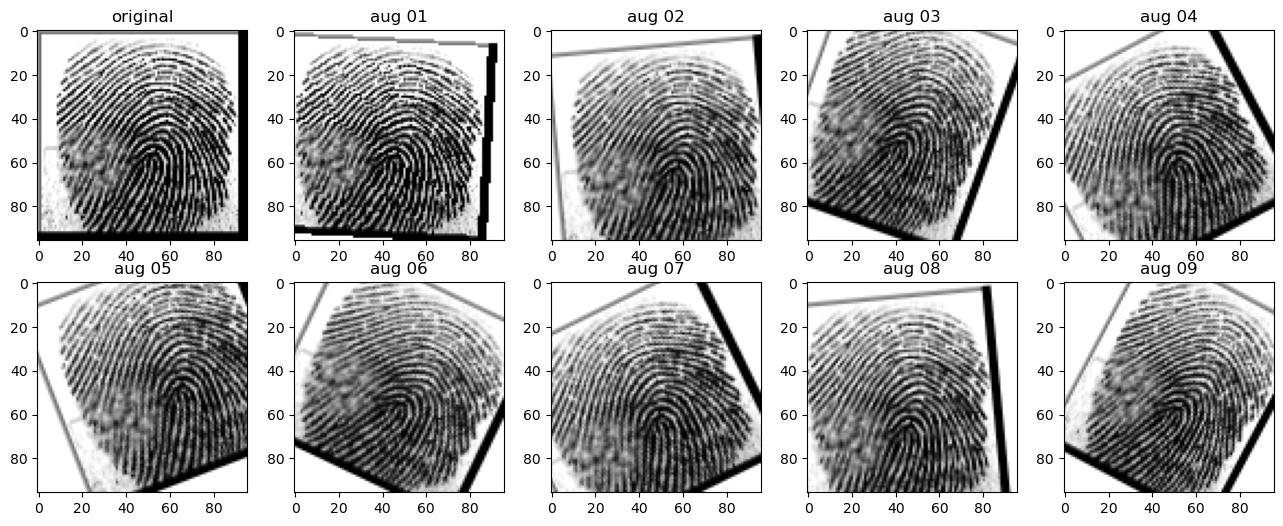

In [5]:
augs = [x_train[1]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_train[1].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

Before we feed our data into the DataGenerator, we need to make a dictionary to make such index w.r.t. the label. This is just simply indexing our label, so we can easily index them in the DataGenerator.

In [6]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

The next step, we want to make our own DataGenerator that suitable for our case. In general, this DataGenerator will batching our data and make a fingerprint pair, which labelled 0 if the pair of fingerprint is matched and labelled 1 otherwise.

We also perform the DataAugmentation that we have done in our DataGenerator.

In [7]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 96, 96, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = np.expand_dims(self.x_real[self.label_real_dict[match_key]], -1)
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break
                x2_batch[i] =  np.expand_dims(self.x_real[unmatch_idx], -1)
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [8]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=True)

---
# Model

## Siamese Nets

We will try to use the Siamese network [[2]](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf). A Siamese network is a type of neural network that is designed to compare two input sequences and determine whether they are similar or dissimilar. The network architecture involves two identical sub-networks that share the same weights and architecture. These sub-networks are connected to a final output layer that computes a similarity score between the two input sequences. This type of network is suitable for fingerprint verification problem (i.e., verify whether two fingerprints belonged to the same person or not).

The goal of a Siamese network is to learn a function that maps input sequences to a common feature space where the similarity between them can be computed. The network takes two input sequences, $x_1$ and $x_2$, and passes them through the identical sub-networks, $f_1$ and $f_2$, to obtain two feature vectors. These feature vectors are then passed to the output layer $g$, which computes the similarity score $s$, between the two sequences:

$$s = g(f_1, f_2)$$

where $g$ is a function that computes the similarity score between the two feature vectors.

<center>
    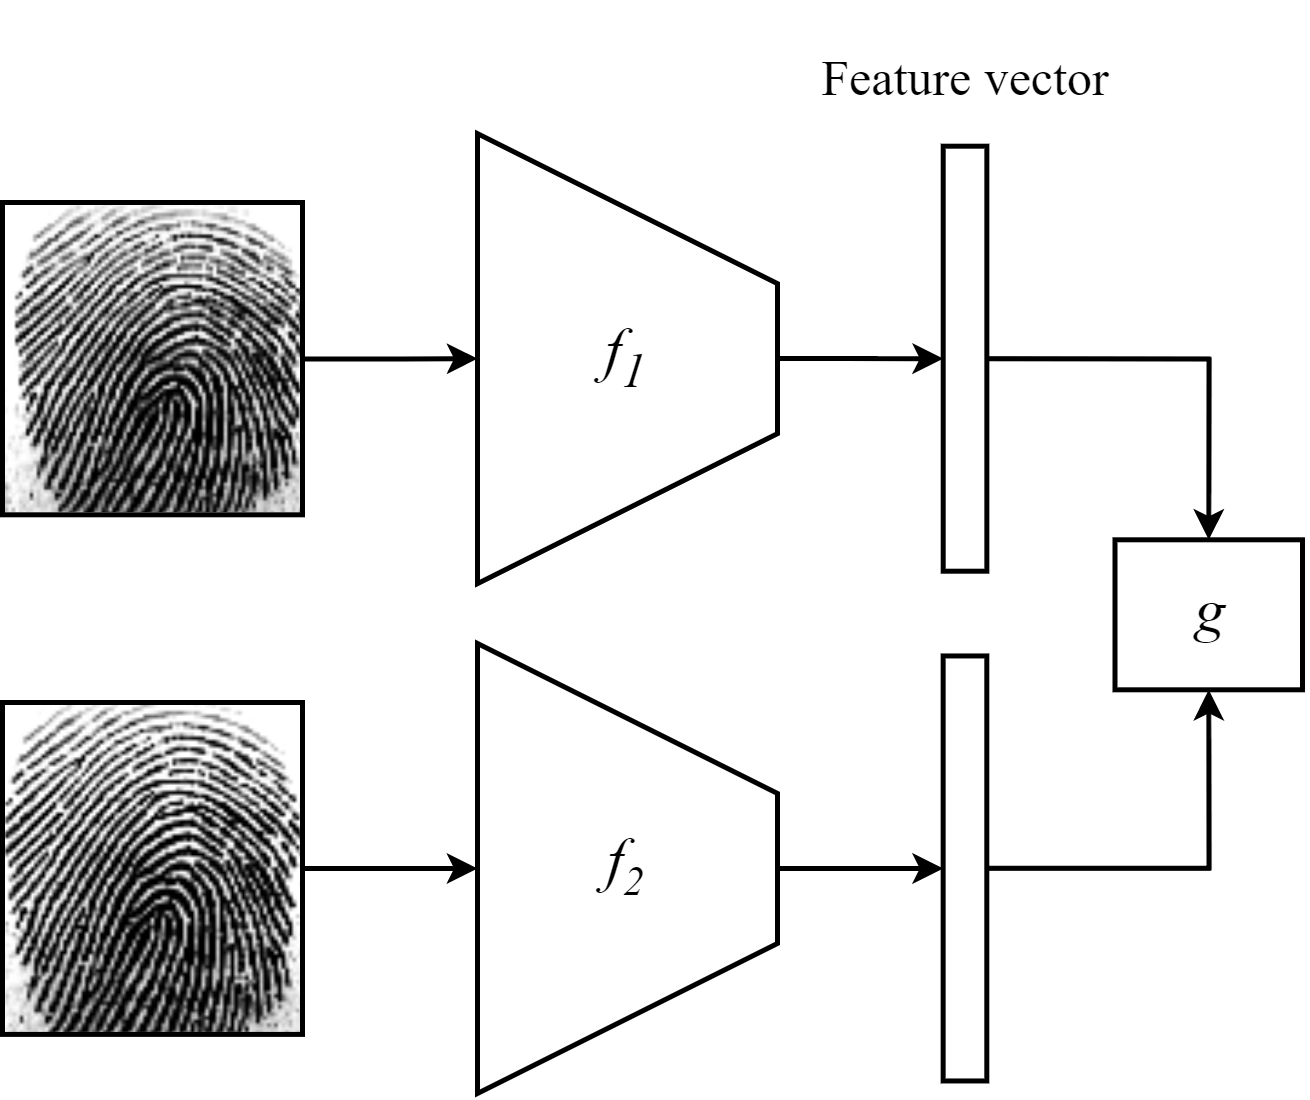
</center>

During the training phase, the Siamese network learns to minimize the distance between the embeddings of two input sequences that belong to the same class and maximize the distance between the embeddings of two input sequences that belong to different classes. This is typically done using a contrastive loss function:

$$L = y \times d^2 + (1-y) \times max(margin - d, 0)^2$$

where $y$ is the label that indicates whether the two input sequences belong to the same class ($y=1$) or different classes ($y=0$), $d$ is the Euclidean distance between the two feature vectors, and $margin$ is a hyperparameter that controls the minimum distance between embeddings of the same class.

By minimizing the contrastive loss function, the Siamese network learns to extract useful features from the input sequences that can be used to compute their similarity. This makes the network well-suited for a variety of tasks that involve comparing and classifying input sequences, such as fingerprint verification, face recognition, and text classification.

## Encoder

We will use MobileNetV2 [[1]](https://arxiv.org/abs/1801.04381) as the encoder in our Siamese network. MobileNetV2 is a popular convolutional neural network architecture that is designed for efficient computation on mobile and embedded devices.

As an encoder, MobileNetV2 is able to extract useful features from the input fingerprint images and map them to a lower-dimensional feature space where the similarity between them can be computed. The use of MobileNetV2 as the encoder helps to reduce the computational complexity of the network while maintaining high accuracy, making it a practical choice for real-world applications.

However, we will slightly modify the MobileNetV2 to reduce the parameters. We will exclude the fully connected layer in the last layer and reduce the bottleneck layer. Thus, we will achieve a relatively low parameters while still preserving the nature of the architecture.

First, we will define our network with this following code.

In [9]:
x1 = layers.Input(shape=(96, 96, 1))
x2 = layers.Input(shape=(96, 96, 1))

def expansion_block(x,t,filters,block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t*filters
    x = Conv2D(total_filters,1,padding='same',use_bias=False, name =    prefix +'expand')(x)
    x = BatchNormalization(name=prefix +'expand_bn')(x)
    x = ReLU(6,name = prefix +'expand_relu')(x)
    return x

def depthwise_block(x,stride,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3,strides=(stride,stride),padding ='same', use_bias = False, name = prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix +'dw_bn')(x)
    x = ReLU(6,name = prefix +'dw_relu')(x)
    return x

def projection_block(x,out_channels,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels,kernel_size = 1,   padding='same',use_bias=False,name= prefix + 'compress')(x)
    x = BatchNormalization(name=prefix +'compress_bn')(x)
    return x

def Bottleneck(x,t,filters, out_channels,stride,block_id):
    y = expansion_block(x,t,filters,block_id)
    y = depthwise_block(y,stride,block_id)
    y = projection_block(y, out_channels,block_id)
    if y.shape[-1]==x.shape[-1]:
        y = keras.layers.Add()([x, y])
    return y

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32,3,strides=(2,2),padding='same', use_bias=False)(input)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name='conv1_relu')(x)
    x = depthwise_block(x,stride=1,block_id=1)
    x = projection_block(x, out_channels=16,block_id=1)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 2,block_id = 2)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 3)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 4)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 5)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 6)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 2,block_id = 7)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 8)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 9)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 10)
    x = Conv2D(filters = 1280,kernel_size = 1,padding='same',use_bias=False, name = 'last_conv')(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)
    x = GlobalAveragePooling2D(name='global_average_pool')(x)
    return Model(input, x)

input_shape = (96,96,1)

base_network = create_base_network(input_shape)

x1_net = base_network(x1)
x2_net = base_network(x2)

After defining the network, we will define the component in $g$, which are Euclidean distance, Contrastive loss, and Accuracy that we will pass to the model.

In [10]:
def euclidean_distance(vects):
    x, y = vects
    x, y = tf.math.l2_normalize(x, 1), tf.math.l2_normalize(y, 1)
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    y_true = tf.cast(y_true, tf.float32)
    mean =  K.mean(y_true * square_pred + (1 - y_true) * margin_square)   
    return mean

def accuracy_fixed(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 1, y_true.dtype)))

In [11]:
# add a lambda layer
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([x1_net, x2_net])


In [12]:
model = Model([x1, x2], distance)

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 1280)         335232      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

Our network only got ~330k parameters, which is relatively low. Next, we need to compile the model and train it. We will use Adam optimizer with its standard learning rate for 20 epochs.

In [14]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy_fixed])

In [15]:
history = model.fit_generator(train_gen, epochs=20, validation_data=val_gen) 

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


1387/1387 [==============================] - 100s 64ms/step - loss: 0.0361 - accuracy_fixed: 0.7730 - val_loss: 0.0167 - val_accuracy_fixed: 0.7904
Epoch 2/20
1387/1387 [==============================] - 88s 64ms/step - loss: 0.0213 - accuracy_fixed: 0.8285 - val_loss: 0.0120 - val_accuracy_fixed: 0.8518
Epoch 3/20
1387/1387 [==============================] - 88s 63ms/step - loss: 0.0124 - accuracy_fixed: 0.8788 - val_loss: 0.0112 - val_accuracy_fixed: 0.8254
Epoch 4/20
1387/1387 [==============================] - 89s 64ms/step - loss: 0.0077 - accuracy_fixed: 0.9128 - val_loss: 0.0057 - val_accuracy_fixed: 0.9242
Epoch 5/20
1387/1387 [==============================] - 90s 65ms/step - loss: 0.0050 - accuracy_fixed: 0.9339 - val_loss: 0.0055 - val_accuracy_fixed: 0.9122
Epoch 6/20
1387/1387 [==============================] - 89s 64ms/step - loss: 0.0036 - accuracy_fixed: 0.9460 - val_loss: 0.0024 - val_accuracy_fixed: 0.9511
Epoch 7/20
1387/1387 [==============================] - 89s 64

Our model is trained well and smoothly. We got the validation accuracy ~0.97. Great!

Now, let's plot our model's prediction to get a sense of our model performance.

1/1 [==============================] - 0s 23ms/step


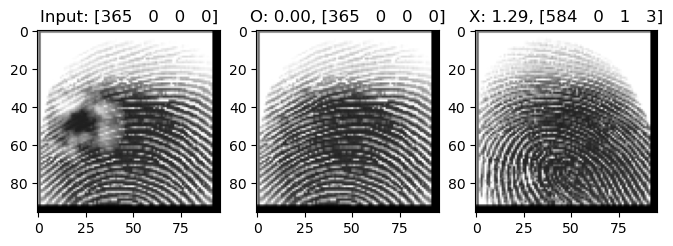

1/1 [==============================] - 0s 22ms/step


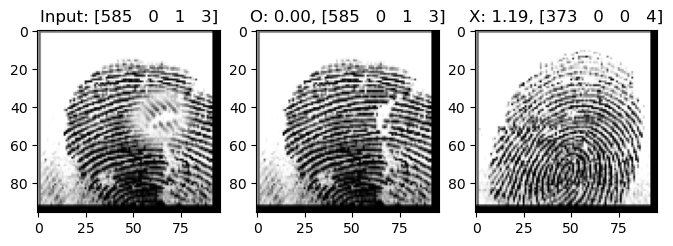

1/1 [==============================] - 0s 22ms/step


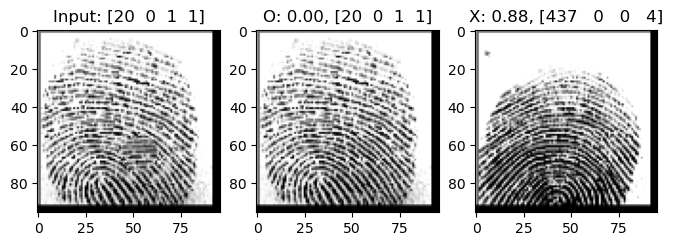

1/1 [==============================] - 0s 22ms/step


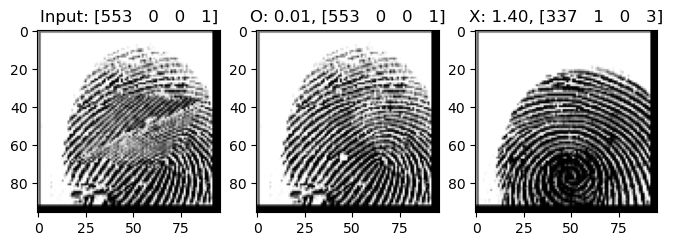

1/1 [==============================] - 0s 22ms/step


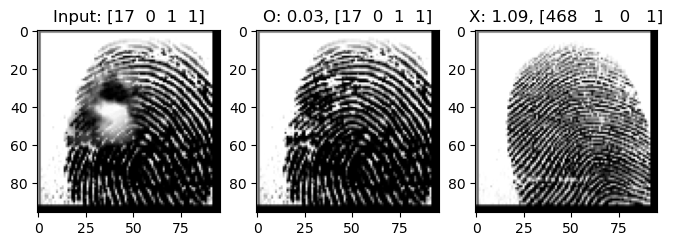

1/1 [==============================] - 0s 22ms/step


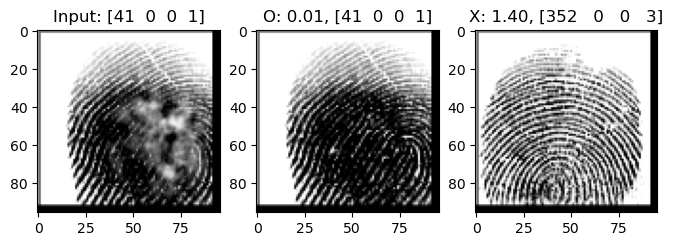

1/1 [==============================] - 0s 21ms/step


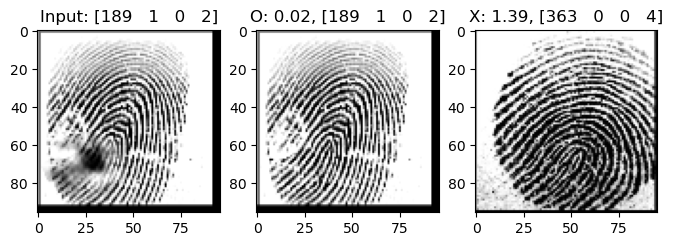

1/1 [==============================] - 0s 22ms/step


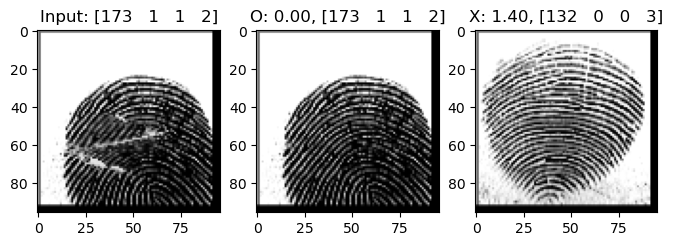

1/1 [==============================] - 0s 24ms/step


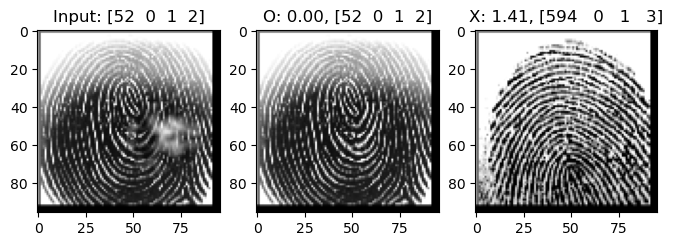

1/1 [==============================] - 0s 24ms/step


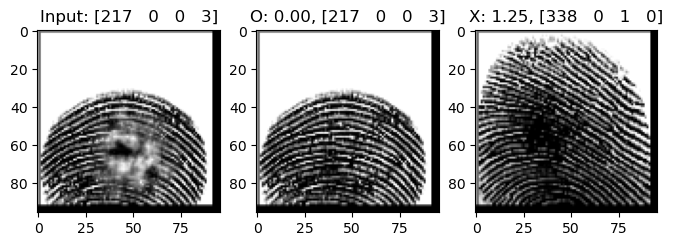

In [16]:
# new user fingerprint input

for i in range(0,10):
    random_idx = random.randint(0, len(x_val))

    random_img = x_val[random_idx]
    random_label = label_val[random_idx]

    seq = iaa.Sequential([
    #     iaa.GaussianBlur(sigma=(0, 0.5)),
    #     iaa.Affine(
    #         scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
    #         translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
    #         rotate=(-30, 30),
    #         order=[0, 1],
    #         cval=255
    #     )
    ], random_order=True)

    random_img = seq.augment_image(random_img).reshape((1, 96, 96, 1)).astype(np.float32) / 255.

    # matched image
    match_key = random_label.astype(str)
    match_key = ''.join(match_key).zfill(6)

    rx = x_real[label_real_dict[match_key]].reshape((1, 96, 96, 1)).astype(np.float32) / 255.
    ry = y_real[label_real_dict[match_key]]

    pred_rx = model.predict([random_img, rx])

    # unmatched image
    unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

    ux = x_real[unmatch_idx].reshape((1, 96, 96, 1)).astype(np.float32) / 255.
    uy = y_real[unmatch_idx]

    pred_ux = model.predict([random_img, ux])

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.title('Input: %s' %random_label)
    plt.imshow(random_img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('O: %.02f, %s' % (pred_rx, ry))
    plt.imshow(rx.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('X: %.02f, %s' % (pred_ux, uy))
    plt.imshow(ux.squeeze(), cmap='gray')
    plt.show()

---
# Evaluation

Let's test our model on test data. To save time, we will test the performance on the randomly picked 100 data points on the test data. 

Since our model prediction is a distance, we need to set a threshold to determine whether the prediction is genuine or impostor. Generally, genuine prediction will close to 0 and impostor prediction will far from 0. For this testing, we will set our threshold to 0.3.


In [17]:
print(x_test.shape, label_test.shape)

(495, 96, 96, 1) (495, 4)


In [18]:
test_sz = 200
randm = np.random.randint(0, high=len(x_test), size=test_sz)

We will create 4 list to collect the model prediction. First, we will filter out the true value both on genuine and impostor as a ground truth. Second, we will append the prediction of our model based on certain threshold. If the prediction is less than 0.3, then it will be genuine prediction, and impostor otherwise. Thus, these 4 list will help us to assess the model's performance.

In [19]:
from tqdm import tqdm

def predict_model(model,x_val, label_val, thresh) :
    genuine_true, impostor_true, genuine_preds, impostor_preds = [], [], [], []
    threshold = thresh
    
    with tqdm(total=len(x_val)) as pbar:
        for i, img_r in enumerate(x_val):
            label_r = label_val[i]
            match_key = label_r.astype(str)
            match_key = ''.join(match_key).zfill(6)

            subject_id_r  = label_r[0]
            gender_r = label_r[1]
            left_or_right_hand_r = label_r[2] 
            finger_index_r =  label_r[3]

            rx = img_r.reshape((1, 96, 96, 1)).astype(np.float32) / 255.
            pbar.update(1)
            for j, img_u in enumerate(x_val):
                if i == j:
                    continue

                label_u = label_val[j]
                match_key = label_u.astype(str)
                match_key = ''.join(match_key).zfill(6)

                subject_id_u  = label_u[0]
                gender_u = label_u[1]
                left_or_right_hand_u = label_u[2] 
                finger_index_u = label_u[3]

                ux = img_u.reshape((1, 96, 96, 1)).astype(np.float32) / 255.

                pred_ux = model.predict([rx, ux],verbose=0)
                prediction = pred_ux[0][0]
                
                # TRUE VALUE                
                if (subject_id_r == subject_id_u and gender_r == gender_u and left_or_right_hand_r == left_or_right_hand_u and finger_index_r == finger_index_u):
                    print('genuine: ', prediction)
                    genuine_true.append(prediction)
                else:
                    print('impostor: ', prediction)
                    impostor_true.append(prediction)
                    
                # PRED VALUE
                if prediction < threshold:
                    genuine_preds.append(prediction)
                else:
                    impostor_preds.append(prediction)
                    
    return impostor_true, genuine_true, impostor_preds, genuine_preds

In [20]:
impostor_true, genuine_true, impostor_preds, genuine_preds = predict_model(model, x_test[randm], label_test[randm], 0.3) 

  0%|          | 0/200 [00:00<?, ?it/s]

impostor:  1.3086479
impostor:  1.3210738
impostor:  1.4127316
impostor:  1.3858322
impostor:  1.3983014
impostor:  1.3111618
impostor:  1.3704654
impostor:  1.3982383
impostor:  0.7119771
impostor:  1.412984
impostor:  1.3975942
impostor:  1.2712265
impostor:  1.2933701
impostor:  1.3876066
impostor:  1.1515809
impostor:  1.2714349
impostor:  1.3589866
impostor:  1.3755159
impostor:  1.3166981
impostor:  1.3603173
impostor:  1.3891158
impostor:  1.3154671
impostor:  1.1497722
impostor:  1.3386872
impostor:  1.3770674
impostor:  1.3645508
impostor:  1.413875
impostor:  1.3515108
impostor:  1.3065933
impostor:  1.0511146
impostor:  1.3086137
impostor:  1.4135541
impostor:  1.3611013
impostor:  1.3511388
impostor:  0.70917594
impostor:  1.360618
impostor:  1.3097227
impostor:  0.7595326
impostor:  1.3604275
impostor:  1.385899
impostor:  0.74984914
impostor:  1.2655399
impostor:  1.4096866
impostor:  1.3766226
impostor:  1.3209614
impostor:  1.4129825
impostor:  1.4037327
impostor:  1.29

  1%|          | 2/200 [00:10<17:07,  5.19s/it]

impostor:  1.385899
impostor:  1.2667767
impostor:  1.3717208
impostor:  1.3086479
impostor:  1.373347
impostor:  1.2963858
impostor:  1.2129546
impostor:  1.3360586
genuine:  0.027458766
impostor:  1.4054275
impostor:  1.3203613
impostor:  1.323731
impostor:  1.2042209
impostor:  1.1476365
impostor:  1.4045148
impostor:  1.3732489
impostor:  1.1696995
impostor:  1.2352409
impostor:  1.4043673
impostor:  1.2909898
impostor:  1.3604265
impostor:  1.2710646
impostor:  1.21377
impostor:  1.3979093
impostor:  1.2664431
impostor:  1.2246896
impostor:  1.3150826
impostor:  1.3047487
impostor:  1.1966125
impostor:  1.3301346
impostor:  1.2986668
impostor:  1.3432113
impostor:  1.3491061
impostor:  1.3465068
impostor:  1.2990263
impostor:  1.4083741
impostor:  1.3812155
impostor:  1.3302562
impostor:  1.2147397
genuine:  0.033554472
impostor:  1.3024813
impostor:  1.1138968
impostor:  1.2091571
impostor:  1.3024368
impostor:  1.4101636
impostor:  1.1289164
impostor:  1.36064
impostor:  1.37311

  2%|▏         | 3/200 [00:20<24:04,  7.33s/it]

impostor:  1.2091571
impostor:  1.41017
impostor:  1.3874214
impostor:  1.3210738
impostor:  1.373347
impostor:  1.2730234
impostor:  1.1538205
impostor:  1.3488108
impostor:  1.3730227
impostor:  1.3894917
impostor:  1.3217702
impostor:  1.2336253
impostor:  1.314407
impostor:  1.2866665
impostor:  1.2632214
impostor:  1.1440766
impostor:  1.197976
impostor:  1.3238361
impostor:  1.2582816
impostor:  1.2895699
impostor:  0.94300175
impostor:  1.4078524
impostor:  1.385168
impostor:  1.4101484
impostor:  1.4078313
impostor:  1.32212
impostor:  1.3025842
impostor:  1.291444
impostor:  1.0956804
impostor:  1.4088563
impostor:  1.2895371
impostor:  0.9551804
impostor:  1.3960588
impostor:  0.945957
impostor:  1.3434181
impostor:  1.1276375
impostor:  1.2251041
impostor:  1.3534061
impostor:  1.3865633
impostor:  1.373845
impostor:  1.3850814
impostor:  1.375229
impostor:  1.154199
impostor:  1.3282074
impostor:  1.2907964
impostor:  1.3711407
impostor:  0.97475123
genuine:  0.0010031173
i

  2%|▏         | 4/200 [00:31<27:46,  8.50s/it]

genuine:  0.0047807232
impostor:  1.154199
impostor:  1.2909312
impostor:  1.371641
impostor:  1.4127316
impostor:  1.2963858
impostor:  1.2730234
impostor:  1.4025623
impostor:  1.1064976
impostor:  1.2970903
impostor:  1.3846371
impostor:  1.0194716
impostor:  1.3518137
impostor:  1.3573598
impostor:  1.4011613
impostor:  1.4109632
impostor:  1.2159905
impostor:  1.4102111
impostor:  1.3395419
impostor:  1.4111599
impostor:  1.293314
impostor:  1.2032695
impostor:  1.1473485
impostor:  1.3069394
impostor:  1.1768475
impostor:  1.1464014
impostor:  1.3404529
impostor:  1.4063647
impostor:  1.1239578
impostor:  1.1417423
impostor:  1.3286027
impostor:  1.2916001
impostor:  1.239524
impostor:  1.3483471
impostor:  1.2447737
impostor:  0.9495595
impostor:  1.2259297
impostor:  1.2781531
impostor:  1.3920146
impostor:  1.3093302
impostor:  1.2971531
impostor:  1.3899883
impostor:  1.2406859
impostor:  1.4025383
impostor:  1.3826941
impostor:  1.3975167
impostor:  1.2927055
impostor:  1.20

  2%|▎         | 5/200 [00:41<29:49,  9.18s/it]

impostor:  1.4025383
impostor:  1.3975337
impostor:  1.2477093
impostor:  1.3858322
impostor:  1.2129546
impostor:  1.1538205
impostor:  1.4025623
impostor:  1.4101201
impostor:  1.2102206
impostor:  1.2170718
impostor:  1.4018861
impostor:  1.2167577
impostor:  1.2925822
impostor:  0.88325655
impostor:  1.2779878
impostor:  1.3570747
impostor:  0.47472537
impostor:  1.380055
impostor:  1.2734452
impostor:  1.0622171
impostor:  1.3005606
impostor:  1.3980542
impostor:  1.2063832
impostor:  1.2091303
impostor:  1.3982496
impostor:  1.3747487
impostor:  1.0851306
impostor:  1.2817208
impostor:  1.0829072
impostor:  1.3823507
impostor:  1.0678563
impostor:  1.280532
impostor:  1.1674694
impostor:  1.2890157
impostor:  1.4008892
impostor:  1.2424498
impostor:  1.3098993
impostor:  1.412923
impostor:  1.2102166
impostor:  1.2141179
impostor:  1.4127494
impostor:  1.0069486
genuine:  0.014452477
impostor:  1.2904665
impostor:  1.3734531
impostor:  1.3381379
impostor:  1.3193388
impostor:  1.

  3%|▎         | 6/200 [00:52<31:09,  9.64s/it]

genuine:  0.014452477
impostor:  1.373336
impostor:  1.3161365
impostor:  1.3983014
impostor:  1.3360586
impostor:  1.3488108
impostor:  1.1064976
impostor:  1.4101201
impostor:  1.3357782
impostor:  1.0827899
impostor:  0.8235054
impostor:  1.4031125
impostor:  1.4120076
impostor:  1.3991033
impostor:  1.4103543
impostor:  1.3045893
impostor:  1.4125683
impostor:  1.3573135
impostor:  1.410548
impostor:  1.3384742
impostor:  1.3093259
impostor:  1.2449963
impostor:  1.3701482
impostor:  1.0128849
impostor:  1.2430152
impostor:  1.3551612
impostor:  1.1712695
impostor:  1.2226514
impostor:  1.2937611
impostor:  1.0063312
impostor:  1.3389506
impostor:  1.3588848
impostor:  1.3822913
impostor:  1.3624567
impostor:  1.183595
impostor:  1.3207629
impostor:  0.8388525
impostor:  1.3912567
impostor:  1.3713366
impostor:  1.3383392
impostor:  1.3936412
impostor:  1.3285111
impostor:  1.4101135
impostor:  1.3983002
impostor:  1.3974519
impostor:  1.2979355
impostor:  1.3089517
impostor:  1.34

  4%|▎         | 7/200 [01:02<32:02,  9.96s/it]

impostor:  1.3974667
impostor:  1.3237797
impostor:  1.3111618
genuine:  0.027458766
impostor:  1.3730227
impostor:  1.2970903
impostor:  1.2102206
impostor:  1.3357782
impostor:  1.4050604
impostor:  1.3201092
impostor:  1.3258393
impostor:  1.2023922
impostor:  1.1441381
impostor:  1.4046983
impostor:  1.3749663
impostor:  1.1669066
impostor:  1.2373993
impostor:  1.4045529
impostor:  1.2928419
impostor:  1.3612998
impostor:  1.2720871
impostor:  1.2143867
impostor:  1.401885
impostor:  1.26714
impostor:  1.2267842
impostor:  1.314986
impostor:  1.302983
impostor:  1.1996328
impostor:  1.3294481
impostor:  1.3007457
impostor:  1.3444612
impostor:  1.3483025
impostor:  1.3477509
impostor:  1.3031554
impostor:  1.4102172
impostor:  1.3810482
impostor:  1.3322662
impostor:  1.2153616
genuine:  0.040823527
impostor:  1.3049963
impostor:  1.1164515
impostor:  1.2064053
impostor:  1.3053108
impostor:  1.4101607
impostor:  1.1294464
impostor:  1.3615137
impostor:  1.3727888
impostor:  1.201

  4%|▍         | 8/200 [01:13<32:48, 10.25s/it]

impostor:  1.3870219
impostor:  1.3704654
impostor:  1.4054275
impostor:  1.3894917
impostor:  1.3846371
impostor:  1.2170718
impostor:  1.0827899
impostor:  1.4050604
impostor:  1.1064174
impostor:  1.2714744
impostor:  1.3355302
impostor:  1.3249451
impostor:  1.3599608
impostor:  1.358679
impostor:  1.2548311
impostor:  1.0932438
impostor:  1.3604782
impostor:  1.3452898
impostor:  1.3882096
impostor:  1.3407158
impostor:  1.3051497
impostor:  1.1026573
impostor:  1.3443382
impostor:  1.0864472
impostor:  1.0893055
impostor:  1.3497763
impostor:  1.2938644
impostor:  1.3993471
impostor:  1.3472806
impostor:  1.4005712
impostor:  1.2631919
impostor:  1.4013916
impostor:  1.3798842
impostor:  1.265852
impostor:  1.212538
impostor:  1.3843389
impostor:  1.3048832
impostor:  1.4050552
impostor:  1.3880275
impostor:  1.301165
impostor:  1.2154845
impostor:  1.2620522
impostor:  1.3123641
impostor:  1.3833593
impostor:  1.3886256
impostor:  1.389474
impostor:  1.3352948
impostor:  1.38516

  4%|▍         | 9/200 [01:24<32:54, 10.34s/it]

impostor:  1.2154845
impostor:  1.3119919
impostor:  1.0523754
impostor:  1.3982383
impostor:  1.3203613
impostor:  1.3217702
impostor:  1.0194716
impostor:  1.4018861
impostor:  0.8235054
impostor:  1.3201092
impostor:  1.1064174
impostor:  1.3909228
impostor:  1.4109586
impostor:  1.3940787
impostor:  1.3559514
impostor:  1.1342714
impostor:  1.4100382
impostor:  1.325414
impostor:  1.3578532
impostor:  1.2791828
impostor:  1.1549993
impostor:  1.1443458
impostor:  1.2435302
impostor:  0.93109864
impostor:  1.1253738
impostor:  1.322678
impostor:  1.1921649
impostor:  1.1903937
impostor:  1.192371
impostor:  1.3942078
impostor:  1.278577
impostor:  1.2195395
impostor:  1.2097286
impostor:  1.2226567
impostor:  1.1147493
impostor:  1.136117
impostor:  1.1048872
impostor:  1.2518547
impostor:  1.2475449
impostor:  1.3232429
impostor:  1.3190786
impostor:  1.265393
impostor:  1.4018371
impostor:  1.3770702
impostor:  1.2467943
impostor:  1.282715
impostor:  1.1537355
impostor:  1.321800

  5%|▌         | 10/200 [01:34<32:31, 10.27s/it]

impostor:  1.321825
impostor:  1.4018371
impostor:  1.2468385
impostor:  1.2264107
impostor:  0.7119771
impostor:  1.323731
impostor:  1.2336253
impostor:  1.3518137
impostor:  1.2167577
impostor:  1.4031125
impostor:  1.3258393
impostor:  1.2714744
impostor:  1.3909228
impostor:  1.3293436
impostor:  1.3356671
impostor:  1.1864973
impostor:  1.2267039
impostor:  1.2216947
impostor:  1.1770713
impostor:  1.1837262
impostor:  1.2591442
impostor:  1.3284013
impostor:  1.3229907
impostor:  1.2974074
impostor:  1.3333552
impostor:  1.3257607
impostor:  1.1735381
impostor:  1.3316321
impostor:  1.3307542
impostor:  1.2521554
impostor:  1.4127529
impostor:  1.2511827
impostor:  1.1702495
impostor:  1.0397712
impostor:  1.1764166
impostor:  1.3824055
impostor:  1.3450634
impostor:  1.3597565
impostor:  1.0052472
impostor:  1.2978449
impostor:  1.3244717
impostor:  1.0343847
impostor:  1.2549965
impostor:  1.2168725
impostor:  0.42176494
impostor:  1.2746109
impostor:  1.3970033
impostor:  1.3

  6%|▌         | 11/200 [01:44<32:09, 10.21s/it]

impostor:  1.226036
impostor:  1.2331429
impostor:  1.2168725
impostor:  1.2757647
impostor:  1.1931297
impostor:  1.412984
impostor:  1.2042209
impostor:  1.314407
impostor:  1.3573598
impostor:  1.2925822
impostor:  1.4120076
impostor:  1.2023922
impostor:  1.3355302
impostor:  1.4109586
impostor:  1.3293436
impostor:  1.1195109
impostor:  1.3770128
impostor:  1.3210196
impostor:  1.2095451
impostor:  1.3367068
impostor:  1.3764732
impostor:  1.3603086
impostor:  1.3503312
impostor:  1.3080758
impostor:  1.354968
impostor:  1.4108062
impostor:  1.3136122
impostor:  1.3325083
impostor:  1.3224514
impostor:  1.3399788
impostor:  1.3460966
impostor:  1.3108557
impostor:  1.3639425
impostor:  1.2711375
impostor:  1.379261
impostor:  1.272621
impostor:  1.3814621
impostor:  1.2096055
impostor:  1.3729053
impostor:  1.3276687
impostor:  1.3532777
impostor:  1.205117
impostor:  1.3386338
impostor:  1.256522
impostor:  1.2907531
impostor:  1.3896174
impostor:  1.0641341
impostor:  1.1146688


  6%|▌         | 12/200 [01:54<31:59, 10.21s/it]

impostor:  1.2907531
impostor:  1.0642328
impostor:  1.36599
impostor:  1.3975942
impostor:  1.1476365
impostor:  1.2866665
impostor:  1.4011613
impostor:  0.88325655
impostor:  1.3991033
impostor:  1.1441381
impostor:  1.3249451
impostor:  1.3940787
impostor:  1.3356671
impostor:  1.1195109
impostor:  1.3305805
impostor:  1.3262846
impostor:  0.74041575
impostor:  1.3745849
impostor:  1.3267958
impostor:  1.1311281
impostor:  1.3092322
impostor:  1.3177987
impostor:  1.2797257
impostor:  1.216404
impostor:  1.3204257
impostor:  1.3691466
impostor:  0.91617185
impostor:  1.3563148
impostor:  1.2108005
impostor:  1.3347541
impostor:  1.1365657
impostor:  1.3660161
impostor:  1.3203272
impostor:  1.3723321
impostor:  1.3072996
impostor:  1.2047132
impostor:  1.3860292
impostor:  1.4074326
impostor:  1.2818749
impostor:  1.1490818
impostor:  1.4071455
impostor:  0.940531
impostor:  0.88054496
impostor:  1.351633
impostor:  1.2956997
impostor:  1.3076813
impostor:  1.3068904
impostor:  1.2

  6%|▋         | 13/200 [02:05<32:09, 10.32s/it]

impostor:  1.3641963
impostor:  1.2712265
impostor:  1.4045148
impostor:  1.2632214
impostor:  1.4109632
impostor:  1.2779878
impostor:  1.4103543
impostor:  1.4046983
impostor:  1.3599608
impostor:  1.3559514
impostor:  1.1864973
impostor:  1.3770128
impostor:  1.3305805
impostor:  1.3163289
impostor:  1.2423846
impostor:  1.3819195
genuine:  0.043792587
impostor:  1.1263491
impostor:  1.2596158
impostor:  1.3709761
impostor:  1.3036671
impostor:  1.3635846
impostor:  1.3740323
impostor:  1.3858788
impostor:  1.3788363
impostor:  1.221744
impostor:  1.2091067
impostor:  1.1788601
impostor:  1.1239759
impostor:  1.2804447
impostor:  1.2595459
impostor:  1.2788416
impostor:  1.1945493
impostor:  1.2830077
impostor:  1.2266518
impostor:  1.273031
impostor:  1.3037637
impostor:  1.4047701
impostor:  1.3240231
impostor:  1.3617074
impostor:  1.2782018
impostor:  1.1403949
impostor:  1.2352269
impostor:  1.0037171
impostor:  1.2614572
impostor:  1.2632911
impostor:  1.3765914
impostor:  1.0

  7%|▋         | 14/200 [02:15<32:05, 10.35s/it]

impostor:  1.1915848
impostor:  1.2933701
impostor:  1.3732489
impostor:  1.1440766
impostor:  1.2159905
impostor:  1.3570747
impostor:  1.3045893
impostor:  1.3749663
impostor:  1.358679
impostor:  1.1342714
impostor:  1.2267039
impostor:  1.3210196
impostor:  1.3262846
impostor:  1.3163289
impostor:  1.3917239
impostor:  1.3372403
impostor:  1.3149047
impostor:  1.1026481
impostor:  0.7896606
impostor:  1.3695445
impostor:  1.3061517
impostor:  1.1586611
impostor:  1.3509945
impostor:  1.3360267
impostor:  1.3650277
impostor:  1.3732111
impostor:  1.1024147
impostor:  1.3788571
impostor:  1.1004866
impostor:  1.0144365
impostor:  1.1600809
impostor:  1.0199074
impostor:  1.2363651
impostor:  0.82663447
impostor:  1.3655132
impostor:  1.2649399
impostor:  1.3071269
impostor:  1.3735799
impostor:  1.2641748
impostor:  1.078598
impostor:  1.3560119
impostor:  1.2044022
impostor:  1.2660925
impostor:  1.3532633
impostor:  0.78052676
impostor:  1.1440682
impostor:  1.3208537
impostor:  1.

  8%|▊         | 15/200 [02:26<32:50, 10.65s/it]

impostor:  1.3700347
impostor:  1.3876066
impostor:  1.1696995
impostor:  1.197976
impostor:  1.4102111
impostor:  0.47472537
impostor:  1.4125683
impostor:  1.1669066
impostor:  1.2548311
impostor:  1.4100382
impostor:  1.2216947
impostor:  1.2095451
impostor:  0.74041575
impostor:  1.2423846
impostor:  1.3917239
impostor:  1.3880272
impostor:  1.2395421
impostor:  0.9716376
impostor:  1.3206046
impostor:  1.3679658
impostor:  1.2434568
impostor:  1.2202919
impostor:  1.3691702
impostor:  1.3827043
impostor:  1.0707662
impostor:  1.2827964
impostor:  1.0142914
impostor:  1.3675053
impostor:  0.9774703
impostor:  1.3129994
impostor:  1.253649
impostor:  1.3215426
impostor:  1.3850001
impostor:  1.2048986
impostor:  1.307224
impostor:  1.4124681
impostor:  1.2465318
impostor:  1.1706036
impostor:  1.4106578
impostor:  0.9933753
impostor:  0.47379658
impostor:  1.276911
impostor:  1.2336985
impostor:  1.3220118
impostor:  1.3369149
impostor:  1.1980256
impostor:  1.2100987
impostor:  1.1

  8%|▊         | 16/200 [02:37<32:43, 10.67s/it]

impostor:  1.3926235
impostor:  1.1981267
impostor:  0.47379658
impostor:  1.2331522
impostor:  1.3158787
impostor:  1.1515809
impostor:  1.2352409
impostor:  1.3238361
impostor:  1.3395419
impostor:  1.380055
impostor:  1.3573135
impostor:  1.2373993
impostor:  1.0932438
impostor:  1.325414
impostor:  1.1770713
impostor:  1.3367068
impostor:  1.3745849
impostor:  1.3819195
impostor:  1.3372403
impostor:  1.3880272
impostor:  1.381924
impostor:  1.3958973
impostor:  1.3083748
impostor:  1.3199826
impostor:  1.1623772
impostor:  1.3915949
impostor:  1.318261
genuine:  0.042300235
impostor:  1.3078877
impostor:  1.3701153
impostor:  1.3031416
impostor:  1.3992759
impostor:  1.3961244
impostor:  1.3299971
impostor:  1.3772641
impostor:  1.3313532
impostor:  1.3683844
impostor:  1.3786895
impostor:  1.3991042
impostor:  1.0978267
impostor:  1.1628815
impostor:  1.234423
impostor:  1.0894488
impostor:  1.3221228
impostor:  1.3798277
impostor:  1.1753552
impostor:  1.3971409
impostor:  1.353

  8%|▊         | 17/200 [02:48<32:17, 10.59s/it]

impostor:  1.3798277
impostor:  1.3971337
impostor:  1.1005136
impostor:  1.2714349
impostor:  1.4043673
impostor:  1.2582816
impostor:  1.4111599
impostor:  1.2734452
impostor:  1.410548
impostor:  1.4045529
impostor:  1.3604782
impostor:  1.3578532
impostor:  1.1837262
impostor:  1.3764732
impostor:  1.3267958
genuine:  0.043792587
impostor:  1.3149047
impostor:  1.2395421
impostor:  1.381924
impostor:  1.1342598
impostor:  1.2553602
impostor:  1.3700249
impostor:  1.3045553
impostor:  1.3629788
impostor:  1.3732898
impostor:  1.3860354
impostor:  1.3782402
impostor:  1.2207993
impostor:  1.2095921
impostor:  1.1791315
impostor:  1.1318384
impostor:  1.2766682
impostor:  1.2599083
impostor:  1.27502
impostor:  1.1950781
impostor:  1.284669
impostor:  1.2241765
impostor:  1.275258
impostor:  1.3046429
impostor:  1.4046271
impostor:  1.323536
impostor:  1.3605274
impostor:  1.2736708
impostor:  1.137861
impostor:  1.2432501
impostor:  1.0132933
impostor:  1.2576051
impostor:  1.2583529

  9%|▉         | 18/200 [02:58<32:04, 10.57s/it]

impostor:  1.2584261
impostor:  1.2736708
impostor:  1.2435603
impostor:  1.1983417
impostor:  1.3589866
impostor:  1.2909898
impostor:  1.2895699
impostor:  1.293314
impostor:  1.0622171
impostor:  1.3384742
impostor:  1.2928419
impostor:  1.3452898
impostor:  1.2791828
impostor:  1.2591442
impostor:  1.3603086
impostor:  1.1311281
impostor:  1.1263491
impostor:  1.1026481
impostor:  0.9716376
impostor:  1.3958973
impostor:  1.1342598
impostor:  1.0164315
impostor:  1.3748919
impostor:  1.2715646
impostor:  0.9842712
impostor:  1.3685906
impostor:  1.3939604
impostor:  1.2719141
impostor:  1.2866478
impostor:  0.6972347
impostor:  1.2912991
genuine:  0.031053884
impostor:  1.169996
impostor:  1.2687203
impostor:  1.1893042
impostor:  1.0949032
impostor:  1.0446196
impostor:  1.3020506
impostor:  1.3756062
impostor:  1.274219
impostor:  1.2906363
impostor:  1.3365886
impostor:  0.73558396
impostor:  1.0606737
impostor:  1.3023016
impostor:  1.2531226
impostor:  1.1764877
impostor:  1.0

 10%|▉         | 19/200 [03:08<31:30, 10.45s/it]

impostor:  1.289681
impostor:  1.0606737
impostor:  1.2527573
impostor:  1.2930068
impostor:  1.3755159
impostor:  1.3604265
impostor:  0.94300175
impostor:  1.2032695
impostor:  1.3005606
impostor:  1.3093259
impostor:  1.3612998
impostor:  1.3882096
impostor:  1.1549993
impostor:  1.3284013
impostor:  1.3503312
impostor:  1.3092322
impostor:  1.2596158
impostor:  0.7896606
impostor:  1.3206046
impostor:  1.3083748
impostor:  1.2553602
impostor:  1.0164315
impostor:  1.3848836
impostor:  1.3676645
impostor:  1.1630133
impostor:  1.3713615
impostor:  1.3066161
impostor:  1.3686246
impostor:  1.3866045
impostor:  0.97504705
impostor:  1.4037399
impostor:  1.0135847
impostor:  0.7152652
impostor:  1.3258617
impostor:  0.7203807
impostor:  1.2364492
impostor:  0.83941525
impostor:  1.3035656
impostor:  1.3577114
impostor:  1.3705242
impostor:  1.3608713
impostor:  1.2997338
impostor:  1.0653164
impostor:  1.3001521
impostor:  1.322575
impostor:  1.338175
impostor:  1.3583212
genuine:  0.0

 10%|█         | 20/200 [03:19<31:07, 10.37s/it]

impostor:  1.3001521
impostor:  1.3381833
impostor:  1.3635231
impostor:  1.3166981
impostor:  1.2710646
impostor:  1.4078524
impostor:  1.1473485
impostor:  1.3980542
impostor:  1.2449963
impostor:  1.2720871
impostor:  1.3407158
impostor:  1.1443458
impostor:  1.3229907
impostor:  1.3080758
impostor:  1.3177987
impostor:  1.3709761
impostor:  1.3695445
impostor:  1.3679658
impostor:  1.3199826
impostor:  1.3700249
impostor:  1.3748919
impostor:  1.3848836
impostor:  1.2859696
impostor:  1.3686638
genuine:  0.08930509
impostor:  1.3230988
impostor:  1.4032596
impostor:  1.0766169
impostor:  1.3307853
impostor:  1.3565356
impostor:  1.3730515
impostor:  1.2917569
impostor:  1.3175341
impostor:  1.2934407
impostor:  1.0416281
impostor:  1.3318434
impostor:  1.082382
impostor:  1.1162095
impostor:  1.2871281
impostor:  1.2749196
impostor:  1.1079472
impostor:  1.2660131
impostor:  1.3981065
impostor:  1.3536941
impostor:  1.3437716
impostor:  1.179675
impostor:  1.3848437
impostor:  1.40

 10%|█         | 21/200 [03:29<31:03, 10.41s/it]

impostor:  1.343717
impostor:  1.3687488
impostor:  1.3603173
impostor:  1.21377
impostor:  1.385168
impostor:  1.3069394
impostor:  1.2063832
impostor:  1.3701482
impostor:  1.2143867
impostor:  1.3051497
impostor:  1.2435302
impostor:  1.2974074
impostor:  1.354968
impostor:  1.2797257
impostor:  1.3036671
impostor:  1.3061517
impostor:  1.2434568
impostor:  1.1623772
impostor:  1.3045553
impostor:  1.2715646
impostor:  1.3676645
impostor:  1.2859696
impostor:  1.3011117
impostor:  1.2701612
impostor:  1.1713495
impostor:  1.2608385
impostor:  1.3691189
impostor:  1.2668514
impostor:  1.4116116
impostor:  1.2728151
impostor:  1.2991285
impostor:  0.9629104
impostor:  1.3076293
impostor:  1.3685216
impostor:  1.3804659
impostor:  1.4035263
impostor:  1.2207867
genuine:  0.019339187
impostor:  1.199436
impostor:  1.2719669
impostor:  1.1870643
impostor:  1.2046632
impostor:  1.322077
impostor:  1.2326891
impostor:  1.3942574
impostor:  1.3702486
impostor:  1.3850963
impostor:  1.355130

 11%|█         | 22/200 [03:40<31:44, 10.70s/it]

impostor:  1.2046632
impostor:  1.2327424
impostor:  1.3590906
impostor:  1.3891158
impostor:  1.3979093
impostor:  1.4101484
impostor:  1.1768475
impostor:  1.2091303
impostor:  1.0128849
impostor:  1.401885
impostor:  1.1026573
impostor:  0.93109864
impostor:  1.3333552
impostor:  1.4108062
impostor:  1.216404
impostor:  1.3635846
impostor:  1.1586611
impostor:  1.2202919
impostor:  1.3915949
impostor:  1.3629788
impostor:  0.9842712
impostor:  1.1630133
impostor:  1.3686638
impostor:  1.3011117
impostor:  1.3618352
impostor:  1.3901792
impostor:  1.049565
impostor:  1.4126624
impostor:  1.1351639
impostor:  1.4138839
impostor:  0.98036486
impostor:  1.295437
impostor:  1.312678
impostor:  1.3091903
impostor:  1.199522
impostor:  1.1378523
impostor:  1.1544077
impostor:  1.3931135
impostor:  1.3035934
impostor:  1.3979006
impostor:  1.3770996
impostor:  0.9391321
impostor:  1.2092414
impostor:  1.3328965
impostor:  1.3985842
impostor:  1.3830554
impostor:  1.1613518
impostor:  1.4101

 12%|█▏        | 23/200 [03:51<31:39, 10.73s/it]

impostor:  1.2438998
impostor:  1.3154671
impostor:  1.2664431
impostor:  1.4078313
impostor:  1.1464014
impostor:  1.3982496
impostor:  1.2430152
impostor:  1.26714
impostor:  1.3443382
impostor:  1.1253738
impostor:  1.3257607
impostor:  1.3136122
impostor:  1.3204257
impostor:  1.3740323
impostor:  1.3509945
impostor:  1.3691702
impostor:  1.318261
impostor:  1.3732898
impostor:  1.3685906
impostor:  1.3713615
genuine:  0.08930509
impostor:  1.2701612
impostor:  1.3618352
impostor:  1.3216157
impostor:  1.4028717
impostor:  1.0894251
impostor:  1.3253349
impostor:  1.3594695
impostor:  1.3667742
impostor:  1.279757
impostor:  1.2960954
impostor:  1.281885
impostor:  1.0580325
impostor:  1.3146044
impostor:  1.0841186
impostor:  1.0977172
impostor:  1.2716649
impostor:  1.2695541
impostor:  1.0907937
impostor:  1.2642038
impostor:  1.3983153
impostor:  1.356782
impostor:  1.3359003
impostor:  1.1956152
impostor:  1.371194
impostor:  1.4077985
impostor:  1.3135812
impostor:  1.250802


 12%|█▏        | 24/200 [04:02<31:31, 10.75s/it]

impostor:  1.3714933
impostor:  1.1497722
impostor:  1.2246896
impostor:  1.32212
impostor:  1.3404529
impostor:  1.3747487
impostor:  1.3551612
impostor:  1.2267842
impostor:  1.0864472
impostor:  1.322678
impostor:  1.1735381
impostor:  1.3325083
impostor:  1.3691466
impostor:  1.3858788
impostor:  1.3360267
impostor:  1.3827043
genuine:  0.042300235
impostor:  1.3860354
impostor:  1.3939604
impostor:  1.3066161
impostor:  1.3230988
impostor:  1.1713495
impostor:  1.3901792
impostor:  1.3216157
impostor:  1.3013985
impostor:  1.3720874
impostor:  1.3010384
impostor:  1.3995614
impostor:  1.3943617
impostor:  1.3294997
impostor:  1.3805366
impostor:  1.3307574
impostor:  1.3701138
impostor:  1.3780484
impostor:  1.3991921
impostor:  1.0999602
impostor:  1.1718507
impostor:  1.2241973
impostor:  1.0906174
impostor:  1.317369
impostor:  1.3744535
impostor:  1.1717318
impostor:  1.3972114
impostor:  1.3513656
impostor:  1.3069655
impostor:  1.3219429
impostor:  1.3322622
impostor:  1.350

 12%|█▎        | 25/200 [04:12<30:57, 10.62s/it]

impostor:  1.3972054
impostor:  1.0904293
impostor:  1.3386872
impostor:  1.3150826
impostor:  1.3025842
impostor:  1.4063647
impostor:  1.0851306
impostor:  1.1712695
impostor:  1.314986
impostor:  1.0893055
impostor:  1.1921649
impostor:  1.3316321
impostor:  1.3224514
impostor:  0.91617185
impostor:  1.3788363
impostor:  1.3650277
impostor:  1.0707662
impostor:  1.3078877
impostor:  1.3782402
impostor:  1.2719141
impostor:  1.3686246
impostor:  1.4032596
impostor:  1.2608385
impostor:  1.049565
impostor:  1.4028717
impostor:  1.3013985
impostor:  1.3740203
impostor:  1.3555274
impostor:  1.4068137
impostor:  1.2723992
impostor:  1.3752364
impostor:  1.346363
impostor:  1.3812183
impostor:  1.4129903
impostor:  1.3020755
impostor:  1.3089418
impostor:  1.3835084
impostor:  1.2628956
impostor:  1.3151575
impostor:  1.3737423
impostor:  1.2104977
impostor:  1.0855968
impostor:  1.3326064
impostor:  1.3279346
impostor:  1.4001946
impostor:  1.3655801
impostor:  1.3025186
impostor:  1.32

 13%|█▎        | 26/200 [04:22<30:19, 10.45s/it]

impostor:  1.0855968
impostor:  1.3279518
impostor:  1.2004725
impostor:  1.3770674
impostor:  1.3047487
impostor:  1.291444
impostor:  1.1239578
impostor:  1.2817208
impostor:  1.2226514
impostor:  1.302983
impostor:  1.3497763
impostor:  1.1903937
impostor:  1.3307542
impostor:  1.3399788
impostor:  1.3563148
impostor:  1.221744
impostor:  1.3732111
impostor:  1.2827964
impostor:  1.3701153
impostor:  1.2207993
impostor:  1.2866478
impostor:  1.3866045
impostor:  1.0766169
impostor:  1.3691189
impostor:  1.4126624
impostor:  1.0894251
impostor:  1.3720874
impostor:  1.3740203
impostor:  1.2194344
impostor:  1.215783
impostor:  1.2884492
impostor:  1.3279772
impostor:  1.3326327
impostor:  1.3290098
impostor:  0.9056969
impostor:  1.3377883
impostor:  1.2874119
impostor:  1.387005
impostor:  1.3692961
impostor:  1.310104
impostor:  1.4117233
impostor:  1.3336178
impostor:  1.284098
impostor:  1.3849201
impostor:  1.3801469
impostor:  1.0727451
impostor:  1.3866975
impostor:  1.291418


 14%|█▎        | 27/200 [04:33<30:17, 10.51s/it]

impostor:  1.3732667
impostor:  1.2914588
impostor:  1.284098
impostor:  1.3801942
impostor:  1.362411
impostor:  1.3645508
impostor:  1.1966125
impostor:  1.0956804
impostor:  1.1417423
impostor:  1.0829072
impostor:  1.2937611
impostor:  1.1996328
impostor:  1.2938644
impostor:  1.192371
impostor:  1.2521554
impostor:  1.3460966
impostor:  1.2108005
impostor:  1.2091067
impostor:  1.1024147
impostor:  1.0142914
impostor:  1.3031416
impostor:  1.2095921
impostor:  0.6972347
impostor:  0.97504705
impostor:  1.3307853
impostor:  1.2668514
impostor:  1.1351639
impostor:  1.3253349
impostor:  1.3010384
impostor:  1.3555274
impostor:  1.2194344
impostor:  1.2855681
impostor:  0.69723904
impostor:  1.1535271
impostor:  1.269414
impostor:  1.1665658
impostor:  1.0132092
impostor:  0.9966261
impostor:  1.294968
impostor:  1.3839782
impostor:  1.2704207
impostor:  1.1935494
impostor:  1.3676373
impostor:  0.8750843
impostor:  1.0816382
impostor:  1.3041749
impostor:  1.2577989
impostor:  1.209

 14%|█▍        | 28/200 [04:43<29:50, 10.41s/it]

impostor:  1.0816382
impostor:  1.2574189
impostor:  1.3239554
impostor:  1.413875
impostor:  1.3301346
impostor:  1.4088563
impostor:  1.3286027
impostor:  1.3823507
impostor:  1.0063312
impostor:  1.3294481
impostor:  1.3993471
impostor:  1.3942078
impostor:  1.4127529
impostor:  1.3108557
impostor:  1.3347541
impostor:  1.1788601
impostor:  1.3788571
impostor:  1.3675053
impostor:  1.3992759
impostor:  1.1791315
impostor:  1.2912991
impostor:  1.4037399
impostor:  1.3565356
impostor:  1.4116116
impostor:  1.4138839
impostor:  1.3594695
impostor:  1.3995614
impostor:  1.4068137
impostor:  1.215783
impostor:  1.2855681
impostor:  1.2930743
impostor:  1.4003505
impostor:  1.4082658
impostor:  1.4017624
impostor:  1.1757505
impostor:  1.4116594
impostor:  1.0755453
impostor:  1.3709503
impostor:  1.4116131
impostor:  1.3311006
impostor:  1.3867954
impostor:  1.3482355
impostor:  1.3817575
impostor:  1.4137541
impostor:  1.3579943
impostor:  1.0838021
impostor:  1.4040143
impostor:  1.40

 14%|█▍        | 29/200 [04:54<30:06, 10.57s/it]

impostor:  1.3580136
impostor:  1.3579615
impostor:  1.3515108
impostor:  1.2986668
impostor:  1.2895371
impostor:  1.2916001
impostor:  1.0678563
impostor:  1.3389506
impostor:  1.3007457
impostor:  1.3472806
impostor:  1.278577
impostor:  1.2511827
impostor:  1.3639425
impostor:  1.1365657
impostor:  1.1239759
impostor:  1.1004866
impostor:  0.9774703
impostor:  1.3961244
impostor:  1.1318384
genuine:  0.031053884
impostor:  1.0135847
impostor:  1.3730515
impostor:  1.2728151
impostor:  0.98036486
impostor:  1.3667742
impostor:  1.3943617
impostor:  1.2723992
impostor:  1.2884492
impostor:  0.69723904
impostor:  1.2930743
impostor:  1.1632402
impostor:  1.2622851
impostor:  1.18264
impostor:  1.0908345
impostor:  1.0410275
impostor:  1.302465
impostor:  1.3703347
impostor:  1.2754974
impostor:  1.2982972
impostor:  1.329121
impostor:  0.7423241
impostor:  1.0664378
impostor:  1.2944788
impostor:  1.2508482
impostor:  1.1795636
impostor:  1.024927
impostor:  1.2895837
impostor:  1.363

 15%|█▌        | 30/200 [05:05<30:33, 10.79s/it]

impostor:  1.2505044
impostor:  1.2934748
impostor:  1.3065933
impostor:  1.3432113
impostor:  0.9551804
impostor:  1.239524
impostor:  1.280532
impostor:  1.3588848
impostor:  1.3444612
impostor:  1.4005712
impostor:  1.2195395
impostor:  1.1702495
impostor:  1.2711375
impostor:  1.3660161
impostor:  1.2804447
impostor:  1.0144365
impostor:  1.3129994
impostor:  1.3299971
impostor:  1.2766682
impostor:  1.169996
impostor:  0.7152652
impostor:  1.2917569
impostor:  1.2991285
impostor:  1.295437
impostor:  1.279757
impostor:  1.3294997
impostor:  1.3752364
impostor:  1.3279772
impostor:  1.1535271
impostor:  1.4003505
impostor:  1.1632402
impostor:  1.2272582
genuine:  0.046985134
impostor:  1.3101944
impostor:  1.0635831
impostor:  1.286697
impostor:  1.2769399
impostor:  1.3015423
impostor:  1.3434465
impostor:  1.2029294
impostor:  1.2059196
impostor:  1.2804384
impostor:  1.2986003
impostor:  1.2852484
impostor:  1.3488247
impostor:  0.73957634
impostor:  0.9550079
impostor:  1.2705

 16%|█▌        | 31/200 [05:16<30:18, 10.76s/it]

impostor:  1.2853916
impostor:  1.3916851
impostor:  1.0511146
impostor:  1.3491061
impostor:  1.3960588
impostor:  1.3483471
impostor:  1.1674694
impostor:  1.3822913
impostor:  1.3483025
impostor:  1.2631919
impostor:  1.2097286
impostor:  1.0397712
impostor:  1.379261
impostor:  1.3203272
impostor:  1.2595459
impostor:  1.1600809
impostor:  1.253649
impostor:  1.3772641
impostor:  1.2599083
impostor:  1.2687203
impostor:  1.3258617
impostor:  1.3175341
impostor:  0.9629104
impostor:  1.312678
impostor:  1.2960954
impostor:  1.3805366
impostor:  1.346363
impostor:  1.3326327
impostor:  1.269414
impostor:  1.4082658
impostor:  1.2622851
impostor:  1.2272582
impostor:  1.2309878
impostor:  1.38007
impostor:  1.1574994
impostor:  1.4137461
impostor:  0.99655885
impostor:  0.9640307
impostor:  1.34064
impostor:  1.0430604
impostor:  1.2607543
impostor:  1.1675942
impostor:  1.0527859
impostor:  1.1397699
impostor:  1.4126213
impostor:  1.3256437
impostor:  1.3960859
impostor:  1.3793832


 16%|█▌        | 32/200 [05:26<29:41, 10.60s/it]

impostor:  1.396341
impostor:  1.3086137
impostor:  1.3465068
impostor:  0.945957
impostor:  1.2447737
impostor:  1.2890157
impostor:  1.3624567
impostor:  1.3477509
impostor:  1.4013916
impostor:  1.2226567
impostor:  1.1764166
impostor:  1.272621
impostor:  1.3723321
impostor:  1.2788416
impostor:  1.0199074
impostor:  1.3215426
impostor:  1.3313532
impostor:  1.27502
impostor:  1.1893042
impostor:  0.7203807
impostor:  1.2934407
impostor:  1.3076293
impostor:  1.3091903
impostor:  1.281885
impostor:  1.3307574
impostor:  1.3812183
impostor:  1.3290098
impostor:  1.1665658
impostor:  1.4017624
impostor:  1.18264
genuine:  0.046985134
impostor:  1.2309878
impostor:  1.3170389
impostor:  1.0645826
impostor:  1.2881536
impostor:  1.2763449
impostor:  1.3099068
impostor:  1.3468522
impostor:  1.2043763
impostor:  1.2255559
impostor:  1.288922
impostor:  1.3025023
impostor:  1.2847192
impostor:  1.3499315
impostor:  0.7439731
impostor:  0.9457774
impostor:  1.2719996
impostor:  1.1943043


 16%|█▋        | 33/200 [05:37<29:24, 10.57s/it]

impostor:  1.288922
impostor:  1.2848614
impostor:  1.3930473
impostor:  1.4135541
impostor:  1.2990263
impostor:  1.3434181
impostor:  0.9495595
impostor:  1.4008892
impostor:  1.183595
impostor:  1.3031554
impostor:  1.3798842
impostor:  1.1147493
impostor:  1.3824055
impostor:  1.3814621
impostor:  1.3072996
impostor:  1.1945493
impostor:  1.2363651
impostor:  1.3850001
impostor:  1.3683844
impostor:  1.1950781
impostor:  1.0949032
impostor:  1.2364492
impostor:  1.0416281
impostor:  1.3685216
impostor:  1.199522
impostor:  1.0580325
impostor:  1.3701138
impostor:  1.4129903
impostor:  0.9056969
impostor:  1.0132092
impostor:  1.1757505
impostor:  1.0908345
impostor:  1.3101944
impostor:  1.38007
impostor:  1.3170389
impostor:  1.2066399
impostor:  1.2813425
impostor:  1.4095461
impostor:  1.3694687
impostor:  1.3032562
impostor:  1.4009614
impostor:  1.1121194
impostor:  1.4008052
impostor:  1.3922362
impostor:  1.4086871
impostor:  0.9947461
impostor:  1.2354026
impostor:  1.34344

 17%|█▋        | 34/200 [05:47<29:10, 10.54s/it]

impostor:  1.3434602
impostor:  1.4008052
impostor:  1.4086891
impostor:  1.329469
impostor:  1.3611013
impostor:  1.4083741
impostor:  1.1276375
impostor:  1.2259297
impostor:  1.2424498
impostor:  1.3207629
impostor:  1.4102172
impostor:  1.265852
impostor:  1.136117
impostor:  1.3450634
impostor:  1.2096055
impostor:  1.2047132
impostor:  1.2830077
impostor:  0.82663447
impostor:  1.2048986
impostor:  1.3786895
impostor:  1.284669
impostor:  1.0446196
impostor:  0.83941525
impostor:  1.3318434
impostor:  1.3804659
impostor:  1.1378523
impostor:  1.3146044
impostor:  1.3780484
impostor:  1.3020755
impostor:  1.3377883
impostor:  0.9966261
impostor:  1.4116594
impostor:  1.0410275
impostor:  1.0635831
impostor:  1.1574994
impostor:  1.0645826
impostor:  1.2066399
impostor:  1.3778177
impostor:  1.2890395
impostor:  1.3826426
impostor:  1.4084918
impostor:  1.300959
impostor:  1.0840739
impostor:  1.2428442
impostor:  1.3275017
impostor:  1.039474
impostor:  1.3769684
impostor:  0.8260

 18%|█▊        | 35/200 [05:58<29:08, 10.60s/it]

impostor:  0.8303099
impostor:  1.1277547
impostor:  1.2428442
impostor:  1.0392241
impostor:  1.3609102
impostor:  1.3511388
impostor:  1.3812155
impostor:  1.2251041
impostor:  1.2781531
impostor:  1.3098993
impostor:  0.8388525
impostor:  1.3810482
impostor:  1.212538
impostor:  1.1048872
impostor:  1.3597565
impostor:  1.3729053
impostor:  1.3860292
impostor:  1.2266518
impostor:  1.3655132
impostor:  1.307224
impostor:  1.3991042
impostor:  1.2241765
impostor:  1.3020506
impostor:  1.3035656
impostor:  1.082382
impostor:  1.4035263
impostor:  1.1544077
impostor:  1.0841186
impostor:  1.3991921
impostor:  1.3089418
impostor:  1.2874119
impostor:  1.294968
impostor:  1.0755453
impostor:  1.302465
impostor:  1.286697
impostor:  1.4137461
impostor:  1.2881536
impostor:  1.2813425
impostor:  1.3778177
impostor:  1.2702471
impostor:  1.4036462
impostor:  1.383544
impostor:  1.2636851
impostor:  1.4130334
impostor:  1.3099744
impostor:  1.4039365
impostor:  1.3825151
impostor:  1.1625407

 18%|█▊        | 36/200 [06:09<29:29, 10.79s/it]

impostor:  1.382522
impostor:  1.374853
impostor:  0.70917594
impostor:  1.3302562
impostor:  1.3534061
impostor:  1.3920146
impostor:  1.412923
impostor:  1.3912567
impostor:  1.3322662
impostor:  1.3843389
impostor:  1.2518547
impostor:  1.0052472
impostor:  1.3276687
impostor:  1.4074326
impostor:  1.273031
impostor:  1.2649399
impostor:  1.4124681
impostor:  1.0978267
impostor:  1.275258
impostor:  1.3756062
impostor:  1.3577114
impostor:  1.1162095
impostor:  1.2207867
impostor:  1.3931135
impostor:  1.0977172
impostor:  1.0999602
impostor:  1.3835084
impostor:  1.387005
impostor:  1.3839782
impostor:  1.3709503
impostor:  1.3703347
impostor:  1.2769399
impostor:  0.99655885
impostor:  1.2763449
impostor:  1.4095461
impostor:  1.2890395
impostor:  1.2702471
impostor:  1.2212247
impostor:  1.3310628
impostor:  0.48078185
impostor:  1.3687941
impostor:  1.4130732
impostor:  1.0153447
impostor:  1.082831
impostor:  1.39212
impostor:  1.3573592
impostor:  1.3533227
impostor:  1.328308

 18%|█▊        | 37/200 [06:20<29:20, 10.80s/it]

impostor:  1.3909549
impostor:  1.360618
impostor:  1.2147397
impostor:  1.3865633
impostor:  1.3093302
impostor:  1.2102166
impostor:  1.3713366
impostor:  1.2153616
impostor:  1.3048832
impostor:  1.2475449
impostor:  1.2978449
impostor:  1.3532777
impostor:  1.2818749
impostor:  1.3037637
impostor:  1.3071269
impostor:  1.2465318
impostor:  1.1628815
impostor:  1.3046429
impostor:  1.274219
impostor:  1.3705242
impostor:  1.2871281
genuine:  0.019339187
impostor:  1.3035934
impostor:  1.2716649
impostor:  1.1718507
impostor:  1.2628956
impostor:  1.3692961
impostor:  1.2704207
impostor:  1.4116131
impostor:  1.2754974
impostor:  1.3015423
impostor:  0.9640307
impostor:  1.3099068
impostor:  1.3694687
impostor:  1.3826426
impostor:  1.4036462
impostor:  1.2212247
impostor:  1.200377
impostor:  1.2713196
impostor:  1.1905293
impostor:  1.2084969
impostor:  1.3226637
impostor:  1.2322267
impostor:  1.3943316
impostor:  1.3730712
impostor:  1.3864918
impostor:  1.3534523
impostor:  1.37

 19%|█▉        | 38/200 [06:31<29:05, 10.77s/it]

impostor:  1.2322825
impostor:  1.3596029
impostor:  1.3097227
genuine:  0.033554472
impostor:  1.373845
impostor:  1.2971531
impostor:  1.2141179
impostor:  1.3383392
genuine:  0.040823527
impostor:  1.4050552
impostor:  1.3232429
impostor:  1.3244717
impostor:  1.205117
impostor:  1.1490818
impostor:  1.4047701
impostor:  1.3735799
impostor:  1.1706036
impostor:  1.234423
impostor:  1.4046271
impostor:  1.2906363
impostor:  1.3608713
impostor:  1.2749196
impostor:  1.199436
impostor:  1.3979006
impostor:  1.2695541
impostor:  1.2241973
impostor:  1.3151575
impostor:  1.310104
impostor:  1.1935494
impostor:  1.3311006
impostor:  1.2982972
impostor:  1.3434465
impostor:  1.34064
impostor:  1.3468522
impostor:  1.3032562
impostor:  1.4084918
impostor:  1.383544
impostor:  1.3310628
impostor:  1.200377
impostor:  1.3033453
impostor:  1.1144892
impostor:  1.2103374
impostor:  1.303725
impostor:  1.4100307
impostor:  1.1346399
impostor:  1.3611026
impostor:  1.3736109
impostor:  1.2046523


 20%|█▉        | 39/200 [06:42<28:53, 10.77s/it]

impostor:  1.4100369
impostor:  1.3871313
impostor:  0.7595326
impostor:  1.3024813
impostor:  1.3850814
impostor:  1.3899883
impostor:  1.4127494
impostor:  1.3936412
impostor:  1.3049963
impostor:  1.3880275
impostor:  1.3190786
impostor:  1.0343847
impostor:  1.3386338
impostor:  1.4071455
impostor:  1.3240231
impostor:  1.2641748
impostor:  1.4106578
impostor:  1.0894488
impostor:  1.323536
impostor:  1.3365886
impostor:  1.2997338
impostor:  1.1079472
impostor:  1.2719669
impostor:  1.3770996
impostor:  1.0907937
impostor:  1.0906174
impostor:  1.3737423
impostor:  1.4117233
impostor:  1.3676373
impostor:  1.3867954
impostor:  1.329121
impostor:  1.2029294
impostor:  1.0430604
impostor:  1.2043763
impostor:  1.4009614
impostor:  1.300959
impostor:  1.2636851
impostor:  0.48078185
impostor:  1.2713196
impostor:  1.3033453
impostor:  1.3433207
impostor:  1.4129195
impostor:  1.0394872
impostor:  1.1934971
impostor:  1.3902643
impostor:  1.2991948
impostor:  1.3849362
impostor:  1.33

 20%|██        | 40/200 [06:52<28:12, 10.58s/it]

impostor:  1.4129195
impostor:  1.1944128
impostor:  1.3904818
impostor:  1.3604275
impostor:  1.1138968
impostor:  1.375229
impostor:  1.2406859
impostor:  1.0069486
impostor:  1.3285111
impostor:  1.1164515
impostor:  1.301165
impostor:  1.265393
impostor:  1.2549965
impostor:  1.256522
impostor:  0.940531
impostor:  1.3617074
impostor:  1.078598
impostor:  0.9933753
impostor:  1.3221228
impostor:  1.3605274
impostor:  0.73558396
impostor:  1.0653164
impostor:  1.2660131
impostor:  1.1870643
impostor:  0.9391321
impostor:  1.2642038
impostor:  1.317369
impostor:  1.2104977
impostor:  1.3336178
impostor:  0.8750843
impostor:  1.3482355
impostor:  0.7423241
impostor:  1.2059196
impostor:  1.2607543
impostor:  1.2255559
impostor:  1.1121194
impostor:  1.0840739
impostor:  1.4130334
impostor:  1.3687941
impostor:  1.1905293
impostor:  1.1144892
impostor:  1.3433207
impostor:  1.0036782
impostor:  1.2868516
impostor:  1.3595552
impostor:  1.2980387
impostor:  1.0638111
impostor:  1.375157

 20%|██        | 41/200 [07:02<27:43, 10.46s/it]

impostor:  1.0036782
impostor:  1.3593857
impostor:  1.366136
impostor:  1.385899
impostor:  1.2091571
impostor:  1.154199
impostor:  1.4025383
genuine:  0.014452477
impostor:  1.4101135
impostor:  1.2064053
impostor:  1.2154845
impostor:  1.4018371
impostor:  1.2168725
impostor:  1.2907531
impostor:  0.88054496
impostor:  1.2782018
impostor:  1.3560119
impostor:  0.47379658
impostor:  1.3798277
impostor:  1.2736708
impostor:  1.0606737
impostor:  1.3001521
impostor:  1.3981065
impostor:  1.2046632
impostor:  1.2092414
impostor:  1.3983153
impostor:  1.3744535
impostor:  1.0855968
impostor:  1.284098
impostor:  1.0816382
impostor:  1.3817575
impostor:  1.0664378
impostor:  1.2804384
impostor:  1.1675942
impostor:  1.288922
impostor:  1.4008052
impostor:  1.2428442
impostor:  1.3099744
impostor:  1.4130732
impostor:  1.2084969
impostor:  1.2103374
impostor:  1.4129195
impostor:  1.0036782
impostor:  1.2907801
impostor:  1.3731061
impostor:  1.3365781
impostor:  1.318951
impostor:  1.154

 21%|██        | 42/200 [07:13<28:10, 10.70s/it]

impostor:  1.3729867
impostor:  1.3165996
impostor:  0.74984914
impostor:  1.3024368
impostor:  1.3282074
impostor:  1.3826941
impostor:  1.2904665
impostor:  1.3983002
impostor:  1.3053108
impostor:  1.2620522
impostor:  1.3770702
impostor:  0.42176494
impostor:  1.3896174
impostor:  1.351633
impostor:  1.1403949
impostor:  1.2044022
impostor:  1.276911
impostor:  1.1753552
impostor:  1.137861
impostor:  1.3023016
impostor:  1.322575
impostor:  1.3536941
impostor:  1.322077
impostor:  1.3328965
impostor:  1.356782
impostor:  1.1717318
impostor:  1.3326064
impostor:  1.3849201
impostor:  1.3041749
impostor:  1.4137541
impostor:  1.2944788
impostor:  1.2986003
impostor:  1.0527859
impostor:  1.3025023
impostor:  1.3922362
impostor:  1.3275017
impostor:  1.4039365
impostor:  1.0153447
impostor:  1.3226637
impostor:  1.303725
impostor:  1.0394872
impostor:  1.2868516
impostor:  1.2907801
impostor:  1.2712748
impostor:  1.3977069
impostor:  1.3224833
impostor:  1.3281301
impostor:  1.38954

 22%|██▏       | 43/200 [07:24<28:08, 10.75s/it]

impostor:  1.2907801
impostor:  1.2724258
impostor:  1.135728
impostor:  1.2655399
impostor:  1.4101636
impostor:  1.2907964
impostor:  1.3975167
impostor:  1.3734531
impostor:  1.3974519
impostor:  1.4101607
impostor:  1.3123641
impostor:  1.2467943
impostor:  1.2746109
impostor:  1.0641341
impostor:  1.2956997
impostor:  1.2352269
impostor:  1.2660925
impostor:  1.2336985
impostor:  1.3971409
impostor:  1.2432501
impostor:  1.2531226
impostor:  1.338175
impostor:  1.3437716
impostor:  1.2326891
impostor:  1.3985842
impostor:  1.3359003
impostor:  1.3972114
impostor:  1.3279346
impostor:  1.3801469
impostor:  1.2577989
impostor:  1.3579943
impostor:  1.2508482
impostor:  1.2852484
impostor:  1.1397699
impostor:  1.2847192
impostor:  1.4086871
impostor:  1.039474
impostor:  1.3825151
impostor:  1.082831
impostor:  1.2322267
impostor:  1.4100307
impostor:  1.1934971
impostor:  1.3595552
impostor:  1.3731061
impostor:  1.2712748
impostor:  1.3693668
impostor:  1.336053
impostor:  1.29085

 22%|██▏       | 44/200 [07:35<28:09, 10.83s/it]

impostor:  1.3731061
genuine:  0.0032347313
impostor:  1.3987446
impostor:  1.4096866
impostor:  1.1289164
impostor:  1.3711407
impostor:  1.2927055
impostor:  1.3381379
impostor:  1.2979355
impostor:  1.1294464
impostor:  1.3833593
impostor:  1.282715
impostor:  1.3970033
impostor:  1.1146688
impostor:  1.3076813
impostor:  1.0037171
impostor:  1.3532633
impostor:  1.3220118
impostor:  1.3539165
impostor:  1.0132933
impostor:  1.1764877
impostor:  1.3583212
impostor:  1.179675
impostor:  1.3942574
impostor:  1.3830554
impostor:  1.1956152
impostor:  1.3513656
impostor:  1.4001946
impostor:  1.0727451
impostor:  1.2090894
impostor:  1.0838021
impostor:  1.1795636
impostor:  1.3488247
impostor:  1.4126213
impostor:  1.3499315
impostor:  0.9947461
impostor:  1.3769684
impostor:  1.1625407
impostor:  1.39212
impostor:  1.3943316
impostor:  1.1346399
impostor:  1.3902643
impostor:  1.2980387
impostor:  1.3365781
impostor:  1.3977069
impostor:  1.3693668
impostor:  1.3597593
impostor:  1.37

 22%|██▎       | 45/200 [07:46<28:04, 10.87s/it]

impostor:  1.3711592
impostor:  1.3365781
impostor:  1.3693825
impostor:  1.2608771
impostor:  1.3766226
impostor:  1.36064
impostor:  0.97475123
impostor:  1.2028335
impostor:  1.3193388
impostor:  1.3089517
impostor:  1.3615137
impostor:  1.3886256
impostor:  1.1537355
impostor:  1.339953
impostor:  1.3484769
impostor:  1.3068904
impostor:  1.2614572
impostor:  0.78052676
impostor:  1.3369149
impostor:  1.308728
impostor:  1.2576051
impostor:  1.0277643
genuine:  0.06739453
impostor:  1.3848437
impostor:  1.3702486
impostor:  1.1613518
impostor:  1.371194
impostor:  1.3069655
impostor:  1.3655801
impostor:  1.3866975
impostor:  0.99714804
impostor:  1.4040143
impostor:  1.024927
impostor:  0.73957634
impostor:  1.3256437
impostor:  0.7439731
impostor:  1.2354026
impostor:  0.82605505
impostor:  1.3192196
impostor:  1.3573592
impostor:  1.3730712
impostor:  1.3611026
impostor:  1.2991948
impostor:  1.0638111
impostor:  1.318951
impostor:  1.3224833
impostor:  1.336053
impostor:  1.359

 23%|██▎       | 46/200 [07:57<27:40, 10.78s/it]

impostor:  0.7816919
impostor:  0.9742891
impostor:  1.318951
impostor:  1.3360617
impostor:  1.3624989
impostor:  1.3209614
impostor:  1.3731104
genuine:  0.0010031173
impostor:  1.2730739
impostor:  1.1538225
impostor:  1.348836
impostor:  1.3727888
impostor:  1.389474
impostor:  1.3218004
impostor:  1.2335922
impostor:  1.3144538
impostor:  1.2867218
impostor:  1.2632911
impostor:  1.1440682
impostor:  1.1980256
impostor:  1.3236617
impostor:  1.2583529
impostor:  1.2896161
impostor:  0.9429165
impostor:  1.4078181
impostor:  1.3850963
impostor:  1.4101524
impostor:  1.4077985
impostor:  1.3219429
impostor:  1.3025186
impostor:  1.291418
impostor:  1.0957761
impostor:  1.408853
impostor:  1.2895837
impostor:  0.9550079
impostor:  1.3960859
impostor:  0.9457774
impostor:  1.343444
impostor:  1.1276734
impostor:  1.2251785
impostor:  1.3533227
impostor:  1.3864918
impostor:  1.3736109
impostor:  1.3849362
impostor:  1.3751578
impostor:  1.1542022
impostor:  1.3281301
impostor:  1.2908

 24%|██▎       | 47/200 [08:07<27:00, 10.59s/it]

impostor:  1.1443865
genuine:  0.004001943
impostor:  1.1542022
impostor:  1.2909882
impostor:  1.3716211
impostor:  1.4129825
impostor:  1.2037531
impostor:  1.3140574
impostor:  1.3574426
impostor:  1.2929627
impostor:  1.41199
impostor:  1.2019192
impostor:  1.3352948
impostor:  1.4109081
impostor:  1.3293453
genuine:  0.007040691
impostor:  1.1213776
impostor:  1.3765914
impostor:  1.3208537
impostor:  1.2100987
impostor:  1.3364708
impostor:  1.3760437
impostor:  1.3603214
impostor:  1.3496625
impostor:  1.3080395
impostor:  1.3551308
impostor:  1.4109885
impostor:  1.3135812
impostor:  1.3322622
impostor:  1.3246216
impostor:  1.3400489
impostor:  1.3459543
impostor:  1.3110651
impostor:  1.3639561
impostor:  1.2705156
impostor:  1.3793832
impostor:  1.2719996
impostor:  1.3814545
impostor:  1.2097079
impostor:  1.3726001
impostor:  1.3283081
impostor:  1.3534523
impostor:  1.2046523
impostor:  1.3390485
impostor:  1.2564943
impostor:  1.2911295
impostor:  1.389545
impostor:  1.0

 24%|██▍       | 48/200 [08:17<26:57, 10.64s/it]

impostor:  1.2911295
impostor:  1.0647514
impostor:  1.3658495
impostor:  1.4037327
impostor:  1.15282
impostor:  1.1793582
impostor:  1.2920973
impostor:  1.2020931
impostor:  1.3480915
impostor:  1.1515352
impostor:  1.3851699
impostor:  1.3169345
impostor:  1.279418
impostor:  1.0447687
impostor:  1.2896361
impostor:  1.0901097
impostor:  1.3645252
impostor:  1.1988014
impostor:  1.3551042
impostor:  1.0973874
impostor:  1.1340693
impostor:  1.3233851
impostor:  1.2389793
impostor:  1.3769714
impostor:  1.3837255
impostor:  1.250802
impostor:  1.3506924
impostor:  1.4005052
impostor:  1.1601995
impostor:  1.1449686
impostor:  1.1709422
impostor:  1.1390324
impostor:  1.1918938
impostor:  1.4141333
impostor:  1.1943043
impostor:  1.1406841
impostor:  1.3829523
impostor:  1.1160561
impostor:  1.3887444
impostor:  1.3765706
impostor:  1.1572118
impostor:  1.3839791
impostor:  1.2832121
impostor:  1.2001332
impostor:  1.3980142
impostor:  1.3477703
impostor:  0.600124
impostor:  1.34395

 24%|██▍       | 49/200 [08:28<27:02, 10.75s/it]

impostor:  1.179536
impostor:  1.2001332
impostor:  1.3478088
impostor:  1.2158774
impostor:  1.2916174
impostor:  1.3715602
impostor:  1.1465768
impostor:  1.2145547
impostor:  1.3571408
impostor:  1.3033723
impostor:  1.3732972
impostor:  1.3555921
impostor:  1.1340005
impostor:  1.2244557
impostor:  1.3213016
impostor:  1.3301905
impostor:  1.326886
genuine:  0.06632416
impostor:  1.393171
impostor:  1.3359996
impostor:  1.3253899
impostor:  1.1039938
impostor:  0.79729354
impostor:  1.3693776
impostor:  1.3058107
impostor:  1.1554909
impostor:  1.3508025
impostor:  1.3347821
impostor:  1.3684087
impostor:  1.3729018
impostor:  1.1000992
impostor:  1.379324
impostor:  1.1018262
impostor:  1.014861
impostor:  1.1586435
impostor:  1.0205556
impostor:  1.2350556
impostor:  0.8409683
impostor:  1.3686739
impostor:  1.264223
impostor:  1.3067881
impostor:  1.3719305
impostor:  1.2627778
impostor:  1.0748769
impostor:  1.3560498
impostor:  1.204555
impostor:  1.2663957
impostor:  1.352837

 25%|██▌       | 50/200 [08:39<26:54, 10.76s/it]

impostor:  1.2666519
impostor:  1.3824008
impostor:  1.3812778
impostor:  1.3668567
impostor:  1.3352789
impostor:  1.1663848
impostor:  1.1022856
impostor:  1.296537
impostor:  1.3689849
impostor:  1.2436105
impostor:  1.1107364
impostor:  1.312625
impostor:  1.3275533
impostor:  1.193645
impostor:  1.3378288
impostor:  0.99199647
impostor:  1.0857682
impostor:  1.3392525
impostor:  1.3408936
impostor:  0.8333997
impostor:  0.9653891
impostor:  1.3269432
impostor:  1.1778135
impostor:  0.97120285
impostor:  1.3102123
impostor:  1.3390381
impostor:  1.2517518
impostor:  1.3482978
impostor:  0.8058887
impostor:  1.4127039
impostor:  0.8291679
impostor:  1.1863718
impostor:  1.1120939
impostor:  1.2025893
impostor:  1.1562591
impostor:  0.7113778
impostor:  1.4043001
impostor:  1.3410978
impostor:  1.1834472
impostor:  1.3628771
impostor:  1.3332683
impostor:  0.80595535
impostor:  1.1025517
impostor:  1.3025857
impostor:  1.2032242
impostor:  1.3906251
impostor:  0.9612516
impostor:  1.

 26%|██▌       | 51/200 [08:51<27:06, 10.91s/it]

impostor:  1.2751272
impostor:  1.4061383
impostor:  1.2114953
impostor:  1.2347443
impostor:  1.4013666
impostor:  1.1887323
impostor:  1.4093144
impostor:  1.2098769
impostor:  1.2411644
impostor:  1.4009577
impostor:  1.2294459
impostor:  1.0204889
impostor:  1.2444079
impostor:  1.1148432
impostor:  1.3820229
impostor:  1.1333047
impostor:  1.2196262
impostor:  1.1048766
impostor:  1.276339
impostor:  1.2797687
impostor:  1.3590692
impostor:  1.3855394
impostor:  1.3987625
impostor:  1.365403
impostor:  1.2178062
impostor:  1.3876119
impostor:  1.3788705
impostor:  1.2185465
impostor:  1.3612052
impostor:  1.2797416
impostor:  1.315063
impostor:  1.4127389
impostor:  1.3133304
impostor:  1.4052299
impostor:  1.2941058
impostor:  1.2453337
impostor:  1.4084905
impostor:  1.3852708
impostor:  1.2126354
impostor:  1.4076738
impostor:  1.3202735
impostor:  1.1873512
impostor:  1.2246863
impostor:  1.2935411
impostor:  1.1585227
impostor:  1.2914228
impostor:  1.2348024
impostor:  1.019

 26%|██▌       | 52/200 [09:01<26:34, 10.77s/it]

impostor:  1.1873512
impostor:  1.2938503
impostor:  1.1726147
genuine:  0.05124709
impostor:  1.3075023
impostor:  1.3205903
impostor:  1.4122634
impostor:  1.3922653
impostor:  1.3972832
impostor:  1.31004
impostor:  1.3700516
impostor:  1.3970786
impostor:  0.73452616
impostor:  1.4131627
impostor:  1.4020069
impostor:  1.2768737
impostor:  1.295579
impostor:  1.3939432
impostor:  1.1433978
impostor:  1.2771598
impostor:  1.3640432
impostor:  1.3757464
impostor:  1.2987221
impostor:  1.3633
impostor:  1.3931013
impostor:  1.2968993
impostor:  1.1415398
impostor:  1.3418217
impostor:  1.3763111
impostor:  1.3665477
impostor:  1.4133064
impostor:  1.3568465
impostor:  1.3087825
impostor:  1.0649121
impostor:  1.3105662
impostor:  1.4124405
impostor:  1.3621504
impostor:  1.3382417
impostor:  0.69163585
impostor:  1.3635175
impostor:  1.3085823
impostor:  0.74139464
impostor:  1.3651594
impostor:  1.3923403
impostor:  0.7728266
impostor:  1.2691472
impostor:  1.4080971
impostor:  1.376

 26%|██▋       | 53/200 [09:12<26:15, 10.72s/it]

impostor:  1.2703497
impostor:  1.3725966
impostor:  1.4093591
impostor:  1.1208181
impostor:  1.3709383
impostor:  1.293448
impostor:  1.3342106
impostor:  1.2976637
impostor:  1.1210556
impostor:  1.3811122
impostor:  1.2820934
impostor:  1.3951422
impostor:  1.1127106
impostor:  1.3029896
impostor:  1.0034571
impostor:  1.3531379
impostor:  1.3175877
impostor:  1.351029
impostor:  1.0129755
impostor:  1.1759783
impostor:  1.3577844
impostor:  1.1809809
impostor:  1.3933512
impostor:  1.3851327
impostor:  1.1964864
impostor:  1.3482774
impostor:  1.3989791
impostor:  1.0717115
impostor:  1.2090524
impostor:  1.0825653
impostor:  1.1793511
impostor:  1.3484693
impostor:  1.4122963
impostor:  1.3496289
impostor:  0.99899495
impostor:  1.3784692
impostor:  1.1612527
impostor:  1.3914477
impostor:  1.3934412
impostor:  1.1266282
impostor:  1.3898953
impostor:  1.2957282
impostor:  1.3325927
impostor:  1.3960377
impostor:  1.3692079
genuine:  0.025039386
impostor:  1.3592339
impostor:  1.

 27%|██▋       | 54/200 [09:23<26:15, 10.79s/it]

impostor:  1.3526406
impostor:  1.370957
impostor:  1.3325927
impostor:  1.3692237
impostor:  1.258146
impostor:  1.3975015
impostor:  1.1485214
impostor:  1.2852488
impostor:  1.4006749
impostor:  0.8827704
impostor:  1.3989094
impostor:  1.1450373
impostor:  1.3252602
impostor:  1.3938432
impostor:  1.3355317
impostor:  1.1199071
genuine:  0.011487961
impostor:  1.3309883
impostor:  1.3264505
impostor:  0.7397163
impostor:  1.3745158
impostor:  1.3271993
impostor:  1.13059
impostor:  1.3089805
impostor:  1.3177764
impostor:  1.2785748
impostor:  1.2164044
impostor:  1.3202807
impostor:  1.36913
impostor:  0.9133392
impostor:  1.3562732
impostor:  1.2095803
impostor:  1.3352367
impostor:  1.1360037
impostor:  1.3653816
impostor:  1.3198073
impostor:  1.3717742
impostor:  1.3076506
impostor:  1.2049476
impostor:  1.3847103
impostor:  1.4073182
impostor:  1.2807301
impostor:  1.1499029
impostor:  1.4069433
impostor:  0.9421475
impostor:  0.88007456
impostor:  1.3522758
impostor:  1.2950

 28%|██▊       | 55/200 [09:33<25:42, 10.64s/it]

impostor:  1.3286785
impostor:  1.285304
impostor:  0.88007456
impostor:  1.294861
impostor:  1.3648177
impostor:  1.4136617
impostor:  1.2987983
impostor:  1.3437237
impostor:  0.9530752
impostor:  1.4009979
impostor:  1.1836617
impostor:  1.3030275
impostor:  1.3801408
impostor:  1.1135999
impostor:  1.3824114
impostor:  1.3816581
impostor:  1.3078784
impostor:  1.194506
impostor:  1.234266
impostor:  1.3852578
impostor:  1.3687648
impostor:  1.1950543
impostor:  1.0918816
impostor:  1.2347758
impostor:  1.0421746
impostor:  1.3687451
impostor:  1.1963265
impostor:  1.0583885
impostor:  1.3704778
impostor:  1.4129988
impostor:  0.9059034
impostor:  1.0107487
impostor:  1.1761981
impostor:  1.087714
impostor:  1.3094032
impostor:  1.3796443
impostor:  1.3162987
genuine:  0.015816571
impostor:  1.2039895
impostor:  1.2823291
impostor:  1.4096663
impostor:  1.3696878
impostor:  1.3030446
impostor:  1.4009622
impostor:  1.109893
impostor:  1.4009147
impostor:  1.3921895
impostor:  1.4085

 28%|██▊       | 56/200 [09:44<25:47, 10.75s/it]

impostor:  1.3294605
impostor:  0.69866604
impostor:  1.3302116
impostor:  1.3528259
impostor:  1.3921306
impostor:  1.4129351
impostor:  1.3913164
impostor:  1.3322234
impostor:  1.3842723
impostor:  1.2532855
impostor:  0.9990961
impostor:  1.3280966
impostor:  1.4075013
impostor:  1.2721727
impostor:  1.2627841
impostor:  1.4125153
impostor:  1.0964333
impostor:  1.274384
impostor:  1.3762115
impostor:  1.3576596
impostor:  1.1174519
impostor:  1.2258373
impostor:  1.3933356
impostor:  1.0991572
impostor:  1.0985569
impostor:  1.3835485
impostor:  1.38636
impostor:  1.3836716
impostor:  1.3673153
impostor:  1.3708459
impostor:  1.2762942
impostor:  1.0000496
impostor:  1.275839
impostor:  1.4093924
impostor:  1.289498
impostor:  1.2681292
genuine:  0.039617714
impostor:  1.2264612
impostor:  1.3310409
impostor:  0.48925072
impostor:  1.3697497
impostor:  1.4130847
impostor:  1.0095824
impostor:  1.0830404
impostor:  1.3886406
impostor:  1.3573277
impostor:  1.3527429
impostor:  1.32

 28%|██▊       | 57/200 [09:55<25:59, 10.91s/it]

impostor:  1.2628775
impostor:  1.3521148
impostor:  1.4130847
impostor:  1.0841253
impostor:  1.39078
impostor:  1.3154671
impostor:  1.2664431
impostor:  1.4078313
impostor:  1.1464014
impostor:  1.3982496
impostor:  1.2430152
impostor:  1.26714
impostor:  1.3443382
impostor:  1.1253738
impostor:  1.3257607
impostor:  1.3136122
impostor:  1.3204257
impostor:  1.3740323
impostor:  1.3509945
impostor:  1.3691702
impostor:  1.318261
impostor:  1.3732898
impostor:  1.3685906
impostor:  1.3713615
genuine:  0.08930509
impostor:  1.2701612
impostor:  1.3618352
genuine:  0.00031622776
impostor:  1.3216157
impostor:  1.4028717
impostor:  1.0894251
impostor:  1.3253349
impostor:  1.3594695
impostor:  1.3667742
impostor:  1.279757
impostor:  1.2960954
impostor:  1.281885
impostor:  1.0580325
impostor:  1.3146044
impostor:  1.0841186
impostor:  1.0977172
impostor:  1.2716649
impostor:  1.2695541
impostor:  1.0907937
impostor:  1.2642038
impostor:  1.3983153
impostor:  1.356782
impostor:  1.33590

 29%|██▉       | 58/200 [10:06<25:33, 10.80s/it]

impostor:  1.3358512
impostor:  1.3714933
impostor:  1.3870407
impostor:  1.1709417
impostor:  1.2017025
impostor:  1.4095106
impostor:  0.47702357
impostor:  1.4122741
impostor:  1.1681404
impostor:  1.2527033
impostor:  1.4093114
impostor:  1.2235078
impostor:  1.2090446
impostor:  0.73739725
impostor:  1.2425016
impostor:  1.390839
genuine:  0.020218264
impostor:  1.3865279
impostor:  1.239662
impostor:  0.97152805
impostor:  1.3203434
impostor:  1.3641053
impostor:  1.2413576
impostor:  1.2192211
impostor:  1.3652662
impostor:  1.3813252
impostor:  1.0709656
impostor:  1.2813529
impostor:  1.0148373
impostor:  1.36708
impostor:  0.97733235
impostor:  1.314469
impostor:  1.2521816
impostor:  1.3230267
impostor:  1.3838487
impostor:  1.2041796
impostor:  1.3073305
impostor:  1.410774
impostor:  1.2444757
impostor:  1.1718318
impostor:  1.4087467
impostor:  0.9901872
impostor:  0.47609076
impostor:  1.2773653
impostor:  1.2335051
impostor:  1.3221865
impostor:  1.3362888
impostor:  1.

 30%|██▉       | 59/200 [10:16<25:18, 10.77s/it]

impostor:  1.2018489
impostor:  0.47609076
impostor:  1.2329528
impostor:  1.316044
impostor:  1.2668492
impostor:  1.4101766
impostor:  1.2912729
impostor:  1.3975806
impostor:  1.3731221
impostor:  1.3975399
impostor:  1.4101737
impostor:  1.3120285
impostor:  1.2472055
impostor:  1.2758185
impostor:  1.0643467
impostor:  1.2957166
impostor:  1.2358148
impostor:  1.2667247
impostor:  1.2328935
impostor:  1.3972005
impostor:  1.2438586
impostor:  1.2524631
impostor:  1.338468
impostor:  1.3439544
impostor:  1.2328912
impostor:  1.3985752
impostor:  1.3360916
impostor:  1.3972689
impostor:  1.3278376
impostor:  1.3800857
impostor:  1.2571052
impostor:  1.3583372
impostor:  1.250213
impostor:  1.2857754
impostor:  1.1408889
impostor:  1.2852446
impostor:  1.408817
impostor:  1.0390334
impostor:  1.3827986
impostor:  1.0843042
impostor:  1.2324241
impostor:  1.4100418
impostor:  1.1946106
impostor:  1.3592944
impostor:  1.3727776
impostor:  1.2724825
genuine:  0.004944426
impostor:  1.36

 30%|███       | 60/200 [10:27<25:23, 10.88s/it]

impostor:  1.2913226
impostor:  1.3727776
genuine:  0.0046399436
impostor:  1.3987596
impostor:  0.70917594
impostor:  1.3302562
impostor:  1.3534061
impostor:  1.3920146
impostor:  1.412923
impostor:  1.3912567
impostor:  1.3322662
impostor:  1.3843389
impostor:  1.2518547
impostor:  1.0052472
impostor:  1.3276687
impostor:  1.4074326
impostor:  1.273031
impostor:  1.2649399
impostor:  1.4124681
impostor:  1.0978267
impostor:  1.275258
impostor:  1.3756062
impostor:  1.3577114
impostor:  1.1162095
impostor:  1.2207867
impostor:  1.3931135
impostor:  1.0977172
impostor:  1.0999602
impostor:  1.3835084
impostor:  1.387005
impostor:  1.3839782
impostor:  1.3709503
impostor:  1.3703347
impostor:  1.2769399
impostor:  0.99655885
impostor:  1.2763449
impostor:  1.4095461
impostor:  1.2890395
impostor:  1.2702471
genuine:  0.00031622776
impostor:  1.2212247
impostor:  1.3310628
impostor:  0.48078185
impostor:  1.3687941
impostor:  1.4130732
impostor:  1.0153447
impostor:  1.082831
impostor: 

 30%|███       | 61/200 [10:38<24:56, 10.76s/it]

impostor:  1.4130732
impostor:  1.083916
impostor:  1.3909549
impostor:  0.7491065
impostor:  1.3025041
impostor:  1.3282362
impostor:  1.3827775
impostor:  1.290248
impostor:  1.3983123
impostor:  1.3053795
impostor:  1.2622703
impostor:  1.3771099
impostor:  0.42156035
impostor:  1.3896173
impostor:  1.3513882
impostor:  1.1403798
impostor:  1.2041564
impostor:  1.2767406
impostor:  1.1754282
impostor:  1.1378539
impostor:  1.3018904
impostor:  1.3225595
impostor:  1.3537259
impostor:  1.3219517
impostor:  1.3323934
impostor:  1.3568172
impostor:  1.1718148
impostor:  1.3324498
impostor:  1.3848047
impostor:  1.3042284
impostor:  1.4137379
impostor:  1.2940717
impostor:  1.2986107
impostor:  1.052851
impostor:  1.3025278
impostor:  1.3920717
impostor:  1.3273225
impostor:  1.4041101
impostor:  1.0148727
impostor:  1.3225341
impostor:  1.3038018
impostor:  1.0392652
impostor:  1.2861879
impostor:  1.2905618
genuine:  0.0036817503
impostor:  1.271029
impostor:  1.3977606
impostor:  1.3

 31%|███       | 62/200 [10:48<24:22, 10.60s/it]

impostor:  1.1361668
impostor:  1.3806491
impostor:  1.3105342
impostor:  1.0210358
impostor:  1.2803013
impostor:  1.3313506
impostor:  1.3278011
impostor:  1.310475
impostor:  1.4004674
impostor:  1.3268976
impostor:  1.3713411
impostor:  1.1128019
impostor:  1.2083058
impostor:  1.3577974
impostor:  1.091895
impostor:  1.3223019
impostor:  1.3467494
impostor:  1.356638
impostor:  1.3264129
impostor:  1.1202333
impostor:  1.409167
impostor:  1.3919367
impostor:  1.3631823
impostor:  1.408798
impostor:  1.3441075
impostor:  1.2050694
impostor:  1.3108298
impostor:  1.2732456
impostor:  1.3273534
impostor:  1.3284309
impostor:  1.2398096
impostor:  1.402356
impostor:  1.2436427
impostor:  1.3190749
impostor:  1.1593838
impostor:  1.3654995
impostor:  1.2996987
impostor:  1.3915415
impostor:  1.3114045
impostor:  1.333207
impostor:  1.2867293
impostor:  1.3307452
impostor:  1.3587445
impostor:  1.1845549
impostor:  1.3279843
impostor:  1.1157293
impostor:  1.0210663
impostor:  1.114196


 32%|███▏      | 63/200 [11:00<24:49, 10.87s/it]

impostor:  1.020662
impostor:  1.3307452
impostor:  1.1845918
impostor:  1.3887262
impostor:  0.70816606
impostor:  1.331725
impostor:  1.3541538
impostor:  1.3914635
impostor:  1.412862
impostor:  1.390833
impostor:  1.3336986
impostor:  1.3846757
impostor:  1.2519001
impostor:  1.0070289
impostor:  1.330139
impostor:  1.4075352
impostor:  1.2755215
impostor:  1.2642679
impostor:  1.4123529
impostor:  1.099548
impostor:  1.2777374
impostor:  1.3758048
impostor:  1.3573459
impostor:  1.1082889
impostor:  1.2275683
impostor:  1.3926034
impostor:  1.0891402
impostor:  1.1016213
impostor:  1.3840729
impostor:  1.3870845
impostor:  1.3839225
impostor:  1.3712391
impostor:  1.3704957
impostor:  1.2765651
impostor:  0.9993927
impostor:  1.275947
impostor:  1.4093741
impostor:  1.2876238
impostor:  1.2650865
genuine:  0.027176421
impostor:  1.2281317
impostor:  1.3325268
impostor:  0.4739263
impostor:  1.369844
impostor:  1.4130158
impostor:  1.0178663
impostor:  1.0887556
impostor:  1.390961

 32%|███▏      | 64/200 [11:10<24:33, 10.84s/it]

impostor:  1.4130158
impostor:  1.0898278
impostor:  1.3907001
impostor:  1.4129863
impostor:  1.2054518
impostor:  1.3139234
impostor:  1.3573674
impostor:  1.2926421
impostor:  1.4119958
impostor:  1.2036338
impostor:  1.3356899
impostor:  1.4109728
impostor:  1.3295879
genuine:  0.005779733
impostor:  1.118531
impostor:  1.3770125
impostor:  1.3210759
impostor:  1.2093705
impostor:  1.3370179
impostor:  1.3764708
impostor:  1.3605713
impostor:  1.3502287
impostor:  1.307835
impostor:  1.3549291
impostor:  1.4107155
impostor:  1.3133845
impostor:  1.332859
impostor:  1.3212909
impostor:  1.3400704
impostor:  1.3464315
impostor:  1.3116448
impostor:  1.3641832
impostor:  1.2711176
impostor:  1.379107
impostor:  1.2725974
impostor:  1.3814611
impostor:  1.2086641
impostor:  1.373032
impostor:  1.3282368
impostor:  1.3532385
impostor:  1.2063378
impostor:  1.3387871
impostor:  1.2570369
impostor:  1.290822
impostor:  1.3897976
impostor:  1.0638078
impostor:  1.1149807
impostor:  1.34835

 32%|███▎      | 65/200 [11:21<24:32, 10.90s/it]

impostor:  1.3663038
impostor:  1.2712265
impostor:  1.4045148
impostor:  1.2632214
impostor:  1.4109632
impostor:  1.2779878
impostor:  1.4103543
impostor:  1.4046983
impostor:  1.3599608
impostor:  1.3559514
impostor:  1.1864973
impostor:  1.3770128
impostor:  1.3305805
genuine:  0.00031622776
impostor:  1.3163289
impostor:  1.2423846
impostor:  1.3819195
genuine:  0.043792587
impostor:  1.1263491
impostor:  1.2596158
impostor:  1.3709761
impostor:  1.3036671
impostor:  1.3635846
impostor:  1.3740323
impostor:  1.3858788
impostor:  1.3788363
impostor:  1.221744
impostor:  1.2091067
impostor:  1.1788601
impostor:  1.1239759
impostor:  1.2804447
impostor:  1.2595459
impostor:  1.2788416
impostor:  1.1945493
impostor:  1.2830077
impostor:  1.2266518
impostor:  1.273031
impostor:  1.3037637
impostor:  1.4047701
impostor:  1.3240231
impostor:  1.3617074
impostor:  1.2782018
impostor:  1.1403949
impostor:  1.2352269
impostor:  1.0037171
impostor:  1.2614572
impostor:  1.2632911
impostor:  

 33%|███▎      | 66/200 [11:32<24:02, 10.77s/it]

impostor:  1.2355193
impostor:  1.1915848
impostor:  1.0511146
impostor:  1.3491061
impostor:  1.3960588
impostor:  1.3483471
impostor:  1.1674694
impostor:  1.3822913
impostor:  1.3483025
impostor:  1.2631919
impostor:  1.2097286
impostor:  1.0397712
impostor:  1.379261
impostor:  1.3203272
impostor:  1.2595459
impostor:  1.1600809
impostor:  1.253649
impostor:  1.3772641
impostor:  1.2599083
impostor:  1.2687203
impostor:  1.3258617
impostor:  1.3175341
impostor:  0.9629104
impostor:  1.312678
impostor:  1.2960954
impostor:  1.3805366
impostor:  1.346363
impostor:  1.3326327
impostor:  1.269414
impostor:  1.4082658
impostor:  1.2622851
impostor:  1.2272582
genuine:  0.00031622776
impostor:  1.2309878
impostor:  1.38007
impostor:  1.1574994
impostor:  1.4137461
impostor:  0.99655885
impostor:  0.9640307
impostor:  1.34064
impostor:  1.0430604
impostor:  1.2607543
impostor:  1.1675942
impostor:  1.0527859
impostor:  1.1397699
impostor:  1.4126213
impostor:  1.3256437
impostor:  1.39608

 34%|███▎      | 67/200 [11:42<23:43, 10.70s/it]

impostor:  1.1675942
impostor:  1.1408002
impostor:  1.396341
impostor:  1.305826
impostor:  1.0988742
impostor:  1.2685907
impostor:  1.412233
impostor:  1.0590236
impostor:  1.4107267
impostor:  1.0997382
impostor:  1.3922096
impostor:  1.4100459
impostor:  1.3056437
impostor:  1.1734384
impostor:  0.79260176
impostor:  1.3925017
impostor:  1.3335027
impostor:  1.0246224
impostor:  1.2901146
impostor:  1.3922007
impostor:  1.2520418
impostor:  1.3342265
impostor:  1.3941638
impostor:  1.2367883
impostor:  1.2837667
impostor:  1.3948412
impostor:  1.2844423
impostor:  0.7885786
impostor:  1.3735044
impostor:  1.3247061
impostor:  1.3642056
impostor:  1.2552357
impostor:  1.3434819
impostor:  1.3301916
impostor:  1.3489146
impostor:  1.4100789
impostor:  1.2889178
impostor:  1.4131346
impostor:  1.2633637
impostor:  1.236724
impostor:  1.1014221
impostor:  1.2328374
impostor:  1.1303358
impostor:  1.0583246
impostor:  1.2958773
impostor:  1.2496673
impostor:  1.3501602
impostor:  1.330

 34%|███▍      | 68/200 [11:53<23:35, 10.72s/it]

impostor:  1.0583246
impostor:  1.249793
impostor:  1.3784708
impostor:  1.3771404
impostor:  1.3037966
impostor:  1.2904814
impostor:  1.1219475
impostor:  1.2817765
impostor:  1.2216548
impostor:  1.302026
impostor:  1.3496219
impostor:  1.1891356
impostor:  1.3310381
impostor:  1.3404322
impostor:  1.3561456
impostor:  1.2212572
impostor:  1.3726773
impostor:  1.282891
impostor:  1.3694341
impostor:  1.2203473
impostor:  1.2861879
impostor:  1.3857735
impostor:  1.0761303
impostor:  1.3680234
impostor:  1.4126843
impostor:  1.0887761
impostor:  1.3714019
impostor:  1.3740909
genuine:  0.0077664545
impostor:  1.2175575
impostor:  1.215436
impostor:  1.287983
impostor:  1.327914
impostor:  1.3321934
impostor:  1.3289721
impostor:  0.9032922
impostor:  1.3373576
impostor:  1.2875091
impostor:  1.3870702
impostor:  1.368228
impostor:  1.3091097
impostor:  1.4117306
impostor:  1.3334253
impostor:  1.2841488
impostor:  1.3847984
impostor:  1.3803238
impostor:  1.0722728
impostor:  1.38587

 34%|███▍      | 69/200 [12:04<23:08, 10.60s/it]

impostor:  1.3617036
impostor:  1.4060299
impostor:  1.2069218
impostor:  1.2455654
impostor:  1.4007576
impostor:  1.1832609
impostor:  1.4091585
impostor:  1.2053083
impostor:  1.2384228
impostor:  1.4005872
impostor:  1.2184541
impostor:  1.023456
impostor:  1.2434382
impostor:  1.1168723
impostor:  1.3862466
impostor:  1.1238685
impostor:  1.219692
impostor:  1.1070734
impostor:  1.276154
impostor:  1.2897073
impostor:  1.3561351
impostor:  1.386034
impostor:  1.3962027
impostor:  1.3626608
impostor:  1.2177178
impostor:  1.3871932
impostor:  1.3792228
impostor:  1.2184316
impostor:  1.3610914
impostor:  1.2795904
impostor:  1.3250169
impostor:  1.4126244
impostor:  1.3239126
impostor:  1.4050024
impostor:  1.3006672
impostor:  1.253037
impostor:  1.4091967
impostor:  1.3857863
impostor:  1.208102
impostor:  1.4084171
impostor:  1.3178536
impostor:  1.1818832
impostor:  1.2067946
impostor:  1.2955633
impostor:  1.1653955
impostor:  1.301092
impostor:  1.2456272
impostor:  1.022593


 35%|███▌      | 70/200 [12:15<23:23, 10.80s/it]

impostor:  1.2958682
impostor:  1.1580932
impostor:  1.3763186
impostor:  1.3603973
impostor:  0.97469723
impostor:  1.2028949
impostor:  1.3193959
impostor:  1.308989
impostor:  1.3612814
impostor:  1.388627
impostor:  1.1538157
impostor:  1.3397485
impostor:  1.3485543
impostor:  1.306983
impostor:  1.2614523
impostor:  0.7806195
impostor:  1.3369739
impostor:  1.3084636
impostor:  1.2576004
impostor:  1.027894
genuine:  0.067357734
impostor:  1.384782
impostor:  1.3700929
impostor:  1.1614304
impostor:  1.3711362
impostor:  1.3067049
impostor:  1.365409
impostor:  1.3867122
impostor:  0.99733305
impostor:  1.4040473
impostor:  1.0250506
impostor:  0.7391988
impostor:  1.3256315
impostor:  0.7436029
impostor:  1.2354661
impostor:  0.8262538
impostor:  1.3192127
impostor:  1.3571543
impostor:  1.3729159
impostor:  1.3608631
impostor:  1.2988791
impostor:  1.0638368
impostor:  1.3190099
impostor:  1.322215
impostor:  1.3360548
impostor:  1.3598299
genuine:  0.0015185628
impostor:  0.97

 36%|███▌      | 71/200 [12:26<23:39, 11.00s/it]

impostor:  1.3190099
impostor:  1.3360635
impostor:  1.3625051
impostor:  1.307941
impostor:  1.3455172
impostor:  0.95357585
impostor:  1.2430063
impostor:  1.2878017
impostor:  1.3610148
impostor:  1.3467649
impostor:  1.4010158
impostor:  1.2216711
impostor:  1.174471
impostor:  1.2745634
impostor:  1.3715656
impostor:  1.2783132
impostor:  1.0211219
impostor:  1.320089
impostor:  1.3313183
impostor:  1.2744832
impostor:  1.184875
impostor:  0.7226016
impostor:  1.2919995
impostor:  1.3063792
impostor:  1.306664
impostor:  1.2805915
impostor:  1.3307265
impostor:  1.3806614
impostor:  1.3280109
impostor:  1.1628251
impostor:  1.4001981
impostor:  1.178198
genuine:  0.044379313
impostor:  1.2309153
genuine:  0.028721718
impostor:  1.3147616
impostor:  1.069492
impostor:  1.2846543
impostor:  1.2764542
impostor:  1.3086677
impostor:  1.3458529
impostor:  1.203918
impostor:  1.2211738
impostor:  1.2877074
impostor:  1.3016286
impostor:  1.2878559
impostor:  1.346664
impostor:  0.746699

 36%|███▌      | 72/200 [12:37<23:20, 10.94s/it]

impostor:  1.3928461
impostor:  1.3857913
impostor:  1.2071719
impostor:  1.1519632
impostor:  1.4025974
genuine:  0.022482604
impostor:  1.4101188
impostor:  1.2044185
impostor:  1.2166731
impostor:  1.4018967
impostor:  1.2152125
impostor:  1.290369
impostor:  0.8838204
impostor:  1.2809355
impostor:  1.3564955
impostor:  0.47582063
impostor:  1.3800882
impostor:  1.276449
impostor:  1.0621659
impostor:  1.3018564
impostor:  1.3980368
impostor:  1.2058852
impostor:  1.2103853
impostor:  1.3982279
impostor:  1.3746773
impostor:  1.0877261
impostor:  1.2844638
impostor:  1.0802153
impostor:  1.3814967
impostor:  1.0679476
impostor:  1.2780567
impostor:  1.1684661
impostor:  1.2865485
impostor:  1.4009496
impostor:  1.2442713
impostor:  1.3100802
impostor:  1.4129034
impostor:  1.2096956
impostor:  1.2083621
impostor:  1.4127283
impostor:  1.0048043
genuine:  0.017802928
impostor:  1.2913021
impostor:  1.3733904
impostor:  1.3357446
impostor:  1.3210051
impostor:  1.1519653
impostor:  1

 36%|███▋      | 73/200 [12:48<22:59, 10.86s/it]

impostor:  1.3169447
impostor:  1.3975942
impostor:  1.1476365
impostor:  1.2866665
impostor:  1.4011613
impostor:  0.88325655
impostor:  1.3991033
impostor:  1.1441381
impostor:  1.3249451
impostor:  1.3940787
impostor:  1.3356671
impostor:  1.1195109
genuine:  0.00031622776
impostor:  1.3305805
impostor:  1.3262846
impostor:  0.74041575
impostor:  1.3745849
impostor:  1.3267958
impostor:  1.1311281
impostor:  1.3092322
impostor:  1.3177987
impostor:  1.2797257
impostor:  1.216404
impostor:  1.3204257
impostor:  1.3691466
impostor:  0.91617185
impostor:  1.3563148
impostor:  1.2108005
impostor:  1.3347541
impostor:  1.1365657
impostor:  1.3660161
impostor:  1.3203272
impostor:  1.3723321
impostor:  1.3072996
impostor:  1.2047132
impostor:  1.3860292
impostor:  1.4074326
impostor:  1.2818749
impostor:  1.1490818
impostor:  1.4071455
impostor:  0.940531
impostor:  0.88054496
impostor:  1.351633
impostor:  1.2956997
impostor:  1.3076813
impostor:  1.3068904
impostor:  1.2867218
impostor:

 37%|███▋      | 74/200 [12:59<23:01, 10.96s/it]

impostor:  1.3285147
impostor:  1.2867192
impostor:  0.88054496
impostor:  1.2955189
impostor:  1.3641963
impostor:  1.3032782
impostor:  1.1048234
impostor:  1.2701286
impostor:  1.4123061
impostor:  1.0624905
impostor:  1.41087
impostor:  1.1058755
impostor:  1.3917074
impostor:  1.4101862
impostor:  1.3029833
impostor:  1.176488
impostor:  0.7956241
impostor:  1.3923887
impostor:  1.3311749
impostor:  1.0276811
impostor:  1.2868886
impostor:  1.3920908
impostor:  1.2539681
impostor:  1.3396522
impostor:  1.3929036
impostor:  1.2337847
impostor:  1.2834998
impostor:  1.393625
impostor:  1.2814246
impostor:  0.7882508
impostor:  1.3755474
impostor:  1.3273718
impostor:  1.3653958
impostor:  1.2570035
impostor:  1.3427355
impostor:  1.3295677
impostor:  1.3481838
impostor:  1.4097234
impostor:  1.2884485
impostor:  1.4131308
impostor:  1.2607534
impostor:  1.2337043
impostor:  1.1073567
impostor:  1.2294464
impostor:  1.132324
impostor:  1.0619705
impostor:  1.2922724
impostor:  1.2489

 38%|███▊      | 75/200 [13:09<22:28, 10.79s/it]

impostor:  1.3786359
impostor:  0.9789397
impostor:  1.1717496
impostor:  1.3604689
impostor:  1.3306648
impostor:  1.4120504
impostor:  1.3793719
impostor:  1.1724974
impostor:  1.4056245
impostor:  1.3717326
impostor:  1.048087
impostor:  1.407369
impostor:  1.4126214
impostor:  1.3300259
impostor:  1.3456612
impostor:  1.4029135
impostor:  1.2979558
impostor:  1.329835
impostor:  1.3645933
impostor:  1.375079
impostor:  1.3327396
impostor:  1.0089645
impostor:  1.4091269
impostor:  1.3217052
impostor:  1.3038349
impostor:  1.3557606
impostor:  1.3707216
impostor:  1.2973714
impostor:  1.4117603
impostor:  1.359757
impostor:  1.2936854
impostor:  0.9231389
impostor:  1.298923
impostor:  1.3777192
impostor:  1.3831787
impostor:  1.3784809
impostor:  1.1370302
impostor:  1.0083027
impostor:  1.1564603
impostor:  1.1364224
impostor:  1.3630784
impostor:  1.4120569
impostor:  1.052597
impostor:  1.3132708
impostor:  1.4054044
impostor:  1.3755156
impostor:  1.3603551
impostor:  1.4074526

 38%|███▊      | 76/200 [13:20<22:03, 10.67s/it]

impostor:  1.4120569
impostor:  1.314079
impostor:  1.399089
impostor:  1.3604416
impostor:  1.113277
impostor:  1.3751777
impostor:  1.2407736
impostor:  1.006359
impostor:  1.3286363
impostor:  1.1158148
impostor:  1.3011593
impostor:  1.2655576
impostor:  1.2549108
impostor:  1.2560331
impostor:  0.93976897
impostor:  1.3616952
impostor:  1.0792564
impostor:  0.99271643
impostor:  1.3220434
impostor:  1.360512
impostor:  0.73615533
impostor:  1.0656533
impostor:  1.2658784
impostor:  1.187062
impostor:  0.9396926
impostor:  1.2640821
impostor:  1.3172727
impostor:  1.2103072
impostor:  1.3334317
impostor:  0.8754185
impostor:  1.3481184
impostor:  0.742914
impostor:  1.2058223
impostor:  1.2607818
impostor:  1.2254461
impostor:  1.1125019
impostor:  1.0846269
impostor:  1.4130372
impostor:  1.3687978
impostor:  1.1905327
impostor:  1.1138792
impostor:  1.3433167
genuine:  0.0021664489
impostor:  1.0030822
impostor:  1.286928
impostor:  1.3596308
impostor:  1.2978451
impostor:  1.064

 38%|███▊      | 77/200 [13:32<22:38, 11.04s/it]

impostor:  1.3747146
impostor:  1.0030822
impostor:  1.3594613
impostor:  1.3660998
impostor:  1.3622359
impostor:  1.4083275
impostor:  1.1213346
impostor:  1.2263025
impostor:  1.2418494
impostor:  1.3211824
impostor:  1.4101648
impostor:  1.2660451
impostor:  1.1374209
impostor:  1.3461354
impostor:  1.2112045
impostor:  1.2052538
impostor:  1.2838917
impostor:  0.8250384
impostor:  1.2059908
impostor:  1.3786569
impostor:  1.2854617
impostor:  1.0473528
impostor:  0.8337462
impostor:  1.3322123
impostor:  1.3804768
impostor:  1.139268
impostor:  1.3150575
impostor:  1.378028
impostor:  1.3035289
impostor:  1.3376294
impostor:  0.99818105
impostor:  1.4117934
impostor:  1.0437881
impostor:  1.0584592
impostor:  1.1588637
impostor:  1.0589391
impostor:  1.2072988
genuine:  0.02238971
impostor:  1.3778079
impostor:  1.2906624
impostor:  1.3826541
impostor:  1.4084457
impostor:  1.302099
impostor:  1.0857471
impostor:  1.242248
impostor:  1.3291318
impostor:  1.0422994
impostor:  1.376

 39%|███▉      | 78/200 [13:43<22:19, 10.98s/it]

impostor:  1.3630584
impostor:  1.4020818
impostor:  1.2547961
impostor:  1.3080966
impostor:  0.9461881
impostor:  1.3837646
impostor:  1.1616126
impostor:  1.2614152
impostor:  1.3855674
impostor:  1.0747393
impostor:  1.3712287
impostor:  1.229264
impostor:  1.3268439
impostor:  1.4044632
impostor:  1.1629369
impostor:  1.3583107
impostor:  1.3634504
impostor:  1.404613
impostor:  1.1442368
impostor:  1.1672832
impostor:  1.1281166
impostor:  1.347143
impostor:  1.1275892
impostor:  1.1334361
impostor:  1.3636856
impostor:  1.4108826
impostor:  1.1388925
impostor:  1.0121789
impostor:  1.3896183
impostor:  1.138398
impostor:  1.285455
impostor:  1.356674
impostor:  1.2943381
impostor:  0.7828957
impostor:  1.0257608
impostor:  1.3368125
impostor:  1.4006351
impostor:  1.3486654
impostor:  1.257749
impostor:  1.3892536
impostor:  1.0979837
impostor:  1.383508
impostor:  1.3719827
impostor:  1.2683794
impostor:  1.2125026
impostor:  1.1659098
impostor:  1.3081368
impostor:  1.2289945


 40%|███▉      | 79/200 [13:53<21:52, 10.85s/it]

impostor:  1.383508
impostor:  1.2685988
impostor:  1.3924015
impostor:  1.3386872
impostor:  1.3150826
impostor:  1.3025842
impostor:  1.4063647
impostor:  1.0851306
impostor:  1.1712695
impostor:  1.314986
impostor:  1.0893055
impostor:  1.1921649
impostor:  1.3316321
impostor:  1.3224514
impostor:  0.91617185
impostor:  1.3788363
impostor:  1.3650277
impostor:  1.0707662
impostor:  1.3078877
impostor:  1.3782402
impostor:  1.2719141
impostor:  1.3686246
impostor:  1.4032596
impostor:  1.2608385
impostor:  1.049565
impostor:  1.4028717
impostor:  1.3013985
genuine:  0.00031622776
impostor:  1.3740203
impostor:  1.3555274
impostor:  1.4068137
impostor:  1.2723992
impostor:  1.3752364
impostor:  1.346363
impostor:  1.3812183
impostor:  1.4129903
impostor:  1.3020755
impostor:  1.3089418
impostor:  1.3835084
impostor:  1.2628956
impostor:  1.3151575
impostor:  1.3737423
impostor:  1.2104977
impostor:  1.0855968
impostor:  1.3326064
impostor:  1.3279346
impostor:  1.4001946
impostor:  1.

 40%|████      | 80/200 [14:04<21:51, 10.93s/it]

impostor:  1.3279518
impostor:  1.2004725
impostor:  1.2706946
impostor:  1.4044214
impostor:  1.2553095
impostor:  1.4109856
impostor:  1.2721646
impostor:  1.4103699
impostor:  1.4046062
impostor:  1.360374
impostor:  1.3562075
impostor:  1.1827588
impostor:  1.376829
impostor:  1.3273464
genuine:  0.038304437
impostor:  1.3159811
impostor:  1.2382611
impostor:  1.3816521
genuine:  0.016451336
impostor:  1.1317621
impostor:  1.2561494
impostor:  1.3698685
impostor:  1.3031467
impostor:  1.363075
impostor:  1.3729883
impostor:  1.385767
impostor:  1.378344
impostor:  1.2193733
impostor:  1.2073652
impostor:  1.1784753
impostor:  1.1293933
impostor:  1.2762669
impostor:  1.2592537
impostor:  1.2746603
impostor:  1.1944306
impostor:  1.2848569
impostor:  1.2232728
impostor:  1.273084
impostor:  1.30325
impostor:  1.4046797
impostor:  1.3241497
impostor:  1.3608361
impostor:  1.2723868
impostor:  1.1385713
impostor:  1.2406814
impostor:  1.011954
impostor:  1.2587268
impostor:  1.2553825

 40%|████      | 81/200 [14:15<21:28, 10.83s/it]

impostor:  1.2554579
impostor:  1.2723868
impostor:  1.2409914
impostor:  1.1976283
impostor:  1.3977556
impostor:  1.3355021
impostor:  1.3489177
impostor:  1.106141
impostor:  1.4099389
genuine:  0.010955328
impostor:  1.335215
impostor:  1.0840425
impostor:  0.82416666
impostor:  1.4031005
impostor:  1.4117918
impostor:  1.3986971
impostor:  1.4103453
impostor:  1.303792
impostor:  1.4123573
impostor:  1.3571955
impostor:  1.4105424
impostor:  1.3376267
impostor:  1.3087853
impostor:  1.2423562
impostor:  1.3703024
impostor:  1.0143428
impostor:  1.2403109
impostor:  1.3549826
impostor:  1.1702642
impostor:  1.2223393
impostor:  1.2932184
impostor:  1.0048429
impostor:  1.3381209
impostor:  1.3588905
impostor:  1.3825873
impostor:  1.3624994
impostor:  1.182912
impostor:  1.320004
impostor:  0.8379105
impostor:  1.3900326
impostor:  1.3714839
impostor:  1.337793
impostor:  1.3921292
impostor:  1.3275379
impostor:  1.4099312
impostor:  1.3981079
impostor:  1.3976518
impostor:  1.2972

 41%|████      | 82/200 [14:25<21:06, 10.73s/it]

impostor:  1.3213207
impostor:  1.4130019
impostor:  1.2046797
impostor:  1.3141028
impostor:  1.3574541
impostor:  1.2924093
impostor:  1.4120635
impostor:  1.2028539
impostor:  1.3353302
impostor:  1.4110014
impostor:  1.3293431
genuine:  0.005442856
impostor:  1.1184263
impostor:  1.3769722
impostor:  1.3211493
impostor:  1.2091429
impostor:  1.3366009
impostor:  1.3764322
impostor:  1.3603142
impostor:  1.350296
impostor:  1.3081514
impostor:  1.3548733
impostor:  1.4107376
impostor:  1.313688
impostor:  1.3324085
impostor:  1.3215703
impostor:  1.3401282
impostor:  1.3462441
impostor:  1.3117572
impostor:  1.3639437
impostor:  1.27121
impostor:  1.379088
impostor:  1.2726805
impostor:  1.3815329
impostor:  1.2089552
impostor:  1.373224
impostor:  1.3281167
impostor:  1.353172
impostor:  1.2055796
impostor:  1.3389057
impostor:  1.2565593
impostor:  1.2905824
impostor:  1.3895783
impostor:  1.0643739
impostor:  1.1152245
impostor:  1.3484248
impostor:  1.3141497
genuine:  0.0090083

 42%|████▏     | 83/200 [14:36<21:04, 10.81s/it]

impostor:  1.3217738
impostor:  1.3141372
impostor:  1.2905824
impostor:  1.0644722
impostor:  1.3658888
impostor:  0.99912834
impostor:  1.2321762
impostor:  1.3071399
impostor:  1.3809268
impostor:  1.3901565
impostor:  1.3747866
impostor:  1.2355596
impostor:  1.1228522
impostor:  1.3559413
impostor:  1.0961084
impostor:  1.3696369
impostor:  1.3955383
impostor:  1.3912867
impostor:  1.3613386
impostor:  1.3957063
impostor:  0.5842471
impostor:  1.3922443
impostor:  1.4076767
impostor:  1.3175209
impostor:  1.3669134
impostor:  1.3282931
impostor:  1.3915284
impostor:  1.3668982
impostor:  0.5699353
impostor:  1.2848238
impostor:  1.3715146
impostor:  1.3539634
impostor:  1.4112107
impostor:  1.4075818
impostor:  1.3253179
impostor:  1.4041556
impostor:  1.32603
impostor:  1.4008554
impostor:  1.3873562
impostor:  1.3959341
impostor:  1.0871036
impostor:  1.3287544
impostor:  1.2338269
impostor:  1.0712287
impostor:  1.339153
impostor:  1.3903563
impostor:  1.0991253
impostor:  1.39

 42%|████▏     | 84/200 [14:48<21:10, 10.96s/it]

impostor:  1.3903563
impostor:  1.3920604
impostor:  1.1013622
impostor:  1.3596442
impostor:  1.1112372
impostor:  1.374916
impostor:  1.2401147
impostor:  1.0094197
impostor:  1.3283587
impostor:  1.1138415
impostor:  1.3056167
impostor:  1.2650609
impostor:  1.2538204
impostor:  1.2562032
impostor:  0.9401372
impostor:  1.3618953
impostor:  1.0779994
impostor:  0.996086
impostor:  1.3212222
impostor:  1.3606505
impostor:  0.7379175
impostor:  1.0640038
impostor:  1.2664108
impostor:  1.1866417
impostor:  0.9376669
impostor:  1.2645891
impostor:  1.3164269
impostor:  1.2095568
impostor:  1.3344964
impostor:  0.87791795
impostor:  1.3484313
impostor:  0.7445544
impostor:  1.2047436
impostor:  1.263103
impostor:  1.2244431
impostor:  1.1121404
impostor:  1.087585
impostor:  1.413034
impostor:  1.3682969
impostor:  1.1901182
impostor:  1.1118482
impostor:  1.3425593
genuine:  0.014714649
impostor:  1.0061855
impostor:  1.2856566
impostor:  1.3629465
impostor:  1.297435
impostor:  1.0624

 42%|████▎     | 85/200 [14:59<21:06, 11.01s/it]

impostor:  1.3627887
impostor:  1.3659699
impostor:  1.1526724
impostor:  1.2351539
impostor:  1.324322
impostor:  1.338997
impostor:  1.3801268
impostor:  1.3575767
impostor:  1.2372966
impostor:  1.0933349
impostor:  1.3254814
impostor:  1.1772367
impostor:  1.3369923
impostor:  1.3746543
impostor:  1.3786916
impostor:  1.337526
impostor:  1.3879485
genuine:  0.016941357
impostor:  1.3786001
impostor:  1.3953587
impostor:  1.3088685
impostor:  1.3197327
impostor:  1.1613175
impostor:  1.3920609
impostor:  1.3179345
genuine:  0.05274355
impostor:  1.3082595
impostor:  1.3680793
impostor:  1.30171
impostor:  1.3976177
impostor:  1.3955866
impostor:  1.3304274
impostor:  1.3766273
impostor:  1.3318012
impostor:  1.3673764
impostor:  1.3788825
impostor:  1.399178
impostor:  1.0989482
impostor:  1.161826
impostor:  1.2342757
impostor:  1.0906756
impostor:  1.3223599
impostor:  1.3798997
impostor:  1.1753913
impostor:  1.3972256
impostor:  1.3523808
impostor:  1.3092256
impostor:  1.324148

 43%|████▎     | 86/200 [15:10<21:00, 11.06s/it]

impostor:  1.3233297
impostor:  1.3798997
impostor:  1.3972186
impostor:  1.0998058
impostor:  1.4138657
impostor:  1.3254575
impostor:  1.4085914
impostor:  1.3314309
impostor:  1.3804651
impostor:  1.0121288
impostor:  1.3247316
impostor:  1.3991591
impostor:  1.3947301
impostor:  1.4126863
impostor:  1.3062612
impostor:  1.3316194
impostor:  1.1751993
impostor:  1.3778316
impostor:  1.3651115
impostor:  1.3989744
impostor:  1.1754795
impostor:  1.2885475
impostor:  1.4032751
impostor:  1.3560355
impostor:  1.4116886
impostor:  1.413904
impostor:  1.3589907
impostor:  1.3991702
impostor:  1.4064559
impostor:  1.2140433
impostor:  1.2824814
genuine:  0.021375822
impostor:  1.2904184
impostor:  1.3999325
impostor:  1.4082363
impostor:  1.4013641
impostor:  1.173855
impostor:  1.411547
impostor:  1.078218
impostor:  1.370093
impostor:  1.4116889
impostor:  1.3264339
impostor:  1.3865453
impostor:  1.3456212
impostor:  1.3798324
impostor:  1.4137442
impostor:  1.3574376
impostor:  1.0759

 44%|████▎     | 87/200 [15:20<20:34, 10.92s/it]

impostor:  1.3778919
impostor:  1.4085889
impostor:  1.3798324
impostor:  1.3574564
impostor:  1.3571115
impostor:  1.3771596
impostor:  1.303806
impostor:  1.2901179
impostor:  1.121278
impostor:  1.2817297
impostor:  1.2216291
impostor:  1.302036
impostor:  1.34956
impostor:  1.188833
impostor:  1.3307458
impostor:  1.3401184
impostor:  1.3561829
impostor:  1.2213346
impostor:  1.3723986
impostor:  1.2829337
impostor:  1.3692186
impostor:  1.2204252
impostor:  1.2862273
impostor:  1.385271
impostor:  1.0759485
impostor:  1.3678552
impostor:  1.4126796
impostor:  1.0885922
impostor:  1.3711823
impostor:  1.3741074
genuine:  0.008554078
impostor:  1.2170037
impostor:  1.215567
impostor:  1.2880187
impostor:  1.3273113
impostor:  1.3321674
impostor:  1.3283665
impostor:  0.9031669
impostor:  1.3371161
impostor:  1.2876296
impostor:  1.387088
impostor:  1.3680652
impostor:  1.3091135
impostor:  1.4117345
impostor:  1.3331285
impostor:  1.2841015
impostor:  1.3847077
impostor:  1.3803731


 44%|████▍     | 88/200 [15:32<20:27, 10.96s/it]

impostor:  1.3615863
impostor:  1.3857752
impostor:  1.3738729
impostor:  1.366695
impostor:  1.3161418
impostor:  1.3765529
impostor:  1.1457505
impostor:  1.373284
impostor:  1.297116
impostor:  1.3892858
impostor:  1.3304828
impostor:  1.2841187
impostor:  1.3060476
impostor:  1.1340358
impostor:  1.3787149
impostor:  1.3586899
impostor:  1.2627482
impostor:  1.1357528
impostor:  1.260341
impostor:  1.3726199
impostor:  1.3447971
impostor:  1.2446047
impostor:  1.3987676
impostor:  1.3453224
impostor:  1.2641745
impostor:  1.3306565
impostor:  1.2337655
impostor:  1.2315369
impostor:  0.7343383
impostor:  1.2608873
impostor:  1.3873928
impostor:  1.2693146
impostor:  1.3882477
impostor:  1.1591103
impostor:  1.3672775
impostor:  1.1518589
impostor:  1.3338311
impostor:  1.2419246
impostor:  1.3684533
impostor:  1.2981081
impostor:  1.3486421
impostor:  1.3764874
impostor:  1.3286191
impostor:  1.3313872
impostor:  1.1286716
impostor:  1.3717648
impostor:  1.366724
impostor:  1.28475

 44%|████▍     | 89/200 [15:42<20:06, 10.87s/it]

impostor:  1.2135893
impostor:  1.4138753
impostor:  1.3299019
impostor:  1.4088238
impostor:  1.3284887
impostor:  1.3822926
impostor:  1.006219
impostor:  1.3292139
impostor:  1.3993562
impostor:  1.3940431
impostor:  1.4127518
impostor:  1.3107446
impostor:  1.3346871
impostor:  1.1789056
impostor:  1.3787562
impostor:  1.3674378
impostor:  1.3992902
impostor:  1.1791786
impostor:  1.2912774
impostor:  1.4036942
impostor:  1.3563418
impostor:  1.4116517
impostor:  1.4138854
impostor:  1.359286
impostor:  1.3995701
impostor:  1.4068086
impostor:  1.2155663
impostor:  1.2855576
genuine:  0.0010234691
impostor:  1.2930554
impostor:  1.4002879
impostor:  1.4082891
impostor:  1.4017011
impostor:  1.1755819
impostor:  1.4116491
impostor:  1.0753908
impostor:  1.3709435
impostor:  1.4116532
impostor:  1.330876
impostor:  1.3868437
impostor:  1.3481808
impostor:  1.3816981
impostor:  1.4137549
impostor:  1.3580204
impostor:  1.0834365
impostor:  1.4039696
impostor:  1.4088206
impostor:  1.3

 45%|████▌     | 90/200 [15:53<19:56, 10.88s/it]

impostor:  1.3579715
impostor:  1.3604995
impostor:  1.1136487
impostor:  1.3752277
impostor:  1.2408941
impostor:  1.0064044
impostor:  1.3285815
impostor:  1.116176
impostor:  1.3010309
impostor:  1.2654672
impostor:  1.2550955
impostor:  1.2563033
impostor:  0.9398134
impostor:  1.3616939
impostor:  1.0792483
impostor:  0.99229294
impostor:  1.3219994
impostor:  1.3605351
impostor:  0.73521274
impostor:  1.0654444
impostor:  1.2660035
impostor:  1.1870704
impostor:  0.939575
impostor:  1.2641851
impostor:  1.3172382
impostor:  1.2102768
impostor:  1.3336179
impostor:  0.87494534
impostor:  1.3482834
impostor:  0.74198145
impostor:  1.2058717
impostor:  1.2607527
impostor:  1.2255064
impostor:  1.1128315
impostor:  1.0842998
impostor:  1.4130352
impostor:  1.3688234
impostor:  1.1905456
impostor:  1.1142479
impostor:  1.3432928
genuine:  0.0032337254
impostor:  1.0031307
impostor:  1.2870142
impostor:  1.359038
impostor:  1.2980255
impostor:  1.0639462
impostor:  1.3751566
impostor: 

 46%|████▌     | 91/200 [16:04<19:59, 11.01s/it]

impostor:  1.3747649
impostor:  1.0031307
impostor:  1.3588662
impostor:  1.3660848
impostor:  1.4130019
impostor:  1.2046797
impostor:  1.3141028
impostor:  1.3574541
impostor:  1.2924093
impostor:  1.4120635
impostor:  1.2028539
impostor:  1.3353302
impostor:  1.4110014
impostor:  1.3293431
genuine:  0.005442856
impostor:  1.1184263
impostor:  1.3769722
impostor:  1.3211493
impostor:  1.2091429
impostor:  1.3366009
impostor:  1.3764322
impostor:  1.3603142
impostor:  1.350296
impostor:  1.3081514
impostor:  1.3548733
impostor:  1.4107376
impostor:  1.313688
impostor:  1.3324085
impostor:  1.3215703
impostor:  1.3401282
impostor:  1.3462441
impostor:  1.3117572
impostor:  1.3639437
impostor:  1.27121
impostor:  1.379088
impostor:  1.2726805
impostor:  1.3815329
impostor:  1.2089552
impostor:  1.373224
impostor:  1.3281167
impostor:  1.353172
impostor:  1.2055796
impostor:  1.3389057
impostor:  1.2565593
impostor:  1.2905824
impostor:  1.3895783
impostor:  1.0643739
impostor:  1.115224

 46%|████▌     | 92/200 [16:15<19:38, 10.91s/it]

impostor:  1.0644722
impostor:  1.3658888
impostor:  0.7595326
impostor:  1.3024813
impostor:  1.3850814
impostor:  1.3899883
impostor:  1.4127494
impostor:  1.3936412
impostor:  1.3049963
impostor:  1.3880275
impostor:  1.3190786
impostor:  1.0343847
impostor:  1.3386338
impostor:  1.4071455
impostor:  1.3240231
impostor:  1.2641748
impostor:  1.4106578
impostor:  1.0894488
impostor:  1.323536
impostor:  1.3365886
impostor:  1.2997338
impostor:  1.1079472
impostor:  1.2719669
impostor:  1.3770996
impostor:  1.0907937
impostor:  1.0906174
impostor:  1.3737423
impostor:  1.4117233
impostor:  1.3676373
impostor:  1.3867954
impostor:  1.329121
impostor:  1.2029294
impostor:  1.0430604
impostor:  1.2043763
impostor:  1.4009614
impostor:  1.300959
impostor:  1.2636851
impostor:  0.48078185
impostor:  1.2713196
impostor:  1.3033453
genuine:  0.00031622776
impostor:  1.3433207
impostor:  1.4129195
impostor:  1.0394872
impostor:  1.1934971
impostor:  1.3902643
impostor:  1.2991948
impostor:  1

 46%|████▋     | 93/200 [16:26<19:19, 10.84s/it]

impostor:  1.3841064
impostor:  1.4129195
impostor:  1.1944128
impostor:  1.3904818
impostor:  0.9703063
impostor:  1.4140537
impostor:  1.4055882
impostor:  1.408524
impostor:  1.3674846
impostor:  1.2510712
impostor:  1.414081
impostor:  1.0865712
impostor:  1.210672
impostor:  1.161101
impostor:  1.4095917
impostor:  1.3824266
impostor:  1.1251686
impostor:  1.3296854
impostor:  1.3375734
impostor:  1.2064543
impostor:  1.1297008
impostor:  1.2224743
impostor:  1.3993223
impostor:  1.2637584
impostor:  1.3787849
impostor:  1.3063626
impostor:  1.259068
impostor:  1.2014854
impostor:  1.1516441
impostor:  1.270405
impostor:  1.2269497
impostor:  1.2546234
impostor:  1.2184012
impostor:  1.3574152
impostor:  1.174554
impostor:  1.3573407
impostor:  1.2377216
impostor:  1.2608057
impostor:  1.2816961
impostor:  1.0210325
impostor:  1.3791007
impostor:  1.413939
impostor:  1.0251316
impostor:  1.3551968
impostor:  1.3672371
impostor:  1.179733
impostor:  1.2115078
impostor:  1.2448041
i

 47%|████▋     | 94/200 [16:37<19:16, 10.91s/it]

impostor:  1.2117072
impostor:  1.1103314
impostor:  1.2927582
impostor:  1.3728814
impostor:  1.1441222
impostor:  1.2157253
impostor:  1.3572952
impostor:  1.3039906
impostor:  1.3746066
impostor:  1.3577442
impostor:  1.1334691
impostor:  1.2260094
impostor:  1.321898
impostor:  1.3284209
impostor:  1.3182868
genuine:  0.014516841
impostor:  1.3926011
impostor:  1.3366865
impostor:  1.3168521
impostor:  1.1034979
impostor:  0.789945
impostor:  1.3696266
impostor:  1.3061135
impostor:  1.1581023
impostor:  1.3511043
impostor:  1.3354259
impostor:  1.3656156
impostor:  1.3733196
impostor:  1.1018324
impostor:  1.3792133
impostor:  1.1013216
impostor:  1.0133028
impostor:  1.1598154
impostor:  1.0187446
impostor:  1.23623
impostor:  0.8296904
impostor:  1.3663596
impostor:  1.2651739
impostor:  1.3070908
impostor:  1.3732159
impostor:  1.2638905
impostor:  1.0780276
impostor:  1.3562284
impostor:  1.2039924
impostor:  1.2668471
impostor:  1.353073
impostor:  0.78109163
impostor:  1.144

 48%|████▊     | 95/200 [16:47<18:51, 10.78s/it]

impostor:  1.1441077
impostor:  1.3562284
impostor:  1.2671018
impostor:  1.3699346
impostor:  1.3812581
impostor:  1.3669338
impostor:  1.335302
impostor:  1.1663792
impostor:  1.1023217
impostor:  1.2964207
impostor:  1.369064
impostor:  1.2434305
impostor:  1.1105609
impostor:  1.3126237
impostor:  1.327553
impostor:  1.1937208
impostor:  1.3380281
impostor:  0.9919327
impostor:  1.0858564
impostor:  1.3392152
impostor:  1.3410943
impostor:  0.8335199
impostor:  0.965465
impostor:  1.3269552
impostor:  1.1781464
impostor:  0.9710978
impostor:  1.3102291
impostor:  1.3389899
impostor:  1.2515275
impostor:  1.3482962
impostor:  0.8059152
impostor:  1.4127033
impostor:  0.8292862
impostor:  1.1863513
impostor:  1.1123053
impostor:  1.2025685
impostor:  1.156225
impostor:  0.71137464
impostor:  1.4043901
impostor:  1.3411114
impostor:  1.1837814
impostor:  1.3629669
impostor:  1.3332839
impostor:  0.8059279
impostor:  1.1025878
impostor:  1.3025842
impostor:  1.2032005
impostor:  1.3906

 48%|████▊     | 96/200 [16:58<18:24, 10.62s/it]

impostor:  1.1025878
impostor:  1.2028394
impostor:  1.274911
impostor:  1.3695626
impostor:  1.4055666
impostor:  1.3893414
impostor:  1.3845853
impostor:  1.216346
impostor:  1.0828655
impostor:  1.405196
genuine:  0.0041306536
impostor:  1.1063977
impostor:  1.2712721
impostor:  1.3356332
impostor:  1.3246409
impostor:  1.3603988
impostor:  1.3584152
impostor:  1.2544645
impostor:  1.0920393
impostor:  1.3609256
impostor:  1.3449922
impostor:  1.3880061
impostor:  1.3411227
impostor:  1.3049853
impostor:  1.1023725
impostor:  1.3447117
impostor:  1.0852154
impostor:  1.0889053
impostor:  1.3495575
impostor:  1.2936633
impostor:  1.3993711
impostor:  1.3469851
impostor:  1.4005748
impostor:  1.2629625
impostor:  1.4014039
impostor:  1.3798949
impostor:  1.265717
impostor:  1.2128543
impostor:  1.3836554
impostor:  1.3047276
impostor:  1.4052043
impostor:  1.3873211
impostor:  1.3006879
impostor:  1.2147572
impostor:  1.2621167
impostor:  1.3124814
impostor:  1.3835961
impostor:  1.38

 48%|████▊     | 97/200 [17:10<19:14, 11.21s/it]

impostor:  1.3121095
impostor:  1.0524848
impostor:  1.389025
impostor:  1.397845
impostor:  1.4098626
impostor:  1.1770021
impostor:  1.2082723
impostor:  1.0135573
impostor:  1.4018273
impostor:  1.1032103
impostor:  0.9311853
impostor:  1.3325927
impostor:  1.41082
impostor:  1.2159714
impostor:  1.3625782
impostor:  1.1578826
impostor:  1.2192973
impostor:  1.3914797
impostor:  1.3619505
impostor:  0.9835519
impostor:  1.1621968
impostor:  1.3683498
impostor:  1.3011409
genuine:  0.0052174614
impostor:  1.3614883
impostor:  1.3900697
impostor:  1.049695
impostor:  1.4125676
impostor:  1.134521
impostor:  1.4138927
impostor:  0.9796353
impostor:  1.2950164
impostor:  1.3125322
impostor:  1.308778
impostor:  1.1991287
impostor:  1.1369987
impostor:  1.1549855
impostor:  1.3928642
impostor:  1.3036268
impostor:  1.3978453
impostor:  1.3768142
impostor:  0.93825996
impostor:  1.2083869
impostor:  1.3317412
impostor:  1.3985353
impostor:  1.3830014
impostor:  1.1605247
impostor:  1.4098

 49%|████▉     | 98/200 [17:21<19:01, 11.19s/it]

impostor:  1.3985506
impostor:  1.2430891
impostor:  1.2705022
impostor:  1.4101257
impostor:  1.2909318
impostor:  1.3974644
impostor:  1.3732067
impostor:  1.3974205
impostor:  1.4101228
impostor:  1.3119228
impostor:  1.246403
impostor:  1.279301
impostor:  1.0632039
impostor:  1.2954048
impostor:  1.2363712
impostor:  1.2669144
impostor:  1.2331684
impostor:  1.3970932
impostor:  1.2444125
impostor:  1.2534014
impostor:  1.3380133
impostor:  1.3437032
impostor:  1.232226
impostor:  1.3985809
impostor:  1.335807
impostor:  1.3971645
impostor:  1.327832
impostor:  1.3802755
impostor:  1.2578708
impostor:  1.3579149
impostor:  1.251219
impostor:  1.2855754
impostor:  1.1433531
impostor:  1.2850391
impostor:  1.4086825
impostor:  1.0388829
impostor:  1.3824685
impostor:  1.0862495
impostor:  1.2317649
impostor:  1.4099902
impostor:  1.1966561
impostor:  1.3594391
impostor:  1.3728594
impostor:  1.2759564
genuine:  0.008693685
impostor:  1.3693119
impostor:  1.335888
impostor:  1.290988

 50%|████▉     | 99/200 [17:32<18:42, 11.11s/it]

impostor:  1.3728594
genuine:  0.0071092914
impostor:  1.3987012
genuine:  0.005166
impostor:  1.3088318
impostor:  1.3213751
impostor:  1.4127272
impostor:  1.3859776
impostor:  1.3983345
impostor:  1.3113303
impostor:  1.3705208
impostor:  1.3982743
impostor:  0.7129311
impostor:  1.4129521
impostor:  1.3975829
impostor:  1.2712067
impostor:  1.2944067
impostor:  1.3877264
impostor:  1.1514008
impostor:  1.2714136
impostor:  1.3590493
impostor:  1.3755724
impostor:  1.3165803
impostor:  1.3603723
impostor:  1.3891088
impostor:  1.3153474
impostor:  1.1495969
impostor:  1.3387465
impostor:  1.3770776
impostor:  1.3646855
impostor:  1.4138781
impostor:  1.3515669
impostor:  1.3066726
impostor:  1.0508165
impostor:  1.3086938
impostor:  1.4135773
impostor:  1.361085
impostor:  1.3512237
impostor:  0.708514
impostor:  1.3606839
impostor:  1.3099045
impostor:  0.75874877
impostor:  1.3605529
impostor:  1.3860445
impostor:  0.7506424
impostor:  1.2654283
impostor:  1.4097172
impostor:  1.3

 50%|█████     | 100/200 [17:43<18:32, 11.12s/it]

impostor:  1.3718204
impostor:  1.3077784
impostor:  1.3462033
impostor:  0.9457066
impostor:  1.244695
impostor:  1.2893213
impostor:  1.3625005
impostor:  1.347464
impostor:  1.4014838
impostor:  1.223001
impostor:  1.1755618
impostor:  1.2727554
impostor:  1.3722665
impostor:  1.2790368
impostor:  1.0180898
impostor:  1.3219094
impostor:  1.3312111
impostor:  1.2752023
impostor:  1.188096
impostor:  0.71845603
impostor:  1.2936456
impostor:  1.3083076
impostor:  1.3081127
impostor:  1.282089
impostor:  1.3306037
impostor:  1.3812232
impostor:  1.3291327
impostor:  1.1659529
impostor:  1.4020419
impostor:  1.1814343
genuine:  0.048262082
impostor:  1.2311807
genuine:  0.00745629
impostor:  1.3166167
impostor:  1.0626577
impostor:  1.2886765
impostor:  1.2761512
impostor:  1.3105625
impostor:  1.3465604
impostor:  1.2037792
impostor:  1.2240112
impostor:  1.2892277
impostor:  1.3017198
impostor:  1.2853912
impostor:  1.3505954
impostor:  0.74202114
impostor:  0.94552463
impostor:  1.2

 50%|█████     | 101/200 [17:54<18:07, 10.98s/it]

impostor:  1.2855349
impostor:  1.3932091
impostor:  1.385899
impostor:  1.2091571
impostor:  1.154199
impostor:  1.4025383
genuine:  0.014452477
impostor:  1.4101135
impostor:  1.2064053
impostor:  1.2154845
impostor:  1.4018371
impostor:  1.2168725
impostor:  1.2907531
impostor:  0.88054496
impostor:  1.2782018
impostor:  1.3560119
impostor:  0.47379658
impostor:  1.3798277
impostor:  1.2736708
impostor:  1.0606737
impostor:  1.3001521
impostor:  1.3981065
impostor:  1.2046632
impostor:  1.2092414
impostor:  1.3983153
impostor:  1.3744535
impostor:  1.0855968
impostor:  1.284098
impostor:  1.0816382
impostor:  1.3817575
impostor:  1.0664378
impostor:  1.2804384
impostor:  1.1675942
impostor:  1.288922
impostor:  1.4008052
impostor:  1.2428442
impostor:  1.3099744
impostor:  1.4130732
impostor:  1.2084969
impostor:  1.2103374
impostor:  1.4129195
impostor:  1.0036782
genuine:  0.00031622776
impostor:  1.2907801
impostor:  1.3731061
impostor:  1.3365781
impostor:  1.318951
impostor:  1

 51%|█████     | 102/200 [18:05<17:49, 10.91s/it]

impostor:  1.1543548
genuine:  0.00031622776
impostor:  1.3729867
impostor:  1.3165996
impostor:  0.7468322
impostor:  1.330995
impostor:  1.2384664
impostor:  1.3565867
impostor:  1.2266753
impostor:  1.4059583
impostor:  1.333113
impostor:  1.2626704
impostor:  1.3944077
genuine:  0.06569244
impostor:  1.3293788
impostor:  1.3444047
impostor:  1.1813099
impostor:  1.2301389
impostor:  1.229341
impostor:  1.1814997
impostor:  1.1784601
impostor:  1.2676885
impostor:  1.3318325
impostor:  1.3223189
impostor:  1.3077073
impostor:  1.3388983
impostor:  1.3258125
impostor:  1.1778919
impostor:  1.3418717
impostor:  1.3328952
impostor:  1.2615136
impostor:  1.4134783
impostor:  1.2598494
impostor:  1.1764139
impostor:  1.0517675
impostor:  1.1821146
impostor:  1.3841361
impostor:  1.3465643
impostor:  1.3604538
impostor:  1.0232608
impostor:  1.3078842
impostor:  1.3318962
impostor:  1.0518527
impostor:  1.266093
impostor:  1.2268392
impostor:  0.40100282
impostor:  1.2752963
impostor:  1.

 52%|█████▏    | 103/200 [18:16<17:35, 10.88s/it]

impostor:  1.2268392
impostor:  1.2764336
impostor:  1.1767255
impostor:  1.3891158
impostor:  1.3979093
impostor:  1.4101484
impostor:  1.1768475
impostor:  1.2091303
impostor:  1.0128849
impostor:  1.401885
impostor:  1.1026573
impostor:  0.93109864
impostor:  1.3333552
impostor:  1.4108062
impostor:  1.216404
impostor:  1.3635846
impostor:  1.1586611
impostor:  1.2202919
impostor:  1.3915949
impostor:  1.3629788
impostor:  0.9842712
impostor:  1.1630133
impostor:  1.3686638
impostor:  1.3011117
genuine:  0.00031622776
impostor:  1.3618352
impostor:  1.3901792
impostor:  1.049565
impostor:  1.4126624
impostor:  1.1351639
impostor:  1.4138839
impostor:  0.98036486
impostor:  1.295437
impostor:  1.312678
impostor:  1.3091903
impostor:  1.199522
impostor:  1.1378523
impostor:  1.1544077
impostor:  1.3931135
impostor:  1.3035934
impostor:  1.3979006
impostor:  1.3770996
impostor:  0.9391321
impostor:  1.2092414
impostor:  1.3328965
impostor:  1.3985842
impostor:  1.3830554
impostor:  1.1

 52%|█████▏    | 104/200 [18:27<17:27, 10.92s/it]

impostor:  1.3985999
impostor:  1.2438998
impostor:  1.3685
impostor:  1.1885895
impostor:  1.0939163
impostor:  1.143148
impostor:  1.077822
impostor:  1.293762
impostor:  1.1914276
impostor:  1.2945799
impostor:  1.1924185
impostor:  1.2556579
impostor:  1.3430709
impostor:  1.2062262
impostor:  1.2096714
impostor:  1.1050284
impostor:  1.008865
impostor:  1.3021301
impostor:  1.2100912
impostor:  0.69913185
impostor:  0.97524047
impostor:  1.3320552
impostor:  1.265554
impostor:  1.139433
impostor:  1.3264283
impostor:  1.2998573
impostor:  1.3545057
impostor:  1.2164501
genuine:  0.022288738
impostor:  1.2837871
impostor:  0.6997732
impostor:  1.1536665
impostor:  1.2725388
impostor:  1.1666789
impostor:  1.0182908
impostor:  1.0023986
impostor:  1.2943189
impostor:  1.3868692
impostor:  1.2691537
impostor:  1.1855006
impostor:  1.3707281
impostor:  0.8742336
impostor:  1.0765022
impostor:  1.3080455
impostor:  1.2612537
impostor:  1.2060472
impostor:  0.99748033
impostor:  1.09401

 52%|█████▎    | 105/200 [18:38<17:19, 10.94s/it]

impostor:  1.2608705
impostor:  1.3231921
impostor:  1.3875874
impostor:  1.1701777
impostor:  1.1976049
impostor:  1.410234
impostor:  0.47463727
impostor:  1.4125718
impostor:  1.1673872
impostor:  1.2550076
impostor:  1.410048
impostor:  1.2216457
impostor:  1.2095716
impostor:  0.7400641
impostor:  1.2423693
impostor:  1.3916548
genuine:  0.0017895914
impostor:  1.3880553
impostor:  1.2395169
impostor:  0.9717835
impostor:  1.3205593
impostor:  1.367901
impostor:  1.2434953
impostor:  1.2202991
impostor:  1.3691037
impostor:  1.3827399
impostor:  1.070283
impostor:  1.2825307
impostor:  1.0145493
impostor:  1.3675787
impostor:  0.97760856
impostor:  1.3129084
impostor:  1.2536646
impostor:  1.3214508
impostor:  1.3850178
impostor:  1.2049167
impostor:  1.3070236
impostor:  1.4124122
impostor:  1.2465677
impostor:  1.1710799
impostor:  1.4105933
impostor:  0.99377775
impostor:  0.4737243
impostor:  1.2769369
impostor:  1.233797
impostor:  1.3221809
impostor:  1.3368837
impostor:  1.

 53%|█████▎    | 106/200 [18:49<17:17, 11.04s/it]

impostor:  1.2332516
impostor:  1.3158835
impostor:  1.3604995
impostor:  1.1136487
impostor:  1.3752277
impostor:  1.2408941
impostor:  1.0064044
impostor:  1.3285815
impostor:  1.116176
impostor:  1.3010309
impostor:  1.2654672
impostor:  1.2550955
impostor:  1.2563033
impostor:  0.9398134
impostor:  1.3616939
impostor:  1.0792483
impostor:  0.99229294
impostor:  1.3219994
impostor:  1.3605351
impostor:  0.73521274
impostor:  1.0654444
impostor:  1.2660035
impostor:  1.1870704
impostor:  0.939575
impostor:  1.2641851
impostor:  1.3172382
impostor:  1.2102768
impostor:  1.3336179
impostor:  0.87494534
impostor:  1.3482834
impostor:  0.74198145
impostor:  1.2058717
impostor:  1.2607527
impostor:  1.2255064
impostor:  1.1128315
impostor:  1.0842998
impostor:  1.4130352
impostor:  1.3688234
impostor:  1.1905456
impostor:  1.1142479
impostor:  1.3432928
genuine:  0.0032337254
impostor:  1.0031307
impostor:  1.2870142
impostor:  1.359038
impostor:  1.2980255
impostor:  1.0639462
impostor: 

 54%|█████▎    | 107/200 [19:00<16:58, 10.95s/it]

impostor:  1.3660848
impostor:  1.3983828
impostor:  1.1467166
impostor:  1.2896252
impostor:  1.400602
impostor:  0.89264435
impostor:  1.3989444
impostor:  1.1432092
impostor:  1.3256284
impostor:  1.3939714
impostor:  1.3381673
impostor:  1.1167594
genuine:  0.035048004
impostor:  1.33271
impostor:  1.3277462
impostor:  0.74746805
impostor:  1.3741567
impostor:  1.3290123
impostor:  1.1369369
impostor:  1.3131982
impostor:  1.3186108
impostor:  1.2817887
impostor:  1.2211145
impostor:  1.321189
impostor:  1.3687444
impostor:  0.91225165
impostor:  1.3559804
impostor:  1.2123646
impostor:  1.3344738
impostor:  1.1423279
impostor:  1.3686627
impostor:  1.3214397
impostor:  1.3750815
impostor:  1.3072469
impostor:  1.2066476
impostor:  1.3863875
impostor:  1.4082178
impostor:  1.2838706
impostor:  1.1481112
impostor:  1.4080573
impostor:  0.94872475
impostor:  0.88995105
impostor:  1.353846
impostor:  1.2930645
impostor:  1.3070611
impostor:  1.3108474
impostor:  1.289686
impostor:  1.

 54%|█████▍    | 108/200 [19:10<16:39, 10.87s/it]

impostor:  1.3652719
impostor:  1.3515108
impostor:  1.2986668
impostor:  1.2895371
impostor:  1.2916001
impostor:  1.0678563
impostor:  1.3389506
impostor:  1.3007457
impostor:  1.3472806
impostor:  1.278577
impostor:  1.2511827
impostor:  1.3639425
impostor:  1.1365657
impostor:  1.1239759
impostor:  1.1004866
impostor:  0.9774703
impostor:  1.3961244
impostor:  1.1318384
genuine:  0.031053884
impostor:  1.0135847
impostor:  1.3730515
impostor:  1.2728151
impostor:  0.98036486
impostor:  1.3667742
impostor:  1.3943617
impostor:  1.2723992
impostor:  1.2884492
impostor:  0.69723904
impostor:  1.2930743
genuine:  0.00031622776
impostor:  1.1632402
impostor:  1.2622851
impostor:  1.18264
impostor:  1.0908345
impostor:  1.0410275
impostor:  1.302465
impostor:  1.3703347
impostor:  1.2754974
impostor:  1.2982972
impostor:  1.329121
impostor:  0.7423241
impostor:  1.0664378
impostor:  1.2944788
impostor:  1.2508482
impostor:  1.1795636
impostor:  1.024927
impostor:  1.2895837
impostor:  1.

 55%|█████▍    | 109/200 [19:21<16:28, 10.87s/it]

impostor:  1.0664378
impostor:  1.2505044
impostor:  1.2934748
impostor:  1.3765357
impostor:  1.360771
impostor:  0.97378325
impostor:  1.2026333
impostor:  1.318707
impostor:  1.308888
impostor:  1.3616474
impostor:  1.388594
impostor:  1.1536052
impostor:  1.3394568
impostor:  1.3488277
impostor:  1.3072002
impostor:  1.2607217
impostor:  0.7821752
impostor:  1.3361909
impostor:  1.3085554
impostor:  1.2568443
impostor:  1.0270158
genuine:  0.06509855
impostor:  1.3848586
impostor:  1.3703083
impostor:  1.1614802
impostor:  1.3712195
impostor:  1.3067954
impostor:  1.3657701
impostor:  1.3866479
impostor:  0.9956674
impostor:  1.404633
impostor:  1.0241691
impostor:  0.7395831
impostor:  1.3257716
impostor:  0.7440266
impostor:  1.2352965
impostor:  0.8265685
impostor:  1.318762
impostor:  1.3574909
impostor:  1.3731309
impostor:  1.3612348
impostor:  1.2991459
impostor:  1.0640261
impostor:  1.3183187
impostor:  1.3223654
impostor:  1.3361906
impostor:  1.3604248
genuine:  0.007328

 55%|█████▌    | 110/200 [19:31<15:59, 10.66s/it]

impostor:  1.3624161
impostor:  0.73747075
impostor:  1.2969228
impostor:  1.3260617
impostor:  1.3788626
impostor:  1.2796253
impostor:  1.3964909
impostor:  1.2997797
impostor:  1.266135
impostor:  1.3738464
impostor:  0.4163705
impostor:  1.388685
impostor:  1.3418155
impostor:  1.1383344
impostor:  1.1973305
impostor:  1.2668606
impostor:  1.1721797
impostor:  1.1357719
impostor:  1.2903423
impostor:  1.3156514
impostor:  1.3541712
impostor:  1.3159754
impostor:  1.3240207
impostor:  1.3569613
impostor:  1.1685915
impostor:  1.3256191
impostor:  1.383134
impostor:  1.2936634
impostor:  1.4117194
impostor:  1.2825282
impostor:  1.2951719
impostor:  1.0486873
impostor:  1.2995434
impostor:  1.3882693
impostor:  1.3227755
impostor:  1.4042869
impostor:  1.0090832
impostor:  1.3167518
impostor:  1.2982075
impostor:  1.0331343
impostor:  1.2718887
impostor:  1.2799059
genuine:  0.0397084
impostor:  1.2717711
impostor:  1.3954986
impostor:  1.3155341
impostor:  1.3259848
impostor:  1.388

 56%|█████▌    | 111/200 [19:43<16:11, 10.91s/it]

impostor:  1.1403816
impostor:  1.2927582
impostor:  1.3728814
impostor:  1.1441222
impostor:  1.2157253
impostor:  1.3572952
impostor:  1.3039906
impostor:  1.3746066
impostor:  1.3577442
impostor:  1.1334691
impostor:  1.2260094
impostor:  1.321898
impostor:  1.3284209
impostor:  1.3182868
genuine:  0.014516841
impostor:  1.3926011
impostor:  1.3366865
impostor:  1.3168521
impostor:  1.1034979
impostor:  0.789945
impostor:  1.3696266
impostor:  1.3061135
impostor:  1.1581023
impostor:  1.3511043
impostor:  1.3354259
impostor:  1.3656156
impostor:  1.3733196
impostor:  1.1018324
impostor:  1.3792133
impostor:  1.1013216
impostor:  1.0133028
impostor:  1.1598154
impostor:  1.0187446
impostor:  1.23623
impostor:  0.8296904
impostor:  1.3663596
impostor:  1.2651739
impostor:  1.3070908
impostor:  1.3732159
impostor:  1.2638905
impostor:  1.0780276
impostor:  1.3562284
impostor:  1.2039924
impostor:  1.2668471
impostor:  1.353073
impostor:  0.78109163
impostor:  1.1441125
impostor:  1.321

 56%|█████▌    | 112/200 [19:54<16:07, 11.00s/it]

impostor:  1.1441077
impostor:  1.3562284
impostor:  1.2671018
impostor:  1.3699346
impostor:  1.3812456
impostor:  1.3669152
impostor:  1.3351616
impostor:  1.166395
impostor:  1.1019294
impostor:  1.2967662
impostor:  1.3690429
impostor:  1.2437574
impostor:  1.1110445
impostor:  1.3125302
impostor:  1.3274604
impostor:  1.1932639
impostor:  1.337604
impostor:  0.99199784
impostor:  1.0852733
impostor:  1.3393081
impostor:  1.3406656
impostor:  0.8327999
impostor:  0.9650084
impostor:  1.3269438
impostor:  1.1777352
impostor:  0.97104657
impostor:  1.3102157
impostor:  1.3391072
impostor:  1.2521526
impostor:  1.3483621
impostor:  0.80552024
impostor:  1.4127018
impostor:  0.8285634
impostor:  1.1862458
impostor:  1.1120487
impostor:  1.2024724
impostor:  1.1562586
impostor:  0.7112102
impostor:  1.4041663
impostor:  1.3410728
impostor:  1.183374
impostor:  1.362939
impostor:  1.3332419
impostor:  0.8055216
impostor:  1.1021938
impostor:  1.3025427
impostor:  1.2030466
impostor:  1.3

 56%|█████▋    | 113/200 [20:05<15:54, 10.98s/it]

impostor:  1.1021938
impostor:  1.2026851
impostor:  1.2758777
impostor:  1.3913385
impostor:  1.3797237
impostor:  1.2041942
impostor:  1.3791605
impostor:  0.9975781
impostor:  1.3954272
impostor:  1.3793805
impostor:  1.0365264
impostor:  1.3867575
impostor:  1.2612108
impostor:  1.2609843
impostor:  1.3554554
impostor:  1.2828636
impostor:  1.3396865
impostor:  1.134786
impostor:  1.2496616
impostor:  1.2787552
impostor:  1.2892042
impostor:  1.3015689
impostor:  1.2652707
impostor:  1.2795498
impostor:  1.4131455
impostor:  1.2659528
impostor:  1.2499659
impostor:  1.4040887
impostor:  1.2845922
impostor:  1.1867507
impostor:  1.4124581
impostor:  1.292083
impostor:  1.3047233
impostor:  1.1650171
impostor:  1.3064096
impostor:  1.3943393
impostor:  1.240538
impostor:  1.1876835
impostor:  1.3696171
impostor:  1.2795452
impostor:  1.3782071
impostor:  1.3639867
impostor:  1.3474818
impostor:  0.99744254
impostor:  1.3094299
impostor:  1.3809539
impostor:  1.290585
impostor:  1.320

 57%|█████▋    | 114/200 [20:16<15:56, 11.12s/it]

impostor:  1.3407423
impostor:  1.204402
impostor:  0.99744254
impostor:  1.380849
impostor:  1.2450103
impostor:  1.3312235
impostor:  1.2208145
impostor:  1.35742
impostor:  1.2480408
impostor:  1.4109821
impostor:  1.351873
impostor:  1.2326787
impostor:  1.4018749
impostor:  1.3423367
impostor:  1.3609837
impostor:  1.3489524
impostor:  1.39451
impostor:  1.4064964
impostor:  1.2915738
impostor:  1.4081044
impostor:  1.1677884
impostor:  1.4066976
impostor:  1.3118736
impostor:  1.3162459
impostor:  1.2126044
impostor:  1.2901524
impostor:  1.2488265
impostor:  1.2312535
impostor:  1.1711416
impostor:  1.3711292
impostor:  1.3287078
impostor:  1.26092
impostor:  1.3163029
impostor:  1.3051567
impostor:  1.3030868
impostor:  1.4121017
impostor:  1.3061372
impostor:  1.069374
impostor:  1.2993741
impostor:  1.306613
impostor:  1.2405767
impostor:  1.290314
impostor:  1.2245178
impostor:  1.2549229
impostor:  1.2418753
impostor:  1.4109188
impostor:  1.3335413
impostor:  1.3693904
imp

 57%|█████▊    | 115/200 [20:27<15:30, 10.94s/it]

impostor:  1.3563138
impostor:  1.4109188
impostor:  1.3693864
impostor:  1.4139564
impostor:  1.2927582
impostor:  1.3728814
impostor:  1.1441222
impostor:  1.2157253
impostor:  1.3572952
impostor:  1.3039906
impostor:  1.3746066
impostor:  1.3577442
impostor:  1.1334691
impostor:  1.2260094
impostor:  1.321898
impostor:  1.3284209
impostor:  1.3182868
genuine:  0.014516841
impostor:  1.3926011
impostor:  1.3366865
impostor:  1.3168521
impostor:  1.1034979
impostor:  0.789945
impostor:  1.3696266
impostor:  1.3061135
impostor:  1.1581023
impostor:  1.3511043
impostor:  1.3354259
impostor:  1.3656156
impostor:  1.3733196
impostor:  1.1018324
impostor:  1.3792133
impostor:  1.1013216
impostor:  1.0133028
impostor:  1.1598154
impostor:  1.0187446
impostor:  1.23623
impostor:  0.8296904
impostor:  1.3663596
impostor:  1.2651739
impostor:  1.3070908
impostor:  1.3732159
impostor:  1.2638905
impostor:  1.0780276
impostor:  1.3562284
impostor:  1.2039924
impostor:  1.2668471
impostor:  1.353

 58%|█████▊    | 116/200 [20:37<15:10, 10.84s/it]

impostor:  1.3699346
impostor:  1.2665884
impostor:  1.4101822
impostor:  1.2910455
impostor:  1.3975585
impostor:  1.3733732
impostor:  1.3974807
impostor:  1.4101795
impostor:  1.3119975
impostor:  1.2469599
impostor:  1.2755839
impostor:  1.0642291
impostor:  1.2956287
impostor:  1.2355245
impostor:  1.2664303
impostor:  1.2332008
impostor:  1.3971397
impostor:  1.2435651
impostor:  1.2527103
impostor:  1.3382795
impostor:  1.3437542
impostor:  1.2327389
impostor:  1.3986255
impostor:  1.3358995
impostor:  1.3972102
impostor:  1.328063
impostor:  1.3801782
impostor:  1.2574004
impostor:  1.3580145
impostor:  1.2504548
impostor:  1.2854991
impostor:  1.1406523
impostor:  1.2849687
impostor:  1.4086905
impostor:  1.0394199
impostor:  1.3825512
impostor:  1.083752
impostor:  1.2322725
impostor:  1.4100502
impostor:  1.1941568
impostor:  1.3593832
impostor:  1.373024
impostor:  1.2722422
genuine:  0.003032199
impostor:  1.3694204
impostor:  1.3361603
impostor:  1.2911025
impostor:  1.06

 58%|█████▊    | 117/200 [20:48<15:01, 10.87s/it]

genuine:  0.001036833
impostor:  1.3987416
impostor:  1.4113576
impostor:  1.2253674
impostor:  1.2927028
impostor:  1.3421457
impostor:  1.2334048
impostor:  1.3862114
impostor:  1.2226725
impostor:  1.3348664
impostor:  1.3841772
impostor:  1.3273998
impostor:  1.0394926
impostor:  1.2589378
impostor:  1.3934238
impostor:  1.3309078
impostor:  1.0804017
impostor:  1.3914682
impostor:  1.3974013
impostor:  1.1553181
impostor:  1.3639045
impostor:  1.3016137
impostor:  1.3857095
impostor:  1.4128792
impostor:  1.3067038
impostor:  1.386536
impostor:  1.3657795
impostor:  1.1158007
impostor:  1.1641074
impostor:  1.3027523
impostor:  1.1603608
impostor:  1.2644702
impostor:  1.3993843
impostor:  1.2668412
impostor:  1.3534963
impostor:  1.2522231
impostor:  1.3025208
impostor:  1.3837062
impostor:  1.3853154
impostor:  1.2275659
impostor:  1.402356
impostor:  1.249473
impostor:  1.2321603
impostor:  1.4091228
impostor:  1.0162297
impostor:  1.2320142
impostor:  1.3715453
impostor:  1.29

 59%|█████▉    | 118/200 [20:59<14:55, 10.92s/it]

impostor:  1.0156728
impostor:  1.392072
impostor:  0.9069215
impostor:  1.4047678
impostor:  1.3195952
impostor:  1.4037929
impostor:  1.3741606
impostor:  1.4007044
impostor:  1.404762
impostor:  1.398117
impostor:  1.3999113
impostor:  0.9568199
impostor:  1.3345734
impostor:  1.398248
impostor:  1.2931525
impostor:  1.1995786
impostor:  1.3988925
impostor:  1.407691
impostor:  1.2947161
impostor:  1.3809104
impostor:  1.3902684
impostor:  1.3758214
impostor:  1.4019934
impostor:  1.4131389
impostor:  1.3778211
impostor:  1.4077175
impostor:  1.4113166
impostor:  1.3249192
impostor:  1.3798219
impostor:  1.3210313
impostor:  1.3753732
impostor:  1.3371694
impostor:  1.0231534
impostor:  1.3394185
impostor:  1.386386
impostor:  1.3559558
impostor:  1.3512686
impostor:  1.0383673
impostor:  1.4018612
impostor:  1.4053447
impostor:  1.1662539
impostor:  1.400658
impostor:  1.3754747
impostor:  0.9710712
impostor:  1.2109714
impostor:  1.3304522
impostor:  1.3908491
impostor:  1.3196405

 60%|█████▉    | 119/200 [21:11<14:51, 11.00s/it]

impostor:  1.414195
impostor:  1.4135959
impostor:  1.295785
impostor:  1.2748487
genuine:  0.0154717015
impostor:  1.402739
impostor:  1.105263
impostor:  1.2964823
impostor:  1.3845519
impostor:  1.0177921
impostor:  1.3533511
impostor:  1.3590615
impostor:  1.401236
impostor:  1.410965
impostor:  1.2173905
impostor:  1.4102707
impostor:  1.340397
impostor:  1.4111619
impostor:  1.2938067
impostor:  1.2051747
impostor:  1.1502336
impostor:  1.3082442
impostor:  1.1764827
impostor:  1.1496563
impostor:  1.3413063
impostor:  1.4062314
impostor:  1.1229956
impostor:  1.1442487
impostor:  1.3286108
impostor:  1.2921038
impostor:  1.2423673
impostor:  1.348796
impostor:  1.2475951
impostor:  0.9468799
impostor:  1.227053
impostor:  1.2789048
impostor:  1.394351
impostor:  1.3106246
impostor:  1.2966619
impostor:  1.3926655
impostor:  1.2425072
impostor:  1.4027123
impostor:  1.383039
impostor:  1.3974919
impostor:  1.2907269
impostor:  1.2047342
impostor:  1.2748986
impostor:  1.3591415
i

 60%|██████    | 120/200 [21:22<14:40, 11.00s/it]

impostor:  1.2480319
impostor:  1.3166555
impostor:  1.2710959
impostor:  1.4078695
impostor:  1.1474162
impostor:  1.39804
impostor:  1.2450284
impostor:  1.2721201
impostor:  1.3406377
impostor:  1.1444356
impostor:  1.322909
impostor:  1.3079515
impostor:  1.3177509
impostor:  1.3709701
impostor:  1.3695524
impostor:  1.367876
impostor:  1.3199631
impostor:  1.3700249
impostor:  1.3748016
impostor:  1.3849024
genuine:  0.0008048667
impostor:  1.2859656
impostor:  1.3686453
genuine:  0.08941932
impostor:  1.3230803
impostor:  1.4032658
impostor:  1.0765787
impostor:  1.33071
impostor:  1.3565593
impostor:  1.3729599
impostor:  1.2917413
impostor:  1.3175228
impostor:  1.2934257
impostor:  1.0416819
impostor:  1.3317709
impostor:  1.0824459
impostor:  1.1162199
impostor:  1.2871221
impostor:  1.2749509
impostor:  1.1079671
impostor:  1.2659305
impostor:  1.3980916
impostor:  1.3536521
impostor:  1.3436528
impostor:  1.1796743
impostor:  1.3848597
impostor:  1.4078352
impostor:  1.3079

 60%|██████    | 121/200 [21:32<14:15, 10.82s/it]

impostor:  1.3687637
impostor:  1.371907
impostor:  1.3898902
impostor:  1.3723521
impostor:  1.2486236
impostor:  1.3184786
impostor:  1.3240532
impostor:  1.3895212
impostor:  1.0516881
impostor:  1.226768
impostor:  1.193389
impostor:  1.3694137
impostor:  1.3662671
impostor:  1.1911361
impostor:  1.3704128
impostor:  1.3181436
impostor:  1.1016064
impostor:  1.197909
impostor:  1.2941967
impostor:  1.3642604
impostor:  1.3687971
impostor:  1.3597182
impostor:  1.2446271
impostor:  1.3715805
impostor:  1.091572
impostor:  1.2017834
impostor:  1.3629204
impostor:  1.3256366
impostor:  1.358308
impostor:  1.2946287
impostor:  1.3920356
impostor:  1.3966234
impostor:  1.3933605
impostor:  1.3297273
impostor:  1.3611683
impostor:  1.3749355
impostor:  1.390943
impostor:  1.3601989
impostor:  1.3895975
impostor:  1.3905838
impostor:  1.3680471
impostor:  1.3189497
impostor:  1.1358181
impostor:  1.398099
impostor:  1.2635567
impostor:  1.3632303
impostor:  1.3723326
impostor:  1.3692803


 61%|██████    | 122/200 [21:43<14:01, 10.79s/it]

impostor:  1.3189497
impostor:  1.3980993
genuine:  0.012682633
impostor:  1.3166555
impostor:  1.2710959
impostor:  1.4078695
impostor:  1.1474162
impostor:  1.39804
impostor:  1.2450284
impostor:  1.2721201
impostor:  1.3406377
impostor:  1.1444356
impostor:  1.322909
impostor:  1.3079515
impostor:  1.3177509
impostor:  1.3709701
impostor:  1.3695524
impostor:  1.367876
impostor:  1.3199631
impostor:  1.3700249
impostor:  1.3748016
impostor:  1.3849024
genuine:  0.0008048667
impostor:  1.2859656
impostor:  1.3686453
genuine:  0.08941932
impostor:  1.3230803
impostor:  1.4032658
impostor:  1.0765787
impostor:  1.33071
impostor:  1.3565593
impostor:  1.3729599
impostor:  1.2917413
impostor:  1.3175228
impostor:  1.2934257
impostor:  1.0416819
impostor:  1.3317709
impostor:  1.0824459
impostor:  1.1162199
impostor:  1.2871221
impostor:  1.2749509
impostor:  1.1079671
impostor:  1.2659305
impostor:  1.3980916
impostor:  1.3536521
impostor:  1.3436528
impostor:  1.1796743
impostor:  1.384

 62%|██████▏   | 123/200 [21:54<13:52, 10.81s/it]

impostor:  1.4076484
impostor:  1.3980916
impostor:  1.3435978
impostor:  1.3687637
impostor:  0.7821836
impostor:  1.3032987
impostor:  1.3861543
impostor:  1.3808197
impostor:  1.4126663
impostor:  1.3878224
impostor:  1.3057975
impostor:  1.3880166
impostor:  1.3187814
impostor:  1.0507197
impostor:  1.3350521
impostor:  1.4037274
impostor:  1.3313639
impostor:  1.2408628
impostor:  1.4106647
impostor:  1.090381
impostor:  1.3307916
impostor:  1.3101743
impostor:  1.2743813
impostor:  1.0929755
impostor:  1.2806156
impostor:  1.3540002
impostor:  1.0750574
impostor:  1.0915877
impostor:  1.3740549
impostor:  1.4117179
impostor:  1.3489947
impostor:  1.3863193
impostor:  1.3029433
impostor:  1.2004846
impostor:  1.0669258
impostor:  1.2032399
impostor:  1.3860275
impostor:  1.2816991
impostor:  1.2542746
impostor:  0.5148075
impostor:  1.2798244
impostor:  1.3041484
genuine:  0.09453928
impostor:  1.3154597
impostor:  1.4128464
impostor:  1.0546141
impostor:  1.2109565
impostor:  1.3

 62%|██████▏   | 124/200 [22:05<13:47, 10.89s/it]

impostor:  1.3903688
impostor:  0.907196
impostor:  1.4050912
impostor:  1.3197418
impostor:  1.4039593
impostor:  1.3741298
impostor:  1.4008607
impostor:  1.4050814
impostor:  1.3980688
impostor:  1.4000862
impostor:  0.9569699
impostor:  1.3342241
impostor:  1.3984077
impostor:  1.2931454
impostor:  1.1996562
impostor:  1.3988452
impostor:  1.4078611
impostor:  1.2947191
impostor:  1.3807896
impostor:  1.3904783
impostor:  1.376156
impostor:  1.4020715
impostor:  1.4131387
impostor:  1.3781444
impostor:  1.407888
impostor:  1.4114245
impostor:  1.3251622
impostor:  1.3797326
impostor:  1.3209064
impostor:  1.375254
impostor:  1.3374542
impostor:  1.0231882
impostor:  1.3397055
impostor:  1.3867056
impostor:  1.3558438
impostor:  1.3514334
impostor:  1.0381031
impostor:  1.4019384
impostor:  1.4056603
impostor:  1.1662132
impostor:  1.4007639
impostor:  1.3754429
impostor:  0.97126555
impostor:  1.2104188
impostor:  1.3306729
impostor:  1.3910558
impostor:  1.3197876
impostor:  1.334

 62%|██████▎   | 125/200 [22:17<14:07, 11.31s/it]

impostor:  1.3197924
impostor:  1.3754429
impostor:  1.2115681
impostor:  1.4141967
impostor:  1.3684193
impostor:  1.1884683
impostor:  1.0936073
impostor:  1.143082
impostor:  1.0776876
impostor:  1.2937733
impostor:  1.1913003
impostor:  1.294649
impostor:  1.1924169
impostor:  1.2554792
impostor:  1.3430485
impostor:  1.206179
impostor:  1.2095835
impostor:  1.1052437
impostor:  1.0086632
impostor:  1.3020778
impostor:  1.2100031
impostor:  0.69941634
impostor:  0.97533506
impostor:  1.3320405
impostor:  1.2654989
impostor:  1.1397481
impostor:  1.3264071
impostor:  1.2998043
impostor:  1.3544409
impostor:  1.216445
genuine:  0.022687022
impostor:  1.2837963
impostor:  0.70005417
impostor:  1.1535307
impostor:  1.2725835
impostor:  1.1665375
impostor:  1.0185565
impostor:  1.0027697
impostor:  1.2942212
impostor:  1.3868366
impostor:  1.2691046
impostor:  1.1853824
impostor:  1.3706938
impostor:  0.8746473
impostor:  1.076365
impostor:  1.3079401
impostor:  1.2611873
impostor:  1.2

 63%|██████▎   | 126/200 [22:28<13:53, 11.26s/it]

impostor:  1.0938435
impostor:  1.076365
impostor:  1.2608043
impostor:  1.3231574
impostor:  1.3210101
impostor:  1.3734295
genuine:  0.0009308189
impostor:  1.2730986
impostor:  1.153744
impostor:  1.3488487
impostor:  1.3731052
impostor:  1.3895065
impostor:  1.3218249
impostor:  1.2334474
impostor:  1.314435
impostor:  1.286752
impostor:  1.2632191
impostor:  1.1441721
impostor:  1.1979067
impostor:  1.3239356
impostor:  1.2582794
impostor:  1.2895163
impostor:  0.9432042
impostor:  1.4078509
impostor:  1.3851787
impostor:  1.4101518
impostor:  1.4078298
impostor:  1.3222216
impostor:  1.3027235
impostor:  1.2915115
impostor:  1.0956256
impostor:  1.4088447
impostor:  1.2894834
impostor:  0.9551139
impostor:  1.3960024
impostor:  0.9458941
impostor:  1.343456
impostor:  1.127749
impostor:  1.2250111
impostor:  1.3533671
impostor:  1.3865732
impostor:  1.3739266
impostor:  1.3851001
impostor:  1.3752651
impostor:  1.1541224
impostor:  1.3281713
impostor:  1.2907957
impostor:  1.3711

 64%|██████▎   | 127/200 [22:39<13:31, 11.12s/it]

genuine:  0.0051358286
impostor:  1.1541224
impostor:  1.2909307
impostor:  1.3716748
impostor:  1.3106818
genuine:  0.021382542
impostor:  1.3734648
impostor:  1.2978425
impostor:  1.2106261
impostor:  1.3364776
genuine:  0.010064985
impostor:  1.4052467
impostor:  1.3209534
impostor:  1.3255519
impostor:  1.20218
impostor:  1.1442567
impostor:  1.4045035
impostor:  1.3750403
impostor:  1.1669636
impostor:  1.2370317
impostor:  1.4043558
impostor:  1.2919984
impostor:  1.3610702
impostor:  1.2725844
impostor:  1.2153095
impostor:  1.400731
impostor:  1.2677951
impostor:  1.2263894
impostor:  1.3153247
impostor:  1.3046716
impostor:  1.1986674
impostor:  1.329438
impostor:  1.2998644
impostor:  1.34425
impostor:  1.3489658
impostor:  1.3475174
impostor:  1.3027096
impostor:  1.4096766
impostor:  1.3813448
impostor:  1.3315978
impostor:  1.2162781
genuine:  0.038583945
impostor:  1.3041975
impostor:  1.1149844
impostor:  1.2067946
impostor:  1.3047831
impostor:  1.4101869
impostor:  1.1

 64%|██████▍   | 128/200 [22:50<13:15, 11.05s/it]

impostor:  1.4101932
impostor:  1.3872747
impostor:  1.3767445
impostor:  1.3601866
impostor:  0.97427166
impostor:  1.2029206
impostor:  1.319363
impostor:  1.3090982
impostor:  1.3610543
impostor:  1.3886248
impostor:  1.1537671
impostor:  1.3401271
impostor:  1.3482808
impostor:  1.3072472
impostor:  1.2611167
impostor:  0.78087735
impostor:  1.3369535
impostor:  1.3086749
impostor:  1.2572585
impostor:  1.0286803
genuine:  0.06729947
impostor:  1.3848445
impostor:  1.3704419
impostor:  1.1621875
impostor:  1.3712019
impostor:  1.3068901
impostor:  1.3661858
impostor:  1.3866801
impostor:  0.997395
impostor:  1.4038799
impostor:  1.0258554
impostor:  0.73949826
impostor:  1.3256941
impostor:  0.7437914
impostor:  1.2357557
impostor:  0.8264846
impostor:  1.3190279
impostor:  1.3572978
impostor:  1.3732656
impostor:  1.3606524
impostor:  1.2993053
impostor:  1.0646542
impostor:  1.3189701
impostor:  1.3226057
impostor:  1.3360509
impostor:  1.3593888
genuine:  0.0032839715
impostor: 

 64%|██████▍   | 129/200 [23:01<13:00, 10.99s/it]

impostor:  1.3189701
impostor:  1.3360596
impostor:  1.3624457
impostor:  1.4057261
impostor:  1.2170796
impostor:  1.2350758
impostor:  1.4009774
impostor:  1.1909542
impostor:  1.4091449
impostor:  1.2155201
impostor:  1.2411134
impostor:  1.4005524
impostor:  1.2291176
impostor:  1.0206943
impostor:  1.2460687
impostor:  1.1127324
impostor:  1.3808239
impostor:  1.1351867
impostor:  1.2200949
impostor:  1.1027683
impostor:  1.2779629
impostor:  1.2777246
impostor:  1.3578349
impostor:  1.3856474
impostor:  1.3983439
impostor:  1.3641436
impostor:  1.2183298
impostor:  1.3880786
impostor:  1.3798413
impostor:  1.2215786
impostor:  1.3629369
impostor:  1.281263
impostor:  1.3149525
impostor:  1.412559
impostor:  1.3131039
impostor:  1.4053881
impostor:  1.2909156
impostor:  1.2449183
impostor:  1.4076412
impostor:  1.3853846
impostor:  1.218195
impostor:  1.4067161
impostor:  1.322394
impostor:  1.1896269
impostor:  1.2223545
impostor:  1.2913871
impostor:  1.1617827
impostor:  1.2890

 65%|██████▌   | 130/200 [23:11<12:41, 10.88s/it]

impostor:  1.1896269
impostor:  1.2917007
impostor:  1.1709192
impostor:  1.4129825
impostor:  1.2037531
impostor:  1.3140574
impostor:  1.3574426
impostor:  1.2929627
impostor:  1.41199
impostor:  1.2019192
impostor:  1.3352948
impostor:  1.4109081
impostor:  1.3293453
genuine:  0.007040691
impostor:  1.1213776
impostor:  1.3765914
impostor:  1.3208537
impostor:  1.2100987
impostor:  1.3364708
impostor:  1.3760437
impostor:  1.3603214
impostor:  1.3496625
impostor:  1.3080395
impostor:  1.3551308
impostor:  1.4109885
impostor:  1.3135812
impostor:  1.3322622
impostor:  1.3246216
impostor:  1.3400489
impostor:  1.3459543
impostor:  1.3110651
impostor:  1.3639561
impostor:  1.2705156
impostor:  1.3793832
impostor:  1.2719996
impostor:  1.3814545
impostor:  1.2097079
impostor:  1.3726001
impostor:  1.3283081
impostor:  1.3534523
impostor:  1.2046523
impostor:  1.3390485
impostor:  1.2564943
impostor:  1.2911295
impostor:  1.389545
impostor:  1.0646541
impostor:  1.1136112
impostor:  1.34

 66%|██████▌   | 131/200 [23:21<12:15, 10.67s/it]

impostor:  1.3214531
impostor:  1.3140918
impostor:  1.2911295
impostor:  1.0647514
impostor:  1.3658495
impostor:  1.3603687
impostor:  1.1133207
impostor:  1.3751408
impostor:  1.2407904
impostor:  1.0062222
impostor:  1.3286259
impostor:  1.1158687
impostor:  1.3010389
impostor:  1.2655171
impostor:  1.2548388
impostor:  1.2563429
impostor:  0.93995744
impostor:  1.3616399
impostor:  1.0789642
impostor:  0.99266064
impostor:  1.3219771
impostor:  1.3604585
impostor:  0.73596954
impostor:  1.0655764
impostor:  1.2660035
impostor:  1.1868968
impostor:  0.93953496
impostor:  1.2642016
impostor:  1.3172086
impostor:  1.2102206
impostor:  1.3335732
impostor:  0.8751885
impostor:  1.3481594
impostor:  0.74271977
impostor:  1.2059059
impostor:  1.2606814
impostor:  1.2255306
impostor:  1.1124884
impostor:  1.0845098
impostor:  1.4130388
impostor:  1.3687991
impostor:  1.1903701
impostor:  1.113922
impostor:  1.3432993
genuine:  0.001843452
impostor:  1.0029433
impostor:  1.2867156
impostor

 66%|██████▌   | 132/200 [23:33<12:25, 10.96s/it]

impostor:  1.3593843
impostor:  1.3660398
impostor:  1.3210738
impostor:  1.373347
genuine:  0.00031622776
impostor:  1.2730234
impostor:  1.1538205
impostor:  1.3488108
impostor:  1.3730227
impostor:  1.3894917
impostor:  1.3217702
impostor:  1.2336253
impostor:  1.314407
impostor:  1.2866665
impostor:  1.2632214
impostor:  1.1440766
impostor:  1.197976
impostor:  1.3238361
impostor:  1.2582816
impostor:  1.2895699
impostor:  0.94300175
impostor:  1.4078524
impostor:  1.385168
impostor:  1.4101484
impostor:  1.4078313
impostor:  1.32212
impostor:  1.3025842
impostor:  1.291444
impostor:  1.0956804
impostor:  1.4088563
impostor:  1.2895371
impostor:  0.9551804
impostor:  1.3960588
impostor:  0.945957
impostor:  1.3434181
impostor:  1.1276375
impostor:  1.2251041
impostor:  1.3534061
impostor:  1.3865633
impostor:  1.373845
impostor:  1.3850814
impostor:  1.375229
impostor:  1.154199
impostor:  1.3282074
impostor:  1.2907964
impostor:  1.3711407
impostor:  0.97475123
genuine:  0.0010031

 66%|██████▋   | 133/200 [23:44<12:12, 10.93s/it]

impostor:  1.371641
impostor:  0.76869464
impostor:  1.3000454
impostor:  1.3852005
impostor:  1.3857802
impostor:  1.4127356
impostor:  1.3920418
impostor:  1.3026221
impostor:  1.3894387
impostor:  1.3288921
impostor:  1.038698
impostor:  1.3338231
impostor:  1.4048971
impostor:  1.3304757
impostor:  1.2525356
impostor:  1.4106047
impostor:  1.0875145
impostor:  1.3297913
impostor:  1.3203977
impostor:  1.2846878
impostor:  1.1070333
impostor:  1.2792195
impostor:  1.3644997
impostor:  1.0906909
impostor:  1.0888095
impostor:  1.3740499
impostor:  1.4122084
impostor:  1.3560466
impostor:  1.3862538
impostor:  1.3130101
impostor:  1.2032278
impostor:  1.0626838
impostor:  1.2056228
impostor:  1.3924977
impostor:  1.2941009
impostor:  1.2621666
impostor:  0.5148747
impostor:  1.2783421
impostor:  1.3009425
genuine:  0.07389436
impostor:  1.3251466
impostor:  1.4129072
impostor:  1.0420206
impostor:  1.2075694
impostor:  1.385993
impostor:  1.2840064
impostor:  1.3850513
impostor:  1.33

 67%|██████▋   | 134/200 [23:55<12:02, 10.95s/it]

impostor:  1.3920298
impostor:  0.70229125
impostor:  1.3299925
impostor:  1.352614
impostor:  1.3920075
impostor:  1.4129183
impostor:  1.3913239
impostor:  1.3320006
impostor:  1.3844466
impostor:  1.253195
impostor:  0.9999327
impostor:  1.3276898
impostor:  1.4072602
impostor:  1.2722023
impostor:  1.2624226
impostor:  1.4124634
impostor:  1.0984368
impostor:  1.2744143
impostor:  1.3749254
impostor:  1.357712
impostor:  1.1174202
impostor:  1.2231009
impostor:  1.393285
impostor:  1.0990642
impostor:  1.1005797
impostor:  1.3835242
impostor:  1.3866422
impostor:  1.3834578
impostor:  1.369627
impostor:  1.3695979
impostor:  1.2765563
impostor:  0.9962519
impostor:  1.2760643
impostor:  1.4094516
impostor:  1.2887887
impostor:  1.2699031
genuine:  0.026768966
impostor:  1.2236142
impostor:  1.3307862
impostor:  0.4916491
impostor:  1.368548
impostor:  1.4130678
impostor:  1.0100361
impostor:  1.0855323
impostor:  1.3910679
impostor:  1.3573624
impostor:  1.3525311
impostor:  1.3283

 68%|██████▊   | 135/200 [24:06<11:51, 10.94s/it]

impostor:  1.3910072
impostor:  0.97880733
impostor:  1.1715869
impostor:  1.360483
impostor:  1.330492
impostor:  1.412051
impostor:  1.3792957
impostor:  1.1723355
impostor:  1.4056168
impostor:  1.3716449
impostor:  1.047938
impostor:  1.4073654
impostor:  1.4126203
impostor:  1.3299868
impostor:  1.3456297
impostor:  1.4029201
impostor:  1.2978653
impostor:  1.3297948
impostor:  1.3645723
impostor:  1.3750644
impostor:  1.3326128
impostor:  1.0089115
impostor:  1.4090929
impostor:  1.3215623
impostor:  1.3037478
impostor:  1.3557613
impostor:  1.3706727
impostor:  1.2972673
impostor:  1.4117572
impostor:  1.3597307
impostor:  1.2936376
impostor:  0.92307764
impostor:  1.2988813
impostor:  1.3775746
impostor:  1.383139
impostor:  1.3785098
impostor:  1.1369548
impostor:  1.0082554
impostor:  1.1562984
impostor:  1.1363099
impostor:  1.3630564
impostor:  1.4120574
impostor:  1.0524397
impostor:  1.3132378
impostor:  1.4053607
impostor:  1.3755015
impostor:  1.3603693
impostor:  1.407

 68%|██████▊   | 136/200 [24:17<11:35, 10.86s/it]

impostor:  1.3140463
impostor:  1.399072
impostor:  0.70260143
impostor:  1.3307363
impostor:  1.3525981
impostor:  1.3935825
impostor:  1.4129366
impostor:  1.3920183
impostor:  1.332734
impostor:  1.3837154
impostor:  1.2577211
impostor:  0.99931353
impostor:  1.3270297
impostor:  1.40732
impostor:  1.2706616
impostor:  1.2708759
impostor:  1.412405
impostor:  1.0981619
impostor:  1.2728795
impostor:  1.3756497
impostor:  1.3615084
impostor:  1.1220136
impostor:  1.2167053
impostor:  1.3954331
impostor:  1.1046926
impostor:  1.1002984
impostor:  1.3836867
impostor:  1.3866587
impostor:  1.383919
impostor:  1.3732686
impostor:  1.3704253
impostor:  1.2819393
impostor:  0.9949603
impostor:  1.2813611
impostor:  1.4100615
impostor:  1.2949111
impostor:  1.2742412
genuine:  0.03939831
impostor:  1.2168791
impostor:  1.3315287
impostor:  0.47808683
impostor:  1.368901
impostor:  1.4130843
impostor:  1.009408
impostor:  1.081143
impostor:  1.3946457
impostor:  1.3611811
impostor:  1.352516

 68%|██████▊   | 137/200 [24:27<11:22, 10.83s/it]

impostor:  1.3906531
impostor:  1.3088062
genuine:  0.023750909
impostor:  1.3722801
impostor:  1.2938274
impostor:  1.2124422
impostor:  1.3350552
genuine:  0.045052942
impostor:  1.4053283
impostor:  1.31913
impostor:  1.3237673
impostor:  1.2054533
impostor:  1.1483294
impostor:  1.4041218
impostor:  1.3734208
impostor:  1.1698215
impostor:  1.2363636
impostor:  1.4039681
impostor:  1.2890468
impostor:  1.3603832
impostor:  1.2685101
impostor:  1.212958
impostor:  1.3943565
impostor:  1.264058
impostor:  1.2258705
impostor:  1.3140337
impostor:  1.3022745
impostor:  1.1929057
impostor:  1.3304182
impostor:  1.2965403
impostor:  1.3430394
impostor:  1.3481175
impostor:  1.3463634
impostor:  1.2934285
impostor:  1.4067254
impostor:  1.3808079
impostor:  1.3312507
impostor:  1.2139416
genuine:  0.03921191
impostor:  1.3033526
impostor:  1.1118189
impostor:  1.2086899
impostor:  1.3024002
impostor:  1.410132
impostor:  1.1269785
impostor:  1.3605993
impostor:  1.3720412
impostor:  1.204

 69%|██████▉   | 138/200 [24:38<10:59, 10.64s/it]

impostor:  1.3865511
impostor:  1.4042848
impostor:  1.1508071
impostor:  1.1736251
impostor:  1.3078202
impostor:  1.1997468
impostor:  1.347008
impostor:  1.149485
impostor:  1.3849176
impostor:  1.3253368
impostor:  1.2783945
impostor:  1.0449135
impostor:  1.2885267
impostor:  1.0738696
impostor:  1.3632451
impostor:  1.1966928
impostor:  1.3546559
impostor:  1.0802763
impostor:  1.1322646
impostor:  1.320707
impostor:  1.2397833
impostor:  1.3767546
impostor:  1.3969374
impostor:  1.2518175
impostor:  1.3504282
impostor:  1.4003929
impostor:  1.1425585
impostor:  1.1341964
impostor:  1.1564204
impostor:  1.1371957
impostor:  1.1879421
impostor:  1.4141499
impostor:  1.1903602
impostor:  1.1258919
impostor:  1.3826175
impostor:  1.1139184
impostor:  1.3909438
impostor:  1.3763528
impostor:  1.1552714
impostor:  1.386258
impostor:  1.2822603
impostor:  1.1977675
impostor:  1.3981267
impostor:  1.3489916
impostor:  0.58051354
impostor:  1.3416007
impostor:  1.1736724
impostor:  1.043

 70%|██████▉   | 139/200 [24:49<11:01, 10.85s/it]

impostor:  1.1738073
impostor:  1.1977675
impostor:  1.3490236
impostor:  1.2464095
impostor:  0.97880733
impostor:  1.1715869
impostor:  1.360483
impostor:  1.330492
impostor:  1.412051
impostor:  1.3792957
impostor:  1.1723355
impostor:  1.4056168
impostor:  1.3716449
impostor:  1.047938
impostor:  1.4073654
impostor:  1.4126203
impostor:  1.3299868
impostor:  1.3456297
impostor:  1.4029201
impostor:  1.2978653
impostor:  1.3297948
impostor:  1.3645723
impostor:  1.3750644
impostor:  1.3326128
impostor:  1.0089115
impostor:  1.4090929
impostor:  1.3215623
impostor:  1.3037478
impostor:  1.3557613
impostor:  1.3706727
impostor:  1.2972673
impostor:  1.4117572
impostor:  1.3597307
impostor:  1.2936376
impostor:  0.92307764
impostor:  1.2988813
impostor:  1.3775746
impostor:  1.383139
impostor:  1.3785098
impostor:  1.1369548
impostor:  1.0082554
impostor:  1.1562984
impostor:  1.1363099
impostor:  1.3630564
impostor:  1.4120574
impostor:  1.0524397
impostor:  1.3132378
impostor:  1.405

 70%|███████   | 140/200 [25:00<10:54, 10.90s/it]

impostor:  1.399072
impostor:  1.391323
impostor:  1.3851134
impostor:  1.4045959
impostor:  1.2969857
impostor:  1.2235814
impostor:  1.2899104
impostor:  1.3847855
impostor:  1.3018855
impostor:  1.0400419
impostor:  1.3510648
impostor:  1.39337
impostor:  1.2438158
impostor:  1.1486906
impostor:  1.1561503
impostor:  1.2376561
impostor:  1.3701483
impostor:  1.1589876
impostor:  0.9920281
impostor:  1.2167826
impostor:  1.3336275
impostor:  1.1096656
impostor:  1.0777923
impostor:  1.3090836
impostor:  1.3683233
impostor:  1.1054971
impostor:  1.3339887
impostor:  1.1974458
impostor:  1.293441
impostor:  0.9905747
impostor:  1.2385708
impostor:  1.0772349
impostor:  1.2472113
impostor:  1.2105156
impostor:  1.1195275
impostor:  1.3735722
impostor:  1.2494229
impostor:  1.1145308
impostor:  1.3810209
impostor:  1.2922095
impostor:  1.1077248
impostor:  1.2236137
impostor:  1.3528188
impostor:  1.2767382
impostor:  1.2275667
impostor:  1.2143563
impostor:  1.4045976
impostor:  1.39353

 70%|███████   | 141/200 [25:10<10:37, 10.80s/it]

impostor:  1.4045935
impostor:  1.2236137
impostor:  1.2768149
impostor:  1.0478926
impostor:  1.3703625
impostor:  1.4058504
impostor:  1.3899542
impostor:  1.3852684
impostor:  1.2167524
impostor:  1.0827736
impostor:  1.4054837
genuine:  0.005542377
impostor:  1.1066647
impostor:  1.2717885
impostor:  1.3355516
impostor:  1.324721
impostor:  1.3593059
impostor:  1.3589401
impostor:  1.2546066
impostor:  1.0938722
impostor:  1.3597971
impostor:  1.3450954
impostor:  1.3887001
impostor:  1.3409818
impostor:  1.3054801
impostor:  1.1019963
impostor:  1.3446469
impostor:  1.0871444
impostor:  1.089168
impostor:  1.3493903
impostor:  1.2943823
impostor:  1.399005
impostor:  1.3470896
impostor:  1.400894
impostor:  1.2632345
impostor:  1.4017134
impostor:  1.3800552
impostor:  1.2660102
impostor:  1.2121468
impostor:  1.3842474
impostor:  1.3052042
impostor:  1.4055028
impostor:  1.3879635
impostor:  1.3010134
impostor:  1.2151653
impostor:  1.2624933
impostor:  1.3122125
impostor:  1.383

 71%|███████   | 142/200 [25:21<10:24, 10.77s/it]

impostor:  1.0533377
impostor:  1.3858383
impostor:  1.2086953
impostor:  1.1545227
impostor:  1.4025586
genuine:  0.012571355
impostor:  1.4101067
impostor:  1.2059311
impostor:  1.2157891
impostor:  1.4018487
impostor:  1.2171583
impostor:  1.2910163
impostor:  0.8816553
impostor:  1.2786158
impostor:  1.3563149
impostor:  0.47467667
impostor:  1.3797897
impostor:  1.2740966
impostor:  1.0609274
impostor:  1.3004171
impostor:  1.3978697
impostor:  1.2050956
impostor:  1.2094569
impostor:  1.3980645
impostor:  1.3743981
impostor:  1.0861835
impostor:  1.2834555
impostor:  1.081624
impostor:  1.3817093
impostor:  1.0666915
impostor:  1.2806393
impostor:  1.1675301
impostor:  1.2891273
impostor:  1.4008702
impostor:  1.2432393
impostor:  1.3098588
impostor:  1.4128535
impostor:  1.2089279
impostor:  1.2098798
impostor:  1.4126725
impostor:  1.0039155
genuine:  0.0039614793
impostor:  1.2911032
impostor:  1.3734448
impostor:  1.3363918
impostor:  1.31921
impostor:  1.1545252
impostor:  1

 72%|███████▏  | 143/200 [25:32<10:16, 10.82s/it]

impostor:  1.1546776
genuine:  0.0039614793
impostor:  1.3733263
impostor:  1.3166896
impostor:  1.353067
impostor:  1.0450615
impostor:  1.0710182
impostor:  0.99083817
impostor:  1.2916445
impostor:  1.2012911
impostor:  1.0437415
impostor:  1.3685387
impostor:  1.1284925
impostor:  1.3254702
impostor:  1.3566248
impostor:  1.3166332
impostor:  1.4121549
impostor:  1.2094033
impostor:  1.3137928
impostor:  1.2108345
impostor:  1.4121052
impostor:  1.3635173
impostor:  1.1664976
impostor:  1.278583
impostor:  1.2562425
impostor:  1.4093804
impostor:  1.2716435
impostor:  1.2062626
impostor:  1.3243344
impostor:  1.1344708
impostor:  1.0601366
impostor:  1.3839064
impostor:  1.3651029
impostor:  1.2729074
impostor:  1.3625035
impostor:  1.2744007
impostor:  1.1648622
impostor:  1.3064902
impostor:  1.3773465
impostor:  1.3781832
impostor:  1.2596881
impostor:  1.0440578
impostor:  1.3660451
impostor:  1.2706908
impostor:  1.2912157
impostor:  1.2977809
impostor:  1.4101157
impostor:  1

 72%|███████▏  | 144/200 [25:43<10:01, 10.75s/it]

impostor:  1.0701647
impostor:  1.2912157
impostor:  1.4101218
impostor:  1.327422
impostor:  1.3210101
impostor:  1.3734295
genuine:  0.0009308189
impostor:  1.2730986
impostor:  1.153744
impostor:  1.3488487
impostor:  1.3731052
impostor:  1.3895065
impostor:  1.3218249
impostor:  1.2334474
impostor:  1.314435
impostor:  1.286752
impostor:  1.2632191
impostor:  1.1441721
impostor:  1.1979067
impostor:  1.3239356
impostor:  1.2582794
impostor:  1.2895163
impostor:  0.9432042
impostor:  1.4078509
impostor:  1.3851787
impostor:  1.4101518
impostor:  1.4078298
impostor:  1.3222216
impostor:  1.3027235
impostor:  1.2915115
impostor:  1.0956256
impostor:  1.4088447
impostor:  1.2894834
impostor:  0.9551139
impostor:  1.3960024
impostor:  0.9458941
impostor:  1.343456
impostor:  1.127749
impostor:  1.2250111
impostor:  1.3533671
impostor:  1.3865732
impostor:  1.3739266
impostor:  1.3851001
impostor:  1.3752651
impostor:  1.1541224
impostor:  1.3281713
impostor:  1.2907957
impostor:  1.3711

 72%|███████▎  | 145/200 [25:53<09:43, 10.61s/it]

genuine:  0.0051358286
impostor:  1.1541224
impostor:  1.2909307
impostor:  1.3716748
impostor:  1.351288
impostor:  1.3809414
impostor:  1.223554
impostor:  1.2779574
impostor:  1.3087534
impostor:  0.8395864
impostor:  1.3807738
impostor:  1.2131219
impostor:  1.1046828
impostor:  1.3590928
impostor:  1.3728106
impostor:  1.3859911
impostor:  1.2271988
impostor:  1.3657571
impostor:  1.3062291
impostor:  1.3992562
impostor:  1.2246882
impostor:  1.3016397
impostor:  1.3035501
impostor:  1.0819389
impostor:  1.4034374
impostor:  1.1550726
impostor:  1.0837398
impostor:  1.3993447
impostor:  1.3092444
impostor:  1.2864659
impostor:  1.2939819
impostor:  1.0759442
impostor:  1.3020581
impostor:  1.2860048
impostor:  1.4137448
impostor:  1.2874879
impostor:  1.2808186
impostor:  1.3779938
genuine:  0.0062385476
impostor:  1.2705045
impostor:  1.403558
impostor:  1.383294
impostor:  1.263981
impostor:  1.4129871
impostor:  1.3088274
impostor:  1.4039867
impostor:  1.3822473
impostor:  1.1

 73%|███████▎  | 146/200 [26:05<09:50, 10.94s/it]

impostor:  1.3088274
impostor:  1.3822547
impostor:  1.3751704
impostor:  1.309375
impostor:  1.3470777
impostor:  0.9446276
impostor:  1.2431074
impostor:  1.2889836
impostor:  1.3619244
impostor:  1.3483074
impostor:  1.4010724
impostor:  1.2211697
impostor:  1.1769631
impostor:  1.2728578
impostor:  1.3723494
impostor:  1.2793943
impostor:  1.0188341
impostor:  1.3216705
impostor:  1.3308038
impostor:  1.2755868
impostor:  1.1893334
impostor:  0.71766174
impostor:  1.2937996
impostor:  1.3076353
impostor:  1.3092343
impostor:  1.2822096
impostor:  1.3301953
impostor:  1.3814988
impostor:  1.3289105
impostor:  1.1642047
impostor:  1.401825
impostor:  1.1826719
genuine:  0.048054982
impostor:  1.2311412
genuine:  0.0076958337
impostor:  1.3164229
impostor:  1.0635355
impostor:  1.2886708
impostor:  1.2770082
impostor:  1.3099444
impostor:  1.347405
impostor:  1.2052947
impostor:  1.2253768
impostor:  1.2888894
impostor:  1.3026581
impostor:  1.2848699
impostor:  1.3502998
impostor:  0

 74%|███████▎  | 147/200 [26:15<09:36, 10.87s/it]

impostor:  1.392418
impostor:  1.151604
impostor:  1.2231848
impostor:  1.3234547
impostor:  1.3412031
impostor:  1.3747604
impostor:  1.3555305
impostor:  1.2252917
impostor:  1.090413
impostor:  1.3234245
impostor:  1.1767111
impostor:  1.3309389
impostor:  1.3673999
impostor:  1.3861903
impostor:  1.3364677
impostor:  1.3820728
genuine:  0.040186238
impostor:  1.3863451
impostor:  1.3935308
impostor:  1.3073449
impostor:  1.3211471
impostor:  1.1693392
impostor:  1.3903207
impostor:  1.3197725
genuine:  0.02250929
impostor:  1.3020471
impostor:  1.3729402
impostor:  1.3013761
impostor:  1.3990413
impostor:  1.3939652
impostor:  1.3299518
impostor:  1.3807192
impostor:  1.3312006
impostor:  1.3698527
impostor:  1.3782101
impostor:  1.399233
impostor:  1.0978644
impostor:  1.169832
impostor:  1.2227203
impostor:  1.0893584
impostor:  1.3157018
impostor:  1.3744364
impostor:  1.1747099
impostor:  1.3976398
impostor:  1.3501189
impostor:  1.3076904
impostor:  1.3232794
impostor:  1.3306

 74%|███████▍  | 148/200 [26:26<09:22, 10.82s/it]

impostor:  1.3976325
impostor:  1.0954396
impostor:  1.3849618
impostor:  1.3835056
impostor:  1.3502991
impostor:  1.3166368
impostor:  1.38136
impostor:  1.1483487
impostor:  1.3830022
impostor:  1.2924238
impostor:  1.3874168
impostor:  1.3277192
impostor:  1.2730596
impostor:  1.3161025
impostor:  1.1265634
impostor:  1.3672634
impostor:  1.3654174
impostor:  1.2582388
impostor:  1.128153
impostor:  1.263236
impostor:  1.3576591
impostor:  1.3424954
impostor:  1.2653102
impostor:  1.4008162
impostor:  1.3436432
impostor:  1.2592591
impostor:  1.3403231
impostor:  1.2337081
impostor:  1.2334194
impostor:  0.7373311
impostor:  1.2636704
impostor:  1.3751267
impostor:  1.2811011
impostor:  1.3757567
impostor:  1.1587993
impostor:  1.358238
impostor:  1.1471123
impostor:  1.3262932
impostor:  1.2627331
impostor:  1.3789575
impostor:  1.2877271
impostor:  1.3518265
impostor:  1.3813109
impostor:  1.3249508
impostor:  1.3178897
impostor:  1.125477
impostor:  1.3567624
impostor:  1.350330

 74%|███████▍  | 149/200 [26:37<09:11, 10.82s/it]

impostor:  1.2081299
impostor:  1.4135541
impostor:  1.2990263
impostor:  1.3434181
impostor:  0.9495595
impostor:  1.4008892
impostor:  1.183595
impostor:  1.3031554
impostor:  1.3798842
impostor:  1.1147493
impostor:  1.3824055
impostor:  1.3814621
impostor:  1.3072996
impostor:  1.1945493
impostor:  1.2363651
impostor:  1.3850001
impostor:  1.3683844
impostor:  1.1950781
impostor:  1.0949032
impostor:  1.2364492
impostor:  1.0416281
impostor:  1.3685216
impostor:  1.199522
impostor:  1.0580325
impostor:  1.3701138
impostor:  1.4129903
impostor:  0.9056969
impostor:  1.0132092
impostor:  1.1757505
impostor:  1.0908345
impostor:  1.3101944
impostor:  1.38007
impostor:  1.3170389
genuine:  0.00031622776
impostor:  1.2066399
impostor:  1.2813425
impostor:  1.4095461
impostor:  1.3694687
impostor:  1.3032562
impostor:  1.4009614
impostor:  1.1121194
impostor:  1.4008052
impostor:  1.3922362
impostor:  1.4086871
impostor:  0.9947461
impostor:  1.2354026
impostor:  1.343444
impostor:  1.38

 75%|███████▌  | 150/200 [26:48<09:00, 10.81s/it]

impostor:  1.4008052
impostor:  1.4086891
impostor:  1.329469
impostor:  1.3875874
impostor:  1.1701777
impostor:  1.1976049
impostor:  1.410234
impostor:  0.47463727
impostor:  1.4125718
impostor:  1.1673872
impostor:  1.2550076
impostor:  1.410048
impostor:  1.2216457
impostor:  1.2095716
impostor:  0.7400641
impostor:  1.2423693
impostor:  1.3916548
genuine:  0.0017895914
impostor:  1.3880553
impostor:  1.2395169
impostor:  0.9717835
impostor:  1.3205593
impostor:  1.367901
impostor:  1.2434953
impostor:  1.2202991
impostor:  1.3691037
impostor:  1.3827399
impostor:  1.070283
impostor:  1.2825307
impostor:  1.0145493
impostor:  1.3675787
impostor:  0.97760856
impostor:  1.3129084
impostor:  1.2536646
impostor:  1.3214508
impostor:  1.3850178
impostor:  1.2049167
impostor:  1.3070236
impostor:  1.4124122
impostor:  1.2465677
impostor:  1.1710799
impostor:  1.4105933
impostor:  0.99377775
impostor:  0.4737243
impostor:  1.2769369
impostor:  1.233797
impostor:  1.3221809
impostor:  1.3

 76%|███████▌  | 151/200 [26:58<08:44, 10.71s/it]

impostor:  1.3158835
impostor:  1.4137472
impostor:  1.295875
impostor:  1.2746617
genuine:  0.01773973
impostor:  1.40273
impostor:  1.1048394
impostor:  1.2965754
impostor:  1.3845302
impostor:  1.0167406
impostor:  1.3532989
impostor:  1.3590058
impostor:  1.4012179
impostor:  1.4109457
impostor:  1.2167878
impostor:  1.410276
impostor:  1.3404497
impostor:  1.4111446
impostor:  1.2935028
impostor:  1.2045946
impostor:  1.1503835
impostor:  1.3086085
impostor:  1.1762545
impostor:  1.1498606
impostor:  1.341347
impostor:  1.4062434
impostor:  1.1223772
impostor:  1.1439279
impostor:  1.3286759
impostor:  1.291792
impostor:  1.2419382
impostor:  1.3487337
impostor:  1.2471644
impostor:  0.9455643
impostor:  1.2263802
impostor:  1.2791438
impostor:  1.3945658
impostor:  1.3109922
impostor:  1.2967803
impostor:  1.3929611
impostor:  1.2421412
impostor:  1.4027028
impostor:  1.3829889
impostor:  1.3973681
impostor:  1.2904372
impostor:  1.2041489
impostor:  1.2747117
impostor:  1.359085

 76%|███████▌  | 152/200 [27:09<08:40, 10.85s/it]

impostor:  1.3973855
impostor:  1.2481875
impostor:  1.3387053
impostor:  1.3166136
impostor:  1.3023916
impostor:  1.406368
impostor:  1.0857264
impostor:  1.1712118
impostor:  1.3165213
impostor:  1.0892248
impostor:  1.1921155
impostor:  1.3317357
impostor:  1.3230729
impostor:  0.9171499
impostor:  1.3789207
impostor:  1.36507
impostor:  1.07157
impostor:  1.3079833
impostor:  1.378329
impostor:  1.2723004
impostor:  1.3688133
impostor:  1.403272
impostor:  1.2609514
impostor:  1.0495406
impostor:  1.4028854
impostor:  1.3015324
genuine:  0.003384602
impostor:  1.37383
impostor:  1.3560011
impostor:  1.4070611
impostor:  1.2727597
impostor:  1.3752755
impostor:  1.3464086
impostor:  1.3812554
impostor:  1.4129952
impostor:  1.3020638
impostor:  1.3088712
impostor:  1.3835222
impostor:  1.2630081
impostor:  1.3166839
impostor:  1.3738227
impostor:  1.2112957
impostor:  1.086211
impostor:  1.332731
impostor:  1.3278892
impostor:  1.4007912
impostor:  1.3657684
impostor:  1.302326
imp

 76%|███████▋  | 153/200 [27:20<08:30, 10.86s/it]

impostor:  1.3279065
impostor:  1.2004957
impostor:  1.3809378
impostor:  1.3125302
impostor:  1.0299422
impostor:  1.2827022
impostor:  1.333196
impostor:  1.3287991
impostor:  1.3124822
impostor:  1.4007103
impostor:  1.3284011
impostor:  1.3718584
impostor:  1.104422
impostor:  1.213562
impostor:  1.358652
impostor:  1.0916841
impostor:  1.3239977
impostor:  1.3477893
impostor:  1.3575106
impostor:  1.329838
impostor:  1.1241237
impostor:  1.4088326
impostor:  1.3917037
impostor:  1.3639318
impostor:  1.4085572
impostor:  1.3452059
impostor:  1.208263
impostor:  1.3114574
impostor:  1.2759552
impostor:  1.3156537
impostor:  1.3317672
impostor:  1.2397952
impostor:  1.4020056
impostor:  1.2440077
impostor:  1.3200147
impostor:  1.1667019
impostor:  1.3584958
impostor:  1.29395
impostor:  1.3912858
impostor:  1.3133861
impostor:  1.3277416
impostor:  1.2907315
impostor:  1.3326036
impostor:  1.3594278
impostor:  1.17617
impostor:  1.3189051
impostor:  1.1198944
impostor:  1.0299717
im

 77%|███████▋  | 154/200 [27:31<08:19, 10.86s/it]

impostor:  1.3891875
impostor:  1.1524509
impostor:  1.3313906
impostor:  1.3727276
impostor:  1.3970324
impostor:  1.3984771
impostor:  1.1486421
impostor:  1.3330239
impostor:  0.9625729
impostor:  1.1475012
impostor:  1.2743433
impostor:  1.3461444
impostor:  1.3977832
impostor:  1.4065738
impostor:  1.3605207
impostor:  1.4023402
impostor:  0.99507344
impostor:  1.4069277
impostor:  1.4097717
impostor:  1.3643385
impostor:  1.2987654
impostor:  1.3711098
impostor:  1.2280867
impostor:  1.2953261
impostor:  0.98268366
impostor:  0.96130735
impostor:  1.4004985
impostor:  1.3903403
impostor:  1.4133027
impostor:  1.4096864
impostor:  1.3741828
impostor:  1.4138372
impostor:  1.3744214
impostor:  1.4092731
impostor:  1.376462
impostor:  1.2531147
impostor:  1.1815932
impostor:  1.3710996
impostor:  1.3320737
impostor:  1.1505425
impostor:  1.379597
impostor:  1.398597
impostor:  1.2728366
impostor:  1.410546
impostor:  1.3660015
impostor:  1.3638796
impostor:  1.3726047
impostor:  1.3

 78%|███████▊  | 155/200 [27:42<08:10, 10.90s/it]

impostor:  0.9910811
impostor:  1.3991466
impostor:  1.3079835
impostor:  1.2978355
impostor:  0.9918557
impostor:  1.1956447
impostor:  1.3304193
impostor:  1.3070775
impostor:  1.3772427
impostor:  1.0791017
impostor:  1.3141859
impostor:  1.4034437
impostor:  1.2984087
impostor:  1.3391161
impostor:  1.2522347
impostor:  1.2114024
impostor:  1.3632207
impostor:  1.3390335
impostor:  1.1937221
impostor:  1.2561332
impostor:  1.299839
impostor:  0.9306753
impostor:  1.1122737
impostor:  1.2702253
impostor:  1.3675588
impostor:  1.3006517
impostor:  1.3843963
impostor:  1.1861925
impostor:  1.4122229
impostor:  1.1924891
impostor:  1.1893126
impostor:  1.0134323
impostor:  1.1978806
impostor:  1.3484796
impostor:  1.2328936
impostor:  1.330446
impostor:  1.269209
impostor:  0.9366451
impostor:  1.297617
impostor:  1.3149828
impostor:  1.2216604
impostor:  1.1956067
impostor:  1.3755704
impostor:  1.2753654
impostor:  1.40408
impostor:  1.2679759
impostor:  1.2978666
impostor:  1.403471

 78%|███████▊  | 156/200 [27:53<07:56, 10.83s/it]

impostor:  1.2754334
impostor:  1.2520734
impostor:  1.3771404
impostor:  1.3037966
impostor:  1.2904814
impostor:  1.1219475
impostor:  1.2817765
impostor:  1.2216548
impostor:  1.302026
impostor:  1.3496219
impostor:  1.1891356
impostor:  1.3310381
impostor:  1.3404322
impostor:  1.3561456
impostor:  1.2212572
impostor:  1.3726773
impostor:  1.282891
impostor:  1.3694341
impostor:  1.2203473
impostor:  1.2861879
impostor:  1.3857735
impostor:  1.0761303
impostor:  1.3680234
impostor:  1.4126843
impostor:  1.0887761
impostor:  1.3714019
impostor:  1.3740909
genuine:  0.0077664545
impostor:  1.2175575
impostor:  1.215436
impostor:  1.287983
impostor:  1.327914
impostor:  1.3321934
impostor:  1.3289721
impostor:  0.9032922
impostor:  1.3373576
impostor:  1.2875091
impostor:  1.3870702
impostor:  1.368228
impostor:  1.3091097
impostor:  1.4117306
impostor:  1.3334253
impostor:  1.2841488
impostor:  1.3847984
impostor:  1.3803238
impostor:  1.0722728
impostor:  1.3858733
impostor:  1.2904

 78%|███████▊  | 157/200 [28:03<07:44, 10.80s/it]

impostor:  1.3803709
impostor:  1.3617036
impostor:  1.0004431
impostor:  1.2310485
impostor:  1.3070122
impostor:  1.3806638
impostor:  1.3895831
impostor:  1.3731948
impostor:  1.2344373
impostor:  1.1195313
impostor:  1.3543823
impostor:  1.094948
impostor:  1.3691839
impostor:  1.3950247
impostor:  1.3919841
impostor:  1.3610338
impostor:  1.395064
impostor:  0.5837132
impostor:  1.3930008
impostor:  1.4074217
impostor:  1.3172843
impostor:  1.3668126
impostor:  1.3277627
impostor:  1.3902838
impostor:  1.3667662
impostor:  0.56891614
impostor:  1.2821559
impostor:  1.3720944
impostor:  1.3538474
impostor:  1.4116347
impostor:  1.4073331
impostor:  1.3251362
impostor:  1.4039538
impostor:  1.3258661
impostor:  1.4007548
impostor:  1.3871735
impostor:  1.3958386
impostor:  1.0883468
impostor:  1.3282243
impostor:  1.2326914
impostor:  1.0724717
impostor:  1.3385214
impostor:  1.3897804
impostor:  1.0974543
impostor:  1.3918637
impostor:  1.3862042
impostor:  1.3172935
impostor:  1.3

 79%|███████▉  | 158/200 [28:14<07:34, 10.82s/it]

impostor:  1.3897804
impostor:  1.3919395
impostor:  1.0979867
impostor:  1.3685
impostor:  1.1885895
impostor:  1.0939163
impostor:  1.143148
impostor:  1.077822
impostor:  1.293762
impostor:  1.1914276
impostor:  1.2945799
impostor:  1.1924185
impostor:  1.2556579
impostor:  1.3430709
impostor:  1.2062262
impostor:  1.2096714
impostor:  1.1050284
impostor:  1.008865
impostor:  1.3021301
impostor:  1.2100912
impostor:  0.69913185
impostor:  0.97524047
impostor:  1.3320552
impostor:  1.265554
impostor:  1.139433
impostor:  1.3264283
impostor:  1.2998573
impostor:  1.3545057
impostor:  1.2164501
genuine:  0.022288738
impostor:  1.2837871
impostor:  0.6997732
impostor:  1.1536665
impostor:  1.2725388
impostor:  1.1666789
impostor:  1.0182908
impostor:  1.0023986
impostor:  1.2943189
impostor:  1.3868692
impostor:  1.2691537
impostor:  1.1855006
impostor:  1.3707281
impostor:  0.8742336
impostor:  1.0765022
impostor:  1.3080455
impostor:  1.2612537
impostor:  1.2060472
impostor:  0.997480

 80%|███████▉  | 159/200 [28:25<07:26, 10.88s/it]

impostor:  1.0765022
impostor:  1.2608705
impostor:  1.3231921
impostor:  1.2664958
impostor:  1.4100462
impostor:  1.2909954
impostor:  1.3974414
impostor:  1.3733004
impostor:  1.3974121
impostor:  1.410043
impostor:  1.3121973
impostor:  1.246971
impostor:  1.2755158
impostor:  1.0642416
impostor:  1.2961863
impostor:  1.2356383
impostor:  1.2664584
impostor:  1.2336181
impostor:  1.3971508
impostor:  1.2436737
impostor:  1.2531263
impostor:  1.3382465
impostor:  1.3437942
impostor:  1.2328874
impostor:  1.398637
impostor:  1.3359269
impostor:  1.3972231
impostor:  1.3281817
impostor:  1.3800128
impostor:  1.257453
impostor:  1.3579428
impostor:  1.2508676
impostor:  1.285453
impostor:  1.1407297
impostor:  1.2849314
impostor:  1.4086376
impostor:  1.0390595
impostor:  1.3824236
impostor:  1.0840782
impostor:  1.2324331
impostor:  1.4099072
impostor:  1.1944616
impostor:  1.3595577
impostor:  1.3729571
impostor:  1.2721963
genuine:  0.0045311344
impostor:  1.3692254
impostor:  1.336

 80%|████████  | 160/200 [28:36<07:14, 10.86s/it]

impostor:  1.2910452
impostor:  1.3729571
genuine:  0.0052872975
impostor:  1.3987685
impostor:  1.2649633
impostor:  1.4101241
impostor:  1.2906137
impostor:  1.3974742
impostor:  1.3732208
impostor:  1.3974216
impostor:  1.410121
impostor:  1.3124974
impostor:  1.2464945
impostor:  1.2740734
impostor:  1.0614854
impostor:  1.2949333
impostor:  1.234985
impostor:  1.2659386
impostor:  1.234271
impostor:  1.3971026
impostor:  1.242955
impostor:  1.2549284
impostor:  1.3381015
impostor:  1.3438667
impostor:  1.2322302
impostor:  1.3985713
impostor:  1.3359748
impostor:  1.3971727
impostor:  1.3278894
impostor:  1.3805519
impostor:  1.2593375
impostor:  1.3579199
impostor:  1.2526435
impostor:  1.2850527
impostor:  1.1389047
impostor:  1.2845244
impostor:  1.4086959
impostor:  1.0386688
impostor:  1.382489
impostor:  1.0819702
impostor:  1.231765
impostor:  1.4099888
impostor:  1.1930237
impostor:  1.360054
impostor:  1.372876
impostor:  1.2707375
genuine:  0.00926679
impostor:  1.369332

 80%|████████  | 161/200 [28:47<07:04, 10.88s/it]

impostor:  1.3987004
impostor:  1.353067
impostor:  1.0450615
impostor:  1.0710182
impostor:  0.99083817
impostor:  1.2916445
impostor:  1.2012911
impostor:  1.0437415
impostor:  1.3685387
impostor:  1.1284925
impostor:  1.3254702
impostor:  1.3566248
impostor:  1.3166332
impostor:  1.4121549
impostor:  1.2094033
impostor:  1.3137928
impostor:  1.2108345
impostor:  1.4121052
impostor:  1.3635173
impostor:  1.1664976
impostor:  1.278583
impostor:  1.2562425
impostor:  1.4093804
impostor:  1.2716435
impostor:  1.2062626
impostor:  1.3243344
impostor:  1.1344708
impostor:  1.0601366
impostor:  1.3839064
impostor:  1.3651029
impostor:  1.2729074
impostor:  1.3625035
impostor:  1.2744007
impostor:  1.1648622
impostor:  1.3064902
impostor:  1.3773465
impostor:  1.3781832
impostor:  1.2596881
impostor:  1.0440578
impostor:  1.3660451
impostor:  1.2706908
impostor:  1.2912157
impostor:  1.2977809
impostor:  1.4101157
impostor:  1.2895291
impostor:  1.1675978
impostor:  1.0708693
impostor:  1.3

 81%|████████  | 162/200 [28:58<06:51, 10.84s/it]

impostor:  1.0701647
impostor:  1.2912157
impostor:  1.4101218
impostor:  1.327422
impostor:  1.3704654
impostor:  1.4054275
impostor:  1.3894917
impostor:  1.3846371
impostor:  1.2170718
impostor:  1.0827899
impostor:  1.4050604
genuine:  0.00031622776
impostor:  1.1064174
impostor:  1.2714744
impostor:  1.3355302
impostor:  1.3249451
impostor:  1.3599608
impostor:  1.358679
impostor:  1.2548311
impostor:  1.0932438
impostor:  1.3604782
impostor:  1.3452898
impostor:  1.3882096
impostor:  1.3407158
impostor:  1.3051497
impostor:  1.1026573
impostor:  1.3443382
impostor:  1.0864472
impostor:  1.0893055
impostor:  1.3497763
impostor:  1.2938644
impostor:  1.3993471
impostor:  1.3472806
impostor:  1.4005712
impostor:  1.2631919
impostor:  1.4013916
impostor:  1.3798842
impostor:  1.265852
impostor:  1.212538
impostor:  1.3843389
impostor:  1.3048832
impostor:  1.4050552
impostor:  1.3880275
impostor:  1.301165
impostor:  1.2154845
impostor:  1.2620522
impostor:  1.3123641
impostor:  1.38

 82%|████████▏ | 163/200 [29:09<06:39, 10.80s/it]

impostor:  1.3894807
impostor:  1.2154845
impostor:  1.3119919
impostor:  1.0523754
impostor:  1.3704654
impostor:  1.4054275
impostor:  1.3894917
impostor:  1.3846371
impostor:  1.2170718
impostor:  1.0827899
impostor:  1.4050604
genuine:  0.00031622776
impostor:  1.1064174
impostor:  1.2714744
impostor:  1.3355302
impostor:  1.3249451
impostor:  1.3599608
impostor:  1.358679
impostor:  1.2548311
impostor:  1.0932438
impostor:  1.3604782
impostor:  1.3452898
impostor:  1.3882096
impostor:  1.3407158
impostor:  1.3051497
impostor:  1.1026573
impostor:  1.3443382
impostor:  1.0864472
impostor:  1.0893055
impostor:  1.3497763
impostor:  1.2938644
impostor:  1.3993471
impostor:  1.3472806
impostor:  1.4005712
impostor:  1.2631919
impostor:  1.4013916
impostor:  1.3798842
impostor:  1.265852
impostor:  1.212538
impostor:  1.3843389
impostor:  1.3048832
impostor:  1.4050552
impostor:  1.3880275
impostor:  1.301165
impostor:  1.2154845
impostor:  1.2620522
impostor:  1.3123641
impostor:  1.3

 82%|████████▏ | 164/200 [29:20<06:31, 10.88s/it]

impostor:  1.3894807
impostor:  1.2154845
impostor:  1.3119919
impostor:  1.0523754
impostor:  1.3990408
impostor:  1.3080182
impostor:  1.2978896
impostor:  0.99220496
impostor:  1.1955746
impostor:  1.3306518
impostor:  1.3071126
impostor:  1.3770783
impostor:  1.0790066
impostor:  1.3142228
impostor:  1.4034513
impostor:  1.2984941
impostor:  1.3387719
impostor:  1.2537588
impostor:  1.2113264
impostor:  1.3630981
impostor:  1.3386915
impostor:  1.1949666
impostor:  1.257543
impostor:  1.3001956
impostor:  0.9299201
impostor:  1.1127805
impostor:  1.2706696
impostor:  1.3674356
impostor:  1.3005631
impostor:  1.3844382
impostor:  1.1872321
impostor:  1.4122363
impostor:  1.1937394
impostor:  1.1900673
impostor:  1.0134966
impostor:  1.1985797
impostor:  1.3491755
impostor:  1.2342948
impostor:  1.3304496
impostor:  1.2690995
impostor:  0.935885
impostor:  1.2976536
impostor:  1.315226
impostor:  1.2229563
impostor:  1.1955364
impostor:  1.3756405
impostor:  1.274879
impostor:  1.404

 82%|████████▎ | 165/200 [29:30<06:19, 10.84s/it]

impostor:  1.2979889
impostor:  1.1955364
impostor:  1.2749469
impostor:  1.2510428
impostor:  1.3858333
impostor:  1.2081934
impostor:  1.1543589
impostor:  1.4025393
genuine:  0.012532339
impostor:  1.4100976
impostor:  1.2054279
impostor:  1.216072
impostor:  1.4018342
impostor:  1.2169558
impostor:  1.2906865
impostor:  0.88079846
impostor:  1.2781683
impostor:  1.3562224
impostor:  0.4737478
impostor:  1.3798121
impostor:  1.2736382
impostor:  1.0610012
impostor:  1.3002832
impostor:  1.3978484
impostor:  1.2053353
impostor:  1.2094654
impostor:  1.3980409
impostor:  1.3744117
impostor:  1.0857617
impostor:  1.2836071
impostor:  1.0816317
impostor:  1.3816493
impostor:  1.06677
impostor:  1.2806133
impostor:  1.1678133
impostor:  1.289082
impostor:  1.4008768
impostor:  1.2429763
impostor:  1.3098537
impostor:  1.4128247
impostor:  1.2091631
impostor:  1.2093801
impostor:  1.4126394
impostor:  1.0039449
genuine:  0.0039526224
impostor:  1.2906786
impostor:  1.3733032
impostor:  1.

 83%|████████▎ | 166/200 [29:42<06:15, 11.05s/it]

impostor:  1.3731848
impostor:  1.316435
impostor:  1.3910633
impostor:  1.3839709
impostor:  1.198496
impostor:  1.3837729
impostor:  0.99355567
impostor:  1.3980591
impostor:  1.3836517
impostor:  1.0368556
impostor:  1.3898368
impostor:  1.2577312
impostor:  1.2608352
impostor:  1.3556232
impostor:  1.284998
impostor:  1.3403158
impostor:  1.132706
impostor:  1.2507199
impostor:  1.2808596
impostor:  1.2893624
impostor:  1.3025694
impostor:  1.2690825
impostor:  1.2851105
impostor:  1.4131805
impostor:  1.2702353
impostor:  1.2508689
impostor:  1.4042796
impostor:  1.2874337
impostor:  1.1873918
impostor:  1.4126081
impostor:  1.2922233
impostor:  1.3014201
impostor:  1.1676487
impostor:  1.303004
impostor:  1.3973184
impostor:  1.2426482
impostor:  1.1873125
impostor:  1.369691
impostor:  1.2850454
impostor:  1.3826092
impostor:  1.3640975
impostor:  1.3482355
impostor:  0.9934562
impostor:  1.3090224
impostor:  1.3817441
impostor:  1.2923541
impostor:  1.3218799
impostor:  1.19857

 84%|████████▎ | 167/200 [29:53<06:04, 11.05s/it]

impostor:  1.1987079
impostor:  0.9934562
impostor:  1.3816411
impostor:  1.2444804
impostor:  0.70816606
impostor:  1.331725
impostor:  1.3541538
impostor:  1.3914635
impostor:  1.412862
impostor:  1.390833
impostor:  1.3336986
impostor:  1.3846757
impostor:  1.2519001
impostor:  1.0070289
impostor:  1.330139
impostor:  1.4075352
impostor:  1.2755215
impostor:  1.2642679
impostor:  1.4123529
impostor:  1.099548
impostor:  1.2777374
impostor:  1.3758048
impostor:  1.3573459
impostor:  1.1082889
impostor:  1.2275683
impostor:  1.3926034
impostor:  1.0891402
impostor:  1.1016213
impostor:  1.3840729
impostor:  1.3870845
impostor:  1.3839225
impostor:  1.3712391
impostor:  1.3704957
impostor:  1.2765651
impostor:  0.9993927
impostor:  1.275947
impostor:  1.4093741
impostor:  1.2876238
impostor:  1.2650865
genuine:  0.027176421
impostor:  1.2281317
impostor:  1.3325268
impostor:  0.4739263
impostor:  1.369844
impostor:  1.4130158
impostor:  1.0178663
impostor:  1.0887556
impostor:  1.39096

 84%|████████▍ | 168/200 [30:04<05:49, 10.93s/it]

impostor:  1.3907001
impostor:  1.3917185
impostor:  1.3856559
impostor:  1.4049233
impostor:  1.2841611
impostor:  1.2284734
impostor:  1.2932261
impostor:  1.3853685
impostor:  1.3077228
impostor:  1.0386947
impostor:  1.3523313
impostor:  1.3918986
impostor:  1.2552603
impostor:  1.1548439
impostor:  1.1616966
impostor:  1.2437764
impostor:  1.3719531
impostor:  1.166657
impostor:  0.993521
impostor:  1.2209265
impostor:  1.3404037
impostor:  1.1162072
impostor:  1.0711207
impostor:  1.3161879
impostor:  1.3701094
impostor:  1.1145442
impostor:  1.3493838
impostor:  1.2094438
impostor:  1.3074439
impostor:  0.9921972
impostor:  1.2420751
impostor:  1.0856166
impostor:  1.2505285
impostor:  1.2291731
impostor:  1.1250197
impostor:  1.3721865
impostor:  1.2519937
impostor:  1.120953
impostor:  1.3816373
impostor:  1.2940453
impostor:  1.1213831
impostor:  1.2285124
impostor:  1.3542352
impostor:  1.27697
impostor:  1.2249061
impostor:  1.2185676
impostor:  1.4049252
impostor:  1.39206

 84%|████████▍ | 169/200 [30:15<05:41, 11.03s/it]

impostor:  1.0185757
impostor:  1.2705022
impostor:  1.4101257
impostor:  1.2909318
impostor:  1.3974644
impostor:  1.3732067
impostor:  1.3974205
impostor:  1.4101228
impostor:  1.3119228
impostor:  1.246403
impostor:  1.279301
impostor:  1.0632039
impostor:  1.2954048
impostor:  1.2363712
impostor:  1.2669144
impostor:  1.2331684
impostor:  1.3970932
impostor:  1.2444125
impostor:  1.2534014
impostor:  1.3380133
impostor:  1.3437032
impostor:  1.232226
impostor:  1.3985809
impostor:  1.335807
impostor:  1.3971645
impostor:  1.327832
impostor:  1.3802755
impostor:  1.2578708
impostor:  1.3579149
impostor:  1.251219
impostor:  1.2855754
impostor:  1.1433531
impostor:  1.2850391
impostor:  1.4086825
impostor:  1.0388829
impostor:  1.3824685
impostor:  1.0862495
impostor:  1.2317649
impostor:  1.4099902
impostor:  1.1966561
impostor:  1.3594391
impostor:  1.3728594
impostor:  1.2759564
genuine:  0.008693685
impostor:  1.3693119
impostor:  1.335888
impostor:  1.2909886
impostor:  1.063724

 85%|████████▌ | 170/200 [30:26<05:28, 10.96s/it]

genuine:  0.0071092914
impostor:  1.3987012
impostor:  1.0511146
impostor:  1.3491061
impostor:  1.3960588
impostor:  1.3483471
impostor:  1.1674694
impostor:  1.3822913
impostor:  1.3483025
impostor:  1.2631919
impostor:  1.2097286
impostor:  1.0397712
impostor:  1.379261
impostor:  1.3203272
impostor:  1.2595459
impostor:  1.1600809
impostor:  1.253649
impostor:  1.3772641
impostor:  1.2599083
impostor:  1.2687203
impostor:  1.3258617
impostor:  1.3175341
impostor:  0.9629104
impostor:  1.312678
impostor:  1.2960954
impostor:  1.3805366
impostor:  1.346363
impostor:  1.3326327
impostor:  1.269414
impostor:  1.4082658
impostor:  1.2622851
impostor:  1.2272582
genuine:  0.00031622776
impostor:  1.2309878
impostor:  1.38007
impostor:  1.1574994
impostor:  1.4137461
impostor:  0.99655885
impostor:  0.9640307
impostor:  1.34064
impostor:  1.0430604
impostor:  1.2607543
impostor:  1.1675942
impostor:  1.0527859
impostor:  1.1397699
impostor:  1.4126213
impostor:  1.3256437
impostor:  1.396

 86%|████████▌ | 171/200 [30:36<05:14, 10.85s/it]

impostor:  1.1600288
impostor:  1.3960862
impostor:  1.1675942
impostor:  1.1408002
impostor:  1.396341
impostor:  1.4129825
impostor:  1.2037531
impostor:  1.3140574
impostor:  1.3574426
impostor:  1.2929627
impostor:  1.41199
impostor:  1.2019192
impostor:  1.3352948
impostor:  1.4109081
impostor:  1.3293453
genuine:  0.007040691
impostor:  1.1213776
impostor:  1.3765914
impostor:  1.3208537
impostor:  1.2100987
impostor:  1.3364708
impostor:  1.3760437
impostor:  1.3603214
impostor:  1.3496625
impostor:  1.3080395
impostor:  1.3551308
impostor:  1.4109885
impostor:  1.3135812
impostor:  1.3322622
impostor:  1.3246216
impostor:  1.3400489
impostor:  1.3459543
impostor:  1.3110651
impostor:  1.3639561
impostor:  1.2705156
impostor:  1.3793832
impostor:  1.2719996
impostor:  1.3814545
impostor:  1.2097079
impostor:  1.3726001
impostor:  1.3283081
impostor:  1.3534523
impostor:  1.2046523
impostor:  1.3390485
impostor:  1.2564943
impostor:  1.2911295
impostor:  1.389545
impostor:  1.064

 86%|████████▌ | 172/200 [30:47<05:04, 10.88s/it]

impostor:  1.2911295
impostor:  1.0647514
impostor:  1.3658495
impostor:  1.3210242
impostor:  1.3730475
genuine:  0.0013465286
impostor:  1.2730182
impostor:  1.1538111
impostor:  1.3488263
impostor:  1.372726
impostor:  1.389468
impostor:  1.3217518
impostor:  1.2336768
impostor:  1.3144193
impostor:  1.286666
impostor:  1.263328
impostor:  1.144001
impostor:  1.1980221
impostor:  1.3235915
impostor:  1.2583889
impostor:  1.2896225
impostor:  0.9428237
impostor:  1.4078062
impostor:  1.3850749
impostor:  1.4101491
impostor:  1.4077871
impostor:  1.321871
impostor:  1.3024287
impostor:  1.2914066
impostor:  1.0957263
impostor:  1.4088451
impostor:  1.2895902
impostor:  0.95496434
impostor:  1.3961266
impostor:  0.9457345
impostor:  1.3434227
impostor:  1.1276174
impostor:  1.2252082
impostor:  1.3533567
impostor:  1.3864715
impostor:  1.3735486
impostor:  1.3849168
impostor:  1.375111
impostor:  1.1541915
impostor:  1.3281714
impostor:  1.2908705
impostor:  1.3711448
impostor:  0.9745

 86%|████████▋ | 173/200 [30:59<04:57, 11.02s/it]

impostor:  1.3716027
impostor:  1.3170412
impostor:  1.2712057
impostor:  1.4079367
impostor:  1.1473873
impostor:  1.3980179
impostor:  1.2450516
impostor:  1.2722282
impostor:  1.3405846
impostor:  1.1444298
impostor:  1.3232259
impostor:  1.307915
impostor:  1.3176552
impostor:  1.3710523
impostor:  1.3696123
impostor:  1.3678232
impostor:  1.3200085
impostor:  1.3701054
impostor:  1.3748201
impostor:  1.3849324
genuine:  0.0012114564
impostor:  1.2859361
impostor:  1.3686272
genuine:  0.089357466
impostor:  1.3231279
impostor:  1.4033034
impostor:  1.0766293
impostor:  1.3307061
impostor:  1.3565392
impostor:  1.3729825
impostor:  1.2917945
impostor:  1.3176726
impostor:  1.2934777
impostor:  1.0416256
impostor:  1.331775
impostor:  1.0824792
impostor:  1.1165084
impostor:  1.2870927
impostor:  1.2750572
impostor:  1.1082491
impostor:  1.2659196
impostor:  1.3980693
impostor:  1.3539943
impostor:  1.3437245
impostor:  1.1797285
impostor:  1.38489
impostor:  1.4079026
impostor:  1.3

 87%|████████▋ | 174/200 [31:09<04:44, 10.95s/it]

impostor:  1.3687513
impostor:  1.2131898
impostor:  1.119356
impostor:  1.3620174
impostor:  1.3234925
impostor:  1.3084501
impostor:  1.3637451
impostor:  1.1218992
impostor:  1.345762
impostor:  1.3482935
impostor:  1.2123482
impostor:  1.1025659
impostor:  1.2815876
impostor:  1.2915436
impostor:  1.2821966
impostor:  1.3060721
impostor:  1.2480217
impostor:  1.289317
impostor:  1.2994766
impostor:  1.335363
impostor:  0.9663338
impostor:  1.2839872
impostor:  1.3653911
impostor:  0.98135835
impostor:  1.2445586
impostor:  1.3921509
impostor:  1.2876848
impostor:  1.2769786
impostor:  1.3234336
impostor:  1.2983054
impostor:  1.2397494
impostor:  1.2671762
impostor:  1.2404443
impostor:  1.2747923
impostor:  1.3437597
impostor:  1.1643903
impostor:  1.0900508
impostor:  1.2831258
impostor:  1.1233261
impostor:  1.0150651
impostor:  1.2154377
impostor:  1.3057318
impostor:  1.2505379
impostor:  1.2894229
impostor:  1.0132
impostor:  1.3364068
impostor:  1.3620015
impostor:  1.101732

 88%|████████▊ | 175/200 [31:20<04:33, 10.94s/it]

impostor:  1.361829
impostor:  1.3057318
impostor:  1.2898206
impostor:  1.3910582
impostor:  1.3977584
impostor:  1.3356781
impostor:  1.3489559
impostor:  1.106378
impostor:  1.4099867
genuine:  0.01088189
impostor:  1.3353924
impostor:  1.0838288
impostor:  0.82419235
impostor:  1.4031454
impostor:  1.4118397
impostor:  1.3988061
impostor:  1.4103357
impostor:  1.3041041
impostor:  1.4124097
impostor:  1.3572093
impostor:  1.4105332
impostor:  1.3379884
impostor:  1.3091244
impostor:  1.2423809
impostor:  1.3703396
impostor:  1.0145749
impostor:  1.240345
impostor:  1.354995
impostor:  1.1700689
impostor:  1.2223821
impostor:  1.2935941
impostor:  1.0048786
impostor:  1.3384784
impostor:  1.3589952
impostor:  1.3825816
impostor:  1.3625882
impostor:  1.1831783
impostor:  1.3202503
impostor:  0.8378899
impostor:  1.3899851
impostor:  1.3715208
impostor:  1.3379709
impostor:  1.3921261
impostor:  1.3279499
impostor:  1.4099797
impostor:  1.3981627
impostor:  1.3976021
impostor:  1.297

 88%|████████▊ | 176/200 [31:31<04:21, 10.89s/it]

impostor:  1.3212688
impostor:  1.413875
impostor:  1.3301346
impostor:  1.4088563
impostor:  1.3286027
impostor:  1.3823507
impostor:  1.0063312
impostor:  1.3294481
impostor:  1.3993471
impostor:  1.3942078
impostor:  1.4127529
impostor:  1.3108557
impostor:  1.3347541
impostor:  1.1788601
impostor:  1.3788571
impostor:  1.3675053
impostor:  1.3992759
impostor:  1.1791315
impostor:  1.2912991
impostor:  1.4037399
impostor:  1.3565356
impostor:  1.4116116
impostor:  1.4138839
impostor:  1.3594695
impostor:  1.3995614
impostor:  1.4068137
impostor:  1.215783
impostor:  1.2855681
genuine:  0.00031622776
impostor:  1.2930743
impostor:  1.4003505
impostor:  1.4082658
impostor:  1.4017624
impostor:  1.1757505
impostor:  1.4116594
impostor:  1.0755453
impostor:  1.3709503
impostor:  1.4116131
impostor:  1.3311006
impostor:  1.3867954
impostor:  1.3482355
impostor:  1.3817575
impostor:  1.4137541
impostor:  1.3579943
impostor:  1.0838021
impostor:  1.4040143
impostor:  1.408853
impostor:  1.

 88%|████████▊ | 177/200 [31:41<04:06, 10.71s/it]

impostor:  1.3579615
impostor:  1.3857913
impostor:  1.2071719
impostor:  1.1519632
impostor:  1.4025974
genuine:  0.022482604
impostor:  1.4101188
impostor:  1.2044185
impostor:  1.2166731
impostor:  1.4018967
impostor:  1.2152125
impostor:  1.290369
impostor:  0.8838204
impostor:  1.2809355
impostor:  1.3564955
impostor:  0.47582063
impostor:  1.3800882
impostor:  1.276449
impostor:  1.0621659
impostor:  1.3018564
impostor:  1.3980368
impostor:  1.2058852
impostor:  1.2103853
impostor:  1.3982279
impostor:  1.3746773
impostor:  1.0877261
impostor:  1.2844638
impostor:  1.0802153
impostor:  1.3814967
impostor:  1.0679476
impostor:  1.2780567
impostor:  1.1684661
impostor:  1.2865485
impostor:  1.4009496
impostor:  1.2442713
impostor:  1.3100802
impostor:  1.4129034
impostor:  1.2096956
impostor:  1.2083621
impostor:  1.4127283
impostor:  1.0048043
genuine:  0.017802928
impostor:  1.2913021
impostor:  1.3733904
impostor:  1.3357446
impostor:  1.3210051
impostor:  1.1519653
impostor:  1

 89%|████████▉ | 178/200 [31:52<03:57, 10.78s/it]

impostor:  1.1521196
genuine:  0.017802928
impostor:  1.3732725
impostor:  1.3169447
impostor:  1.3097227
genuine:  0.033554472
impostor:  1.373845
impostor:  1.2971531
impostor:  1.2141179
impostor:  1.3383392
genuine:  0.040823527
impostor:  1.4050552
impostor:  1.3232429
impostor:  1.3244717
impostor:  1.205117
impostor:  1.1490818
impostor:  1.4047701
impostor:  1.3735799
impostor:  1.1706036
impostor:  1.234423
impostor:  1.4046271
impostor:  1.2906363
impostor:  1.3608713
impostor:  1.2749196
impostor:  1.199436
impostor:  1.3979006
impostor:  1.2695541
impostor:  1.2241973
impostor:  1.3151575
impostor:  1.310104
impostor:  1.1935494
impostor:  1.3311006
impostor:  1.2982972
impostor:  1.3434465
impostor:  1.34064
impostor:  1.3468522
impostor:  1.3032562
impostor:  1.4084918
impostor:  1.383544
impostor:  1.3310628
impostor:  1.200377
genuine:  0.00031622776
impostor:  1.3033453
impostor:  1.1144892
impostor:  1.2103374
impostor:  1.303725
impostor:  1.4100307
impostor:  1.1346

 90%|████████▉ | 179/200 [32:03<03:44, 10.69s/it]

impostor:  1.4100369
impostor:  1.3871313
impostor:  1.3603607
impostor:  1.1209013
impostor:  1.3748204
impostor:  1.2391042
impostor:  1.0103306
impostor:  1.3276978
impostor:  1.1234417
impostor:  1.3013558
impostor:  1.26318
impostor:  1.2547885
impostor:  1.2593344
impostor:  0.94512635
impostor:  1.3616109
impostor:  1.073631
impostor:  0.99745905
impostor:  1.3222336
impostor:  1.360429
impostor:  0.7326946
impostor:  1.060128
impostor:  1.2662109
impostor:  1.1877416
impostor:  0.93555665
impostor:  1.2641511
impostor:  1.3176063
impostor:  1.211494
impostor:  1.3336242
impostor:  0.8743239
impostor:  1.3492244
impostor:  0.7392775
impostor:  1.2034203
impostor:  1.2600137
impostor:  1.2231925
impostor:  1.1106654
impostor:  1.0797467
impostor:  1.4130163
impostor:  1.3685832
impostor:  1.1912123
impostor:  1.121475
impostor:  1.3425225
genuine:  0.0140033
impostor:  1.0071319
impostor:  1.2863426
impostor:  1.3596191
impostor:  1.3006731
impostor:  1.0585768
impostor:  1.37474

 90%|█████████ | 180/200 [32:14<03:38, 10.91s/it]

impostor:  1.3660399
impostor:  0.7491065
impostor:  1.3025041
impostor:  1.3282362
impostor:  1.3827775
impostor:  1.290248
impostor:  1.3983123
impostor:  1.3053795
impostor:  1.2622703
impostor:  1.3771099
impostor:  0.42156035
impostor:  1.3896173
impostor:  1.3513882
impostor:  1.1403798
impostor:  1.2041564
impostor:  1.2767406
impostor:  1.1754282
impostor:  1.1378539
impostor:  1.3018904
impostor:  1.3225595
impostor:  1.3537259
impostor:  1.3219517
impostor:  1.3323934
impostor:  1.3568172
impostor:  1.1718148
impostor:  1.3324498
impostor:  1.3848047
impostor:  1.3042284
impostor:  1.4137379
impostor:  1.2940717
impostor:  1.2986107
impostor:  1.052851
impostor:  1.3025278
impostor:  1.3920717
impostor:  1.3273225
impostor:  1.4041101
impostor:  1.0148727
impostor:  1.3225341
impostor:  1.3038018
impostor:  1.0392652
impostor:  1.2861879
impostor:  1.2905618
genuine:  0.0036817503
impostor:  1.271029
impostor:  1.3977606
impostor:  1.3224652
impostor:  1.3281587
impostor:  1.

 90%|█████████ | 181/200 [32:25<03:29, 11.04s/it]

impostor:  1.2721806
impostor:  1.1361668
impostor:  1.3963162
impostor:  1.3347973
impostor:  1.3483455
impostor:  1.1034319
impostor:  1.4097757
genuine:  0.025603103
impostor:  1.3344952
impostor:  1.0880586
impostor:  0.8259882
impostor:  1.4023548
impostor:  1.4116592
impostor:  1.3984133
impostor:  1.4100664
impostor:  1.3025998
impostor:  1.4122154
impostor:  1.3571402
impostor:  1.4102577
impostor:  1.3367985
impostor:  1.3078761
impostor:  1.2376816
impostor:  1.3700702
impostor:  1.018041
impostor:  1.2355113
impostor:  1.354918
impostor:  1.17241
impostor:  1.2210929
impostor:  1.2920868
impostor:  1.0016098
impostor:  1.3372898
impostor:  1.3583483
impostor:  1.3819274
impostor:  1.361991
impostor:  1.1810849
impostor:  1.3191537
impostor:  0.83593947
impostor:  1.3873355
impostor:  1.3712567
impostor:  1.337104
impostor:  1.3890686
impostor:  1.3267163
impostor:  1.4097692
impostor:  1.3972746
impostor:  1.3974009
impostor:  1.2963358
impostor:  1.3074851
impostor:  1.3483

 91%|█████████ | 182/200 [32:36<03:16, 10.91s/it]

impostor:  1.3483877
impostor:  1.4097692
impostor:  1.3974173
impostor:  1.3210597
impostor:  0.9703063
impostor:  1.4140537
impostor:  1.4055882
impostor:  1.408524
impostor:  1.3674846
impostor:  1.2510712
impostor:  1.414081
impostor:  1.0865712
impostor:  1.210672
impostor:  1.161101
impostor:  1.4095917
impostor:  1.3824266
impostor:  1.1251686
impostor:  1.3296854
impostor:  1.3375734
impostor:  1.2064543
impostor:  1.1297008
impostor:  1.2224743
impostor:  1.3993223
impostor:  1.2637584
impostor:  1.3787849
impostor:  1.3063626
impostor:  1.259068
impostor:  1.2014854
impostor:  1.1516441
impostor:  1.270405
impostor:  1.2269497
impostor:  1.2546234
impostor:  1.2184012
impostor:  1.3574152
impostor:  1.174554
impostor:  1.3573407
impostor:  1.2377216
impostor:  1.2608057
impostor:  1.2816961
impostor:  1.0210325
impostor:  1.3791007
impostor:  1.413939
impostor:  1.0251316
impostor:  1.3551968
impostor:  1.3672371
impostor:  1.179733
impostor:  1.2115078
impostor:  1.2448041
i

 92%|█████████▏| 183/200 [32:47<03:04, 10.85s/it]

impostor:  1.1103314
impostor:  1.3703625
impostor:  1.4058504
impostor:  1.3899542
impostor:  1.3852684
impostor:  1.2167524
impostor:  1.0827736
impostor:  1.4054837
genuine:  0.005542377
impostor:  1.1066647
impostor:  1.2717885
impostor:  1.3355516
impostor:  1.324721
impostor:  1.3593059
impostor:  1.3589401
impostor:  1.2546066
impostor:  1.0938722
impostor:  1.3597971
impostor:  1.3450954
impostor:  1.3887001
impostor:  1.3409818
impostor:  1.3054801
impostor:  1.1019963
impostor:  1.3446469
impostor:  1.0871444
impostor:  1.089168
impostor:  1.3493903
impostor:  1.2943823
impostor:  1.399005
impostor:  1.3470896
impostor:  1.400894
impostor:  1.2632345
impostor:  1.4017134
impostor:  1.3800552
impostor:  1.2660102
impostor:  1.2121468
impostor:  1.3842474
impostor:  1.3052042
impostor:  1.4055028
impostor:  1.3879635
impostor:  1.3010134
impostor:  1.2151653
impostor:  1.2624933
impostor:  1.3122125
impostor:  1.3831447
impostor:  1.3891054
impostor:  1.3899364
impostor:  1.335

 92%|█████████▏| 184/200 [32:58<02:54, 10.91s/it]

impostor:  1.0533377
impostor:  1.3201152
impostor:  1.3719637
genuine:  0.0047807232
impostor:  1.2731066
impostor:  1.1539756
impostor:  1.3488528
impostor:  1.3716654
impostor:  1.3894807
impostor:  1.321825
impostor:  1.2331429
impostor:  1.3144413
impostor:  1.2867192
impostor:  1.2633607
impostor:  1.1440629
impostor:  1.1981267
impostor:  1.3228391
impostor:  1.2584261
impostor:  1.289681
impostor:  0.9425552
impostor:  1.4076312
impostor:  1.3847148
impostor:  1.4101503
impostor:  1.4076178
impostor:  1.3211132
impostor:  1.3019636
impostor:  1.2914588
impostor:  1.0959156
impostor:  1.4088539
impostor:  1.2896484
impostor:  0.9544393
impostor:  1.3960862
impostor:  0.94521993
impostor:  1.3434602
impostor:  1.1277547
impostor:  1.2252916
impostor:  1.3526947
impostor:  1.3861125
impostor:  1.3724761
impostor:  1.3841064
impostor:  1.374766
impostor:  1.1543548
impostor:  1.3274614
impostor:  1.2908463
impostor:  1.3711592
impostor:  0.9742891
genuine:  0.004001943
impostor:  1

 92%|█████████▎| 185/200 [33:08<02:42, 10.83s/it]

impostor:  1.1543548
impostor:  1.2909812
impostor:  1.3716402
impostor:  1.4061699
impostor:  1.2092737
impostor:  1.2358344
impostor:  1.4018731
impostor:  1.1884662
impostor:  1.4094744
impostor:  1.2076541
impostor:  1.2443844
impostor:  1.4014839
impostor:  1.2312912
impostor:  1.0180106
impostor:  1.2435672
impostor:  1.1152037
impostor:  1.3823445
impostor:  1.1325325
impostor:  1.2231107
impostor:  1.1052357
impostor:  1.2758961
impostor:  1.2805026
impostor:  1.3592515
impostor:  1.385695
impostor:  1.3987576
impostor:  1.3655831
impostor:  1.2213238
impostor:  1.3879639
impostor:  1.3795508
impostor:  1.2187167
impostor:  1.3608724
impostor:  1.2793398
impostor:  1.3153901
impostor:  1.4127568
impostor:  1.3136629
impostor:  1.4054366
impostor:  1.29447
impostor:  1.2454919
impostor:  1.408585
impostor:  1.3854256
impostor:  1.2104238
impostor:  1.4077672
impostor:  1.3194566
impostor:  1.1870558
impostor:  1.2266939
impostor:  1.293909
impostor:  1.1565571
impostor:  1.29214

 93%|█████████▎| 186/200 [33:19<02:29, 10.68s/it]

impostor:  1.294218
impostor:  1.1763494
impostor:  1.2927582
impostor:  1.3728814
impostor:  1.1441222
impostor:  1.2157253
impostor:  1.3572952
impostor:  1.3039906
impostor:  1.3746066
impostor:  1.3577442
impostor:  1.1334691
impostor:  1.2260094
impostor:  1.321898
impostor:  1.3284209
impostor:  1.3182868
genuine:  0.014516841
impostor:  1.3926011
impostor:  1.3366865
impostor:  1.3168521
impostor:  1.1034979
impostor:  0.789945
impostor:  1.3696266
impostor:  1.3061135
impostor:  1.1581023
impostor:  1.3511043
impostor:  1.3354259
impostor:  1.3656156
impostor:  1.3733196
impostor:  1.1018324
impostor:  1.3792133
impostor:  1.1013216
impostor:  1.0133028
impostor:  1.1598154
impostor:  1.0187446
impostor:  1.23623
impostor:  0.8296904
impostor:  1.3663596
impostor:  1.2651739
impostor:  1.3070908
impostor:  1.3732159
impostor:  1.2638905
impostor:  1.0780276
impostor:  1.3562284
impostor:  1.2039924
impostor:  1.2668471
impostor:  1.353073
impostor:  0.78109163
impostor:  1.1441

 94%|█████████▎| 187/200 [33:31<02:23, 11.06s/it]

impostor:  1.3562284
impostor:  1.2671018
impostor:  1.3699346
impostor:  1.3534318
impostor:  1.030956
impostor:  1.0725455
impostor:  0.994002
impostor:  1.2871519
impostor:  1.202624
impostor:  1.0294753
impostor:  1.368761
impostor:  1.1304425
impostor:  1.3268275
impostor:  1.3515302
impostor:  1.3102454
impostor:  1.4127235
impostor:  1.2119488
impostor:  1.3085874
impostor:  1.2111281
impostor:  1.412682
impostor:  1.3610045
impostor:  1.1670139
impostor:  1.2792403
impostor:  1.2572607
impostor:  1.4095917
impostor:  1.2723454
impostor:  1.2062242
impostor:  1.3232098
impostor:  1.1352543
impostor:  1.0577334
impostor:  1.382037
impostor:  1.362792
impostor:  1.2736685
impostor:  1.3628353
impostor:  1.2751578
impostor:  1.1664307
impostor:  1.3072528
impostor:  1.377517
impostor:  1.3781558
impostor:  1.2606921
impostor:  1.030023
impostor:  1.3660461
impostor:  1.2657267
impostor:  1.2866166
impostor:  1.2997813
impostor:  1.4101385
impostor:  1.2845149
impostor:  1.1681069
i

 94%|█████████▍| 188/200 [33:42<02:11, 10.98s/it]

impostor:  1.0716908
impostor:  1.2866166
impostor:  1.4101447
impostor:  1.3281007
impostor:  1.0000719
impostor:  1.2307875
impostor:  1.3068247
impostor:  1.3805281
impostor:  1.3895494
impostor:  1.3731359
impostor:  1.2341803
impostor:  1.1198695
impostor:  1.3542751
impostor:  1.0950212
impostor:  1.3692728
impostor:  1.3950118
impostor:  1.3919977
impostor:  1.3609139
impostor:  1.395046
impostor:  0.583845
impostor:  1.3930153
impostor:  1.4073975
impostor:  1.3171104
impostor:  1.3667973
impostor:  1.3276054
impostor:  1.3902735
impostor:  1.3667438
impostor:  0.56906205
impostor:  1.2820426
impostor:  1.3720288
impostor:  1.3536812
impostor:  1.4116309
impostor:  1.4073087
impostor:  1.3249855
impostor:  1.4038925
impostor:  1.3257178
impostor:  1.4007051
impostor:  1.3871088
impostor:  1.3958615
impostor:  1.0881022
impostor:  1.3280708
impostor:  1.2324283
impostor:  1.0722303
impostor:  1.3384191
impostor:  1.3897468
impostor:  1.0975171
impostor:  1.3918478
impostor:  1.3

 94%|█████████▍| 189/200 [33:53<02:01, 11.00s/it]

impostor:  1.3897468
impostor:  1.3919238
impostor:  1.0983583
impostor:  1.4095651
impostor:  1.1269051
impostor:  1.3710722
impostor:  1.2923217
impostor:  1.3374466
impostor:  1.2977761
impostor:  1.1274436
impostor:  1.3832089
impostor:  1.2824088
impostor:  1.3968953
impostor:  1.113572
impostor:  1.3066343
impostor:  1.0047134
impostor:  1.3532895
impostor:  1.3211739
impostor:  1.3537426
impostor:  1.014119
impostor:  1.1769177
impostor:  1.3582758
impostor:  1.1782591
impostor:  1.3941332
impostor:  1.3827242
impostor:  1.1942524
impostor:  1.3511727
impostor:  1.3999966
impostor:  1.0720656
impostor:  1.2082206
impostor:  1.0839386
impostor:  1.1800003
impostor:  1.348795
impostor:  1.4125718
impostor:  1.3499051
impostor:  0.9942162
impostor:  1.3767891
impostor:  1.1625258
impostor:  1.3918824
impostor:  1.3942109
impostor:  1.1326534
impostor:  1.3899285
impostor:  1.2969354
impostor:  1.3358749
impostor:  1.3976274
impostor:  1.3694329
genuine:  0.006579711
impostor:  1.35

 95%|█████████▌| 190/200 [34:03<01:49, 10.90s/it]

impostor:  1.3694487
impostor:  1.2618645
impostor:  1.2177427
impostor:  1.1150104
impostor:  1.3638273
impostor:  1.3231448
impostor:  1.3071901
impostor:  1.363
impostor:  1.1174824
impostor:  1.3460357
impostor:  1.3475959
impostor:  1.2168609
impostor:  1.1022145
impostor:  1.2801079
impostor:  1.2929946
impostor:  1.2843941
impostor:  1.3046361
impostor:  1.2494998
impostor:  1.2907877
impostor:  1.2997588
impostor:  1.3367736
impostor:  0.9642031
impostor:  1.2839336
impostor:  1.3664255
impostor:  0.9793601
impostor:  1.2459371
impostor:  1.3919729
impostor:  1.2857724
impostor:  1.2779225
impostor:  1.3230551
impostor:  1.298753
impostor:  1.2406685
impostor:  1.2703298
impostor:  1.241344
impostor:  1.2746207
impostor:  1.3460199
impostor:  1.1634812
impostor:  1.0944731
impostor:  1.2830616
impostor:  1.1190592
impostor:  1.0195438
impostor:  1.21492
impostor:  1.3044379
impostor:  1.255173
impostor:  1.2922578
impostor:  1.0102308
impostor:  1.3378265
impostor:  1.3638108
i

 96%|█████████▌| 191/200 [34:14<01:36, 10.78s/it]

impostor:  1.2926435
impostor:  1.391451
impostor:  1.4138725
impostor:  1.3269577
impostor:  1.4087437
impostor:  1.3290043
impostor:  1.3812116
impostor:  1.007426
impostor:  1.3262488
impostor:  1.3993524
impostor:  1.3938727
impostor:  1.4127166
impostor:  1.3091772
impostor:  1.3331096
impostor:  1.1791743
impostor:  1.3785138
impostor:  1.3661271
impostor:  1.3993286
impostor:  1.1793845
impostor:  1.2907941
impostor:  1.4034829
impostor:  1.356227
impostor:  1.4117087
impostor:  1.4138842
impostor:  1.3591702
impostor:  1.3995174
impostor:  1.4066229
impostor:  1.2147337
impostor:  1.2843773
genuine:  0.008401462
impostor:  1.292623
impostor:  1.4002327
impostor:  1.4083208
impostor:  1.4016533
impostor:  1.1749227
impostor:  1.4116178
impostor:  1.0760186
impostor:  1.3707225
impostor:  1.4117098
impostor:  1.3279549
impostor:  1.3867542
impostor:  1.3468329
impostor:  1.3805928
impostor:  1.4137613
impostor:  1.3576686
impostor:  1.0818197
impostor:  1.4037597
impostor:  1.408

 96%|█████████▌| 192/200 [34:25<01:26, 10.78s/it]

impostor:  1.4087412
impostor:  1.3805928
impostor:  1.3576877
impostor:  1.358335
impostor:  1.3154671
impostor:  1.2664431
impostor:  1.4078313
impostor:  1.1464014
impostor:  1.3982496
impostor:  1.2430152
impostor:  1.26714
impostor:  1.3443382
impostor:  1.1253738
impostor:  1.3257607
impostor:  1.3136122
impostor:  1.3204257
impostor:  1.3740323
impostor:  1.3509945
impostor:  1.3691702
impostor:  1.318261
impostor:  1.3732898
impostor:  1.3685906
impostor:  1.3713615
genuine:  0.08930509
impostor:  1.2701612
impostor:  1.3618352
genuine:  0.00031622776
impostor:  1.3216157
impostor:  1.4028717
impostor:  1.0894251
impostor:  1.3253349
impostor:  1.3594695
impostor:  1.3667742
impostor:  1.279757
impostor:  1.2960954
impostor:  1.281885
impostor:  1.0580325
impostor:  1.3146044
impostor:  1.0841186
impostor:  1.0977172
impostor:  1.2716649
impostor:  1.2695541
impostor:  1.0907937
impostor:  1.2642038
impostor:  1.3983153
impostor:  1.356782
impostor:  1.3359003
impostor:  1.1956

 96%|█████████▋| 193/200 [34:35<01:14, 10.66s/it]

impostor:  1.3714933
impostor:  1.0001167
impostor:  1.2312268
impostor:  1.3069127
impostor:  1.3806871
impostor:  1.3897367
impostor:  1.3744063
impostor:  1.234618
impostor:  1.1216457
impostor:  1.3555362
impostor:  1.0950092
impostor:  1.3692869
impostor:  1.3950881
impostor:  1.3919089
impostor:  1.3610824
impostor:  1.3952279
impostor:  0.5841175
impostor:  1.3929198
impostor:  1.407501
impostor:  1.3172784
impostor:  1.366776
impostor:  1.3277637
impostor:  1.3911192
impostor:  1.3667268
impostor:  0.56948996
impostor:  1.2840716
impostor:  1.3719761
impostor:  1.3539149
impostor:  1.4116073
impostor:  1.4074097
impostor:  1.3251005
impostor:  1.4039423
impostor:  1.3258309
impostor:  1.4007753
impostor:  1.3871579
impostor:  1.3959718
impostor:  1.0879384
impostor:  1.3282259
impostor:  1.2328706
impostor:  1.0720822
impostor:  1.3386749
impostor:  1.389936
impostor:  1.0976278
impostor:  1.3918022
impostor:  1.3862879
impostor:  1.3172852
impostor:  1.3066543
impostor:  1.369

 97%|█████████▋| 194/200 [34:47<01:05, 10.95s/it]

impostor:  1.3053502
impostor:  1.389936
impostor:  1.3918781
impostor:  1.0996554
impostor:  0.90691286
impostor:  1.4048975
impostor:  1.3195741
impostor:  1.4037961
impostor:  1.3742771
impostor:  1.4007097
impostor:  1.4048891
impostor:  1.3981484
impostor:  1.3999178
impostor:  0.9567736
impostor:  1.3346286
impostor:  1.3983912
impostor:  1.2931185
impostor:  1.1996032
impostor:  1.3989339
impostor:  1.4077877
impostor:  1.2946917
impostor:  1.3808211
impostor:  1.3903079
impostor:  1.3759165
impostor:  1.4020454
impostor:  1.4131387
impostor:  1.3779119
impostor:  1.4078145
impostor:  1.4113731
impostor:  1.3250071
impostor:  1.3797607
impostor:  1.3210812
impostor:  1.3752826
impostor:  1.337225
impostor:  1.0232744
impostor:  1.339473
impostor:  1.3864853
impostor:  1.3559017
impostor:  1.3512679
impostor:  1.0383645
impostor:  1.4019129
impostor:  1.4054726
impostor:  1.1663378
impostor:  1.4007456
impostor:  1.3755887
impostor:  0.97105837
impostor:  1.2107778
impostor:  1.3

 98%|█████████▊| 195/200 [34:58<00:55, 11.14s/it]

impostor:  1.4141943
impostor:  1.3391173
impostor:  1.3162044
impostor:  1.2996523
impostor:  1.4062274
impostor:  1.096174
impostor:  1.1726342
impostor:  1.3161242
impostor:  1.0921717
impostor:  1.1935289
impostor:  1.3348048
impostor:  1.3202089
impostor:  0.91763735
impostor:  1.3805023
impostor:  1.3637106
impostor:  1.0801299
impostor:  1.3078027
impostor:  1.3799157
impostor:  1.2790881
impostor:  1.3691219
impostor:  1.4028959
impostor:  1.2663083
impostor:  1.0582979
impostor:  1.4025153
impostor:  1.301453
genuine:  0.031182019
impostor:  1.3741016
impostor:  1.3581121
impostor:  1.40684
impostor:  1.2795485
impostor:  1.375606
impostor:  1.3488821
impostor:  1.3813322
impostor:  1.412881
impostor:  1.2985073
impostor:  1.3086498
impostor:  1.3831803
impostor:  1.2682282
impostor:  1.3162715
impostor:  1.3735633
impostor:  1.2194741
impostor:  1.0966481
impostor:  1.3353825
impostor:  1.3248284
impostor:  1.4007078
impostor:  1.3659009
impostor:  1.2995894
impostor:  1.3224

 98%|█████████▊| 196/200 [35:09<00:44, 11.00s/it]

impostor:  1.0966481
impostor:  1.3248469
impostor:  1.2043595
impostor:  1.292757
impostor:  1.3729959
impostor:  1.1443963
impostor:  1.2158899
impostor:  1.3573322
impostor:  1.3038738
impostor:  1.3747199
impostor:  1.357617
impostor:  1.1334169
impostor:  1.226036
impostor:  1.3216407
impostor:  1.3285147
impostor:  1.3185624
genuine:  0.015336584
impostor:  1.3926235
impostor:  1.3367506
impostor:  1.3171314
impostor:  1.103692
impostor:  0.79050183
impostor:  1.3696026
impostor:  1.3064064
impostor:  1.1581303
impostor:  1.3511018
impostor:  1.335479
impostor:  1.3654432
impostor:  1.3732667
impostor:  1.1020554
impostor:  1.3789154
impostor:  1.1015165
impostor:  1.0134406
impostor:  1.1600288
impostor:  1.018901
impostor:  1.2362357
impostor:  0.8303099
impostor:  1.3661876
impostor:  1.2650459
impostor:  1.3073826
impostor:  1.3733408
impostor:  1.2639145
impostor:  1.078155
impostor:  1.356266
impostor:  1.2040439
impostor:  1.2667468
impostor:  1.3527703
impostor:  0.781691

 98%|█████████▊| 197/200 [35:19<00:32, 10.87s/it]

impostor:  1.2670014
impostor:  1.3699068
impostor:  1.3201152
impostor:  1.3719637
genuine:  0.0047807232
impostor:  1.2731066
impostor:  1.1539756
impostor:  1.3488528
impostor:  1.3716654
impostor:  1.3894807
impostor:  1.321825
impostor:  1.2331429
impostor:  1.3144413
impostor:  1.2867192
impostor:  1.2633607
impostor:  1.1440629
impostor:  1.1981267
impostor:  1.3228391
impostor:  1.2584261
impostor:  1.289681
impostor:  0.9425552
impostor:  1.4076312
impostor:  1.3847148
impostor:  1.4101503
impostor:  1.4076178
impostor:  1.3211132
impostor:  1.3019636
impostor:  1.2914588
impostor:  1.0959156
impostor:  1.4088539
impostor:  1.2896484
impostor:  0.9544393
impostor:  1.3960862
impostor:  0.94521993
impostor:  1.3434602
impostor:  1.1277547
impostor:  1.2252916
impostor:  1.3526947
impostor:  1.3861125
impostor:  1.3724761
impostor:  1.3841064
impostor:  1.374766
impostor:  1.1543548
impostor:  1.3274614
impostor:  1.2908463
impostor:  1.3711592
impostor:  0.9742891
genuine:  0.0

 99%|█████████▉| 198/200 [35:30<00:21, 10.90s/it]

impostor:  1.1543548
impostor:  1.2909812
impostor:  1.3716402
impostor:  1.385899
impostor:  1.2091571
impostor:  1.154199
impostor:  1.4025383
genuine:  0.014452477
impostor:  1.4101135
impostor:  1.2064053
impostor:  1.2154845
impostor:  1.4018371
impostor:  1.2168725
impostor:  1.2907531
impostor:  0.88054496
impostor:  1.2782018
impostor:  1.3560119
impostor:  0.47379658
impostor:  1.3798277
impostor:  1.2736708
impostor:  1.0606737
impostor:  1.3001521
impostor:  1.3981065
impostor:  1.2046632
impostor:  1.2092414
impostor:  1.3983153
impostor:  1.3744535
impostor:  1.0855968
impostor:  1.284098
impostor:  1.0816382
impostor:  1.3817575
impostor:  1.0664378
impostor:  1.2804384
impostor:  1.1675942
impostor:  1.288922
impostor:  1.4008052
impostor:  1.2428442
impostor:  1.3099744
impostor:  1.4130732
impostor:  1.2084969
impostor:  1.2103374
impostor:  1.4129195
impostor:  1.0036782
genuine:  0.00031622776
impostor:  1.2907801
impostor:  1.3731061
impostor:  1.3365781
impostor:  

100%|█████████▉| 199/200 [35:41<00:10, 10.73s/it]

impostor:  1.3165996
impostor:  1.2667767
impostor:  1.41017
impostor:  1.2909312
impostor:  1.3975337
impostor:  1.373336
impostor:  1.3974667
impostor:  1.4101671
impostor:  1.3119919
impostor:  1.2468385
impostor:  1.2757647
impostor:  1.0642328
impostor:  1.2955189
impostor:  1.2355193
impostor:  1.2663463
impostor:  1.2331522
impostor:  1.3971337
impostor:  1.2435603
impostor:  1.2527573
impostor:  1.3381833
impostor:  1.343717
impostor:  1.2327424
impostor:  1.3985999
impostor:  1.3358512
impostor:  1.3972054
impostor:  1.3279518
impostor:  1.3801942
impostor:  1.2574189
impostor:  1.3580136
impostor:  1.2505044
impostor:  1.2853916
impostor:  1.1408002
impostor:  1.2848614
impostor:  1.4086891
impostor:  1.0392241
impostor:  1.382522
impostor:  1.083916
impostor:  1.2322825
impostor:  1.4100369
impostor:  1.1944128
impostor:  1.3593857
impostor:  1.3729867
impostor:  1.2724258
genuine:  0.0032347313
impostor:  1.3693825
impostor:  1.3360617
impostor:  1.2909882
impostor:  1.0647

100%|██████████| 200/200 [35:51<00:00, 10.73s/it]

impostor:  1.3729867
impostor:  1.3987451
impostor:  1.3717208
impostor:  1.3874214
impostor:  1.371641
impostor:  1.2477093
impostor:  1.3161365
impostor:  1.3237797
impostor:  1.3870219
impostor:  1.0523754
impostor:  1.2264107
impostor:  1.1931297
impostor:  1.36599
impostor:  1.3641963
impostor:  1.1915848
impostor:  1.3700347
impostor:  1.3158787
impostor:  1.1005136
impostor:  1.1983417
impostor:  1.2930068
impostor:  1.3635231
impostor:  1.3687488
impostor:  1.3590906
impostor:  1.2438998
impostor:  1.3714933
impostor:  1.0904293
impostor:  1.2004725
impostor:  1.362411
impostor:  1.3239554
impostor:  1.3579615
impostor:  1.2934748
impostor:  1.3916851
impostor:  1.396341
impostor:  1.3930473
impostor:  1.329469
impostor:  1.3609102
impostor:  1.374853
impostor:  1.3909549
impostor:  1.3596029
impostor:  1.3871313
impostor:  1.3904818
impostor:  1.366136
impostor:  1.3165996
impostor:  1.135728
impostor:  1.3987446
impostor:  1.2608771
impostor:  1.3624989
impostor:  1.3716211
i

100%|██████████| 200/200 [36:03<00:00, 10.82s/it]

impostor:  1.3165996
impostor:  1.3987451


We have done the testing part, now let's visualize the number to get a clear sense of our model prediction. We will plot each of our list in to box plot, to see the distribution of our model's prediction.

Text(0.5, 1.0, 'Inference Result')

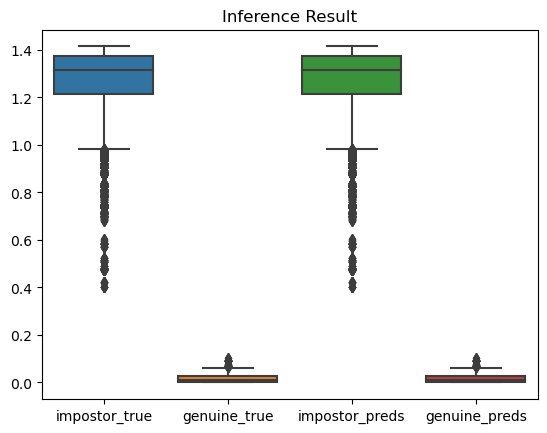

In [28]:
import seaborn as sns

np.random.seed(111)

all_arr = [impostor_true, genuine_true, impostor_preds, genuine_preds]

ax = sns.boxplot(data=all_arr)

ax.set_xticklabels(['impostor_true', 'genuine_true', 'impostor_preds', 'genuine_preds'])
ax.set_title("Inference Result") 


From the figure above, it looks like we set a right threshold! Our model can clearly distinguish between the impostor and genuine.

Now, let's see the accuracy of our model.

In [22]:
print('TF-Original Impostor Acc:', round(len(impostor_preds)/len(impostor_true),2))
print('TF-Original Genuine Acc:', round(len(genuine_preds)/len(genuine_true),2))

TF-Original Impostor Acc: 1.0
TF-Original Genuine Acc: 1.0


Based on our model performance and the threshold that we set, we can achieve 100% accuracy on 200 randomly picked data points.

---
# Conclusion

In this project, we have successfully developed a fingerprint verification model based on the siamese network architecture. We used MobileNetV2 as the encoder for the network and achieved outstanding results on our test set of 200 data points. The use of a siamese network architecture allowed us to train a model with a relatively small number of data points while maintaining high accuracy. Additionally, using MobileNetV2 as the encoder allowed us to develop a model with a low number of parameters, making it suitable for deployment on mobile and embedded devices.

---
# References
[1] Sandler, M., Howard, A., Zhu, M., Zhmoginov, A. and Chen, L.C., 2018. Mobilenetv2: Inverted residuals and linear bottlenecks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4510-4520).

[2] Koch, G., Zemel, R. and Salakhutdinov, R., 2015, July. Siamese neural networks for one-shot image recognition. In ICML deep learning workshop (Vol. 2, No. 1).